## Observed data, clustering with KMeans

In [ ]:
import numpy as np
import pandas as pd
import os
import cluster_data
import cluster_plotter
from cluster_data import run_clustering, normalize_data, unnormalize
from cluster_plotter import ClusterPlotter
from clustering_utils import ClusterData
from kmeans import k_means
import getdata

# Define observed files
uncorr_obs_files = {
    year: f"ogs{year}01_12_det.ele_ucorr" if year != 2002 else f"ogs{year}08_12_det.ele_ucorr"
    for year in range(2002, 2024) if year != 2018  # Exclude 2018 if missing
}

print(uncorr_obs_files)

standard_year_ranges = {f"{start}-{start + 3}": np.arange(start, start + 4) for start in [2002, 2006, 2010, 2014]}
standard_year_ranges["2019-2023"] = np.arange(2019, 2024)

running_ranges = cluster_data.generate_running_year_ranges(2002, 2023, 4)
year_ranges = running_ranges

# Bin the observed data
binned_data = cluster_data.bin_observed_data(uncorr_obs_files, year_ranges, print_res=False)

# Output directory for plots
plot_dir = "kmeans_observed_running_bins"
os.makedirs(plot_dir, exist_ok=True)
cluster_plotter.clear_directory(plot_dir)

for cluster_data, year_range in binned_data:
    print(f"\nRunning K-Means for Year Range: {year_range}")
    
    data_array = np.array([cluster_data.inc, cluster_data.raan]).T
    normalized_data, data_min, data_max = normalize_data(data_array)
    
    results = []
    for k in [3, 4, 5, 6, 7]:
        result_kmeans, time_kmeans, n_clusters_kmeans, points_per_cluster_kmeans, metrics_kmeans = run_clustering(
            k_means, "K-Means", normalized_data, data_min, data_max, k, plot=False
        )

        unnormalized_data, cluster_centers = unnormalize(result_kmeans.data, result_kmeans.cluster_centers, data_min, data_max)
        plotter = ClusterPlotter(unnormalized_data, result_kmeans.labels, cluster_centers)
        plotter.clusters_2d_plot(f"K-Means: years = {year_range}, k = {k}", os.path.join(plot_dir, f"kmeans_{year_range}_k{k}.png"))

        results.append({
            "Year Range": year_range, "k": k, "Runtime (s)": f"{time_kmeans:.3f}", "Clusters": n_clusters_kmeans,
            "Points per Cluster": points_per_cluster_kmeans,
            "Davies-Bouldin": f"{metrics_kmeans[0]:.3f}" if metrics_kmeans else None,
            "Calinski-Harabasz": f"{metrics_kmeans[1]:.3f}" if metrics_kmeans else None,
            "Dunn Index": f"{metrics_kmeans[2]:.3f}" if metrics_kmeans else None,
            "Silhouette Score": f"{metrics_kmeans[3]:.3f}" if metrics_kmeans else None
        })
    
    display(pd.DataFrame(results))

## Observed data, clustering with DBSCAN

In [1]:
import numpy as np
import pandas as pd
import os
import cluster_data
import cluster_plotter
from cluster_data import run_clustering, normalize_data, unnormalize
from cluster_plotter import ClusterPlotter
from clustering_utils import ClusterData
from DBSCAN import dbscan_clustering  # Assuming you have a DBSCAN implementation
import getdata

# Define observed files
uncorr_obs_files = {
    year: f"ogs{year}01_12_det.ele_ucorr" if year != 2002 else f"ogs{year}08_12_det.ele_ucorr"
    for year in range(2002, 2024) if year != 2018  # Exclude 2018 if missing
}

print(uncorr_obs_files)

standard_year_ranges = {f"{start}-{start + 3}": np.arange(start, start + 4) for start in [2002, 2006, 2010, 2014]}
standard_year_ranges["2019-2023"] = np.arange(2019, 2024)

running_ranges = cluster_data.generate_running_year_ranges(2002, 2023, 4)
year_ranges = running_ranges

# Bin the observed data
binned_data = cluster_data.bin_observed_data(uncorr_obs_files, year_ranges, print_res=False)

# Output directory for plots
plot_dir = "dbscan_observed_running_bins"
os.makedirs(plot_dir, exist_ok=True)
cluster_plotter.clear_directory(plot_dir)

for cluster_data, year_range in binned_data:
    print(f"\nRunning DBSCAN for Year Range: {year_range}")
    
    data_array = np.array([cluster_data.inc, cluster_data.raan]).T
    normalized_data, data_min, data_max = normalize_data(data_array)
    
    results = []
    eps_values = [0.02, 0.01, 0.015, 0.05]
    min_samples_values = [10, 15, 20, 25]
    for eps in eps_values:
        for min_samples in min_samples_values:
            result_dbscan, time_dbscan, n_clusters_dbscan, points_per_cluster_dbscan, metrics_dbscan = run_clustering(
                dbscan_clustering, "DBSCAN", normalized_data, data_min, data_max, plot=False, eps=eps, min_samples=min_samples
            )

            unnormalized_data, cluster_centers = unnormalize(result_dbscan.data, result_dbscan.cluster_centers, data_min, data_max)
            plotter = ClusterPlotter(unnormalized_data, result_dbscan.labels, cluster_centers)
            plotter.clusters_2d_plot(
                f"DBSCAN: years = {year_range}, eps = {eps}, min_samples = {min_samples}",
                os.path.join(plot_dir, f"dbscan_{year_range}_eps{eps}_min{min_samples}.png")
            )

            results.append({
                "Year Range": year_range, "eps": eps, "min_samples": min_samples, "Runtime (s)": f"{time_dbscan:.3f}",
                "Clusters": n_clusters_dbscan, "Points per Cluster": points_per_cluster_dbscan,
                "Davies-Bouldin": f"{metrics_dbscan[0]:.3f}" if metrics_dbscan else None,
                "Calinski-Harabasz": f"{metrics_dbscan[1]:.3f}" if metrics_dbscan else None,
                "Dunn Index": f"{metrics_dbscan[2]:.3f}" if metrics_dbscan else None,
                "Silhouette Score": f"{metrics_dbscan[3]:.3f}" if metrics_dbscan else None
            })
    
    display(pd.DataFrame(results))


{2002: 'ogs200208_12_det.ele_ucorr', 2003: 'ogs200301_12_det.ele_ucorr', 2004: 'ogs200401_12_det.ele_ucorr', 2005: 'ogs200501_12_det.ele_ucorr', 2006: 'ogs200601_12_det.ele_ucorr', 2007: 'ogs200701_12_det.ele_ucorr', 2008: 'ogs200801_12_det.ele_ucorr', 2009: 'ogs200901_12_det.ele_ucorr', 2010: 'ogs201001_12_det.ele_ucorr', 2011: 'ogs201101_12_det.ele_ucorr', 2012: 'ogs201201_12_det.ele_ucorr', 2013: 'ogs201301_12_det.ele_ucorr', 2014: 'ogs201401_12_det.ele_ucorr', 2015: 'ogs201501_12_det.ele_ucorr', 2016: 'ogs201601_12_det.ele_ucorr', 2017: 'ogs201701_12_det.ele_ucorr', 2019: 'ogs201901_12_det.ele_ucorr', 2020: 'ogs202001_12_det.ele_ucorr', 2021: 'ogs202101_12_det.ele_ucorr', 2022: 'ogs202201_12_det.ele_ucorr', 2023: 'ogs202301_12_det.ele_ucorr'}

Running DBSCAN for Year Range: 2002-2005
Runtime for dbscan_clustering: 0.050999 seconds
Plot saved as: dbscan_observed_running_bins\dbscan_2002-2005_eps0.02_min10.png
Runtime for dbscan_clustering: 0.041900 seconds
Plot saved as: dbscan_obse

,Year Range,eps,min_samples,Runtime (s),Clusters,Points per Cluster,Davies-Bouldin,Calinski-Harabasz,Dunn Index,Silhouette Score
0,2002-2005,0.020,10,0.051,30,"{0: 30, 1: 81, 2: 4661, 3: 54, 4: 18, 5: 8, 6:...",2.971,54.250,0.001,-0.490
1,2002-2005,0.020,15,0.042,15,"{0: 17, 1: 4357, 2: 15, 3: 28, 4: 13, 5: 9, 6:...",4.931,50.501,0.002,-0.512
2,2002-2005,0.020,20,0.034,10,"{0: 4032, 1: 21, 2: 22, 3: 25, 4: 21, 5: 16, 6...",5.649,30.372,0.001,-0.326
3,2002-2005,0.020,25,0.033,2,"{0: 3947, -1: 2405}",5.812,158.350,0.002,-0.124
4,2002-2005,0.010,10,0.028,28,"{0: 14, 1: 3437, 2: 13, 3: 12, 4: 29, 5: 13, 6...",2.353,26.275,0.001,-0.659
5,2002-2005,0.010,15,0.020,15,"{0: 1360, 1: 30, 2: 16, 3: 323, 4: 25, 5: 17, ...",2.549,175.731,0.000,-0.202
6,2002-2005,0.010,20,0.028,18,"{0: 1120, 1: 82, 2: 22, 3: 266, 4: 17, 5: 20, ...",2.598,122.398,0.000,-0.177
7,2002-2005,0.010,25,0.037,11,"{0: 1072, 1: 21, 2: 75, 3: 25, 4: 236, 5: 30, ...",2.901,191.939,0.000,-0.152
8,2002-2005,0.015,10,0.041,34,"{0: 17, 1: 4021, 2: 18, 3: 14, 4: 18, 5: 21, 6...",2.295,40.427,0.001,-0.535
9,2002-2005,0.015,15,0.041,15,"{0: 3848, 1: 15, 2: 15, 3: 26, 4: 15, 5: 20, 6...",5.426,26.603,0.000,-0.601



Running DBSCAN for Year Range: 2003-2006
Runtime for dbscan_clustering: 0.109066 seconds
Plot saved as: dbscan_observed_running_bins\dbscan_2003-2006_eps0.02_min10.png
Runtime for dbscan_clustering: 0.044835 seconds
Plot saved as: dbscan_observed_running_bins\dbscan_2003-2006_eps0.02_min15.png
Runtime for dbscan_clustering: 0.040383 seconds
Plot saved as: dbscan_observed_running_bins\dbscan_2003-2006_eps0.02_min20.png
Runtime for dbscan_clustering: 0.052271 seconds
Plot saved as: dbscan_observed_running_bins\dbscan_2003-2006_eps0.02_min25.png
Runtime for dbscan_clustering: 0.035226 seconds
Plot saved as: dbscan_observed_running_bins\dbscan_2003-2006_eps0.01_min10.png
Runtime for dbscan_clustering: 0.027561 seconds
Plot saved as: dbscan_observed_running_bins\dbscan_2003-2006_eps0.01_min15.png
Runtime for dbscan_clustering: 0.041529 seconds
Plot saved as: dbscan_observed_running_bins\dbscan_2003-2006_eps0.01_min20.png
Runtime for dbscan_clustering: 0.029305 seconds
Plot saved as: dbscan

,Year Range,eps,min_samples,Runtime (s),Clusters,Points per Cluster,Davies-Bouldin,Calinski-Harabasz,Dunn Index,Silhouette Score
0,2003-2006,0.020,10,0.109,27,"{0: 10, 1: 5434, 2: 10, 3: 12, 4: 10, 5: 20, 6...",1.698,39.716,0.001,-0.463
1,2003-2006,0.020,15,0.045,14,"{0: 4924, 1: 82, 2: 30, 3: 32, 4: 11, 5: 16, 6...",4.858,40.004,0.001,-0.446
2,2003-2006,0.020,20,0.040,9,"{0: 4618, 1: 20, 2: 24, 3: 22, 4: 20, 5: 21, 6...",5.448,39.971,0.001,-0.381
3,2003-2006,0.020,25,0.052,6,"{0: 4434, 1: 16, 2: 30, 3: 29, 4: 49, -1: 2493}",3.983,39.628,0.001,-0.275
4,2003-2006,0.010,10,0.035,26,"{0: 3870, 1: 14, 2: 13, 3: 12, 4: 13, 5: 11, 6...",3.132,28.071,0.001,-0.623
5,2003-2006,0.010,15,0.028,13,"{0: 2368, 1: 21, 2: 1151, 3: 26, 4: 23, 5: 26,...",2.435,175.098,0.001,-0.494
6,2003-2006,0.010,20,0.042,19,"{0: 1282, 1: 83, 2: 25, 3: 147, 4: 32, 5: 161,...",2.449,136.432,0.000,-0.216
7,2003-2006,0.010,25,0.029,17,"{0: 1220, 1: 25, 2: 46, 3: 123, 4: 32, 5: 59, ...",2.360,142.069,0.001,-0.209
8,2003-2006,0.015,10,0.039,33,"{0: 4542, 1: 62, 2: 51, 3: 26, 4: 5, 5: 17, 6:...",2.759,34.238,0.001,-0.571
9,2003-2006,0.015,15,0.037,12,"{0: 4324, 1: 19, 2: 23, 3: 29, 4: 21, 5: 23, 6...",2.499,39.222,0.000,-0.396



Running DBSCAN for Year Range: 2004-2007
Runtime for dbscan_clustering: 0.049515 seconds
Plot saved as: dbscan_observed_running_bins\dbscan_2004-2007_eps0.02_min10.png
Runtime for dbscan_clustering: 0.039191 seconds
Plot saved as: dbscan_observed_running_bins\dbscan_2004-2007_eps0.02_min15.png
Runtime for dbscan_clustering: 0.044211 seconds
Plot saved as: dbscan_observed_running_bins\dbscan_2004-2007_eps0.02_min20.png
Runtime for dbscan_clustering: 0.042928 seconds
Plot saved as: dbscan_observed_running_bins\dbscan_2004-2007_eps0.02_min25.png
Runtime for dbscan_clustering: 0.028786 seconds
Plot saved as: dbscan_observed_running_bins\dbscan_2004-2007_eps0.01_min10.png
Runtime for dbscan_clustering: 0.028404 seconds
Plot saved as: dbscan_observed_running_bins\dbscan_2004-2007_eps0.01_min15.png
Runtime for dbscan_clustering: 0.036443 seconds
Plot saved as: dbscan_observed_running_bins\dbscan_2004-2007_eps0.01_min20.png
Runtime for dbscan_clustering: 0.031711 seconds
Plot saved as: dbscan

,Year Range,eps,min_samples,Runtime (s),Clusters,Points per Cluster,Davies-Bouldin,Calinski-Harabasz,Dunn Index,Silhouette Score
0,2004-2007,0.020,10,0.050,22,"{0: 19, 1: 4859, 2: 10, 3: 16, 4: 10, 5: 4, 6:...",1.692,43.953,0.003,-0.493
1,2004-2007,0.020,15,0.039,8,"{0: 4501, 1: 20, 2: 77, 3: 14, 4: 21, 5: 21, 6...",2.303,77.272,0.001,-0.227
2,2004-2007,0.020,20,0.044,8,"{0: 4038, 1: 83, 2: 34, 3: 31, 4: 35, 5: 33, 6...",3.244,52.062,0.001,-0.288
3,2004-2007,0.020,25,0.043,7,"{0: 3945, 1: 22, 2: 29, 3: 14, 4: 25, 5: 72, -...",2.907,57.396,0.001,-0.366
4,2004-2007,0.010,10,0.029,20,"{0: 2534, 1: 17, 2: 22, 3: 13, 4: 8, 5: 10, 6:...",1.694,99.393,0.001,-0.472
5,2004-2007,0.010,15,0.028,14,"{0: 2286, 1: 15, 2: 73, 3: 142, 4: 213, 5: 158...",2.390,122.530,0.001,-0.383
6,2004-2007,0.010,20,0.036,17,"{0: 1078, 1: 8, 2: 33, 3: 27, 4: 68, 5: 110, 6...",2.194,111.653,0.000,-0.156
7,2004-2007,0.010,25,0.032,17,"{0: 1012, 1: 25, 2: 20, 3: 25, 4: 34, 5: 102, ...",2.198,101.382,0.000,-0.185
8,2004-2007,0.015,10,0.041,28,"{0: 80, 1: 4094, 2: 12, 3: 14, 4: 21, 5: 20, 6...",2.955,31.593,0.001,-0.558
9,2004-2007,0.015,15,0.035,12,"{0: 3774, 1: 25, 2: 15, 3: 22, 4: 15, 5: 19, 6...",2.901,41.098,0.001,-0.425



Running DBSCAN for Year Range: 2005-2008
Runtime for dbscan_clustering: 0.095044 seconds
Plot saved as: dbscan_observed_running_bins\dbscan_2005-2008_eps0.02_min10.png
Runtime for dbscan_clustering: 0.094603 seconds
Plot saved as: dbscan_observed_running_bins\dbscan_2005-2008_eps0.02_min15.png
Runtime for dbscan_clustering: 0.079048 seconds
Plot saved as: dbscan_observed_running_bins\dbscan_2005-2008_eps0.02_min20.png
Runtime for dbscan_clustering: 0.095224 seconds
Plot saved as: dbscan_observed_running_bins\dbscan_2005-2008_eps0.02_min25.png
Runtime for dbscan_clustering: 0.056195 seconds
Plot saved as: dbscan_observed_running_bins\dbscan_2005-2008_eps0.01_min10.png
Runtime for dbscan_clustering: 0.063317 seconds
Plot saved as: dbscan_observed_running_bins\dbscan_2005-2008_eps0.01_min15.png
Runtime for dbscan_clustering: 0.057484 seconds
Plot saved as: dbscan_observed_running_bins\dbscan_2005-2008_eps0.01_min20.png
Runtime for dbscan_clustering: 0.063290 seconds
Plot saved as: dbscan

,Year Range,eps,min_samples,Runtime (s),Clusters,Points per Cluster,Davies-Bouldin,Calinski-Harabasz,Dunn Index,Silhouette Score
0,2005-2008,0.020,10,0.095,16,"{0: 4589, 1: 17, 2: 13, 3: 11, 4: 10, 5: 10, 6...",1.696,43.806,0.000,-0.380
1,2005-2008,0.020,15,0.095,7,"{0: 4181, 1: 24, 2: 83, 3: 26, 4: 11, 5: 23, -...",2.533,86.629,0.001,-0.219
2,2005-2008,0.020,20,0.079,7,"{0: 122, 1: 3841, 2: 54, 3: 34, 4: 25, 5: 23, ...",3.444,82.891,0.001,-0.249
3,2005-2008,0.020,25,0.095,5,"{0: 3715, 1: 83, 2: 48, 3: 25, -1: 2150}",3.265,97.040,0.001,-0.226
4,2005-2008,0.010,10,0.056,29,"{0: 2566, 1: 36, 2: 22, 3: 25, 4: 11, 5: 11, 6...",2.685,56.470,0.001,-0.433
5,2005-2008,0.010,15,0.063,21,"{0: 1024, 1: 22, 2: 11, 3: 140, 4: 22, 5: 15, ...",1.994,77.433,0.001,-0.234
6,2005-2008,0.010,20,0.057,16,"{0: 994, 1: 124, 2: 13, 3: 26, 4: 17, 5: 32, 6...",2.127,82.708,0.001,-0.211
7,2005-2008,0.010,25,0.063,12,"{0: 965, 1: 28, 2: 40, 3: 27, 4: 25, 5: 104, 6...",1.916,100.245,0.000,-0.152
8,2005-2008,0.015,10,0.080,25,"{0: 113, 1: 3775, 2: 10, 3: 11, 4: 13, 5: 70, ...",3.441,37.647,0.002,-0.528
9,2005-2008,0.015,15,0.079,9,"{0: 63, 1: 3549, 2: 39, 3: 35, 4: 16, 5: 24, 6...",2.373,68.406,0.001,-0.248



Running DBSCAN for Year Range: 2006-2009
Runtime for dbscan_clustering: 0.087589 seconds
Plot saved as: dbscan_observed_running_bins\dbscan_2006-2009_eps0.02_min10.png
Runtime for dbscan_clustering: 0.078688 seconds
Plot saved as: dbscan_observed_running_bins\dbscan_2006-2009_eps0.02_min15.png
Runtime for dbscan_clustering: 0.158188 seconds
Plot saved as: dbscan_observed_running_bins\dbscan_2006-2009_eps0.02_min20.png
Runtime for dbscan_clustering: 0.095407 seconds
Plot saved as: dbscan_observed_running_bins\dbscan_2006-2009_eps0.02_min25.png
Runtime for dbscan_clustering: 0.017827 seconds
Plot saved as: dbscan_observed_running_bins\dbscan_2006-2009_eps0.01_min10.png
Runtime for dbscan_clustering: 0.033065 seconds
Plot saved as: dbscan_observed_running_bins\dbscan_2006-2009_eps0.01_min15.png
Runtime for dbscan_clustering: 0.030734 seconds
Plot saved as: dbscan_observed_running_bins\dbscan_2006-2009_eps0.01_min20.png
Runtime for dbscan_clustering: 0.031741 seconds
Plot saved as: dbscan

,Year Range,eps,min_samples,Runtime (s),Clusters,Points per Cluster,Davies-Bouldin,Calinski-Harabasz,Dunn Index,Silhouette Score
0,2006-2009,0.020,10,0.088,14,"{0: 4212, 1: 69, 2: 16, 3: 11, 4: 19, 5: 12, 6...",2.216,59.637,0.001,-0.376
1,2006-2009,0.020,15,0.079,11,"{0: 3837, 1: 15, 2: 12, 3: 70, 4: 27, 5: 66, 6...",1.828,96.228,0.001,-0.320
2,2006-2009,0.020,20,0.158,9,"{0: 3628, 1: 67, 2: 14, 3: 22, 4: 51, 5: 17, 6...",2.742,101.235,0.001,-0.265
3,2006-2009,0.020,25,0.095,6,"{0: 107, 1: 3212, 2: 66, 3: 219, 4: 34, -1: 1907}",2.604,217.827,0.000,-0.122
4,2006-2009,0.010,10,0.018,29,"{0: 54, 1: 2359, 2: 18, 3: 16, 4: 34, 5: 8, 6:...",2.055,50.783,0.000,-0.376
5,2006-2009,0.010,15,0.033,18,"{0: 2220, 1: 18, 2: 105, 3: 22, 4: 22, 5: 16, ...",2.021,55.039,0.001,-0.382
6,2006-2009,0.010,20,0.031,11,"{0: 817, 1: 20, 2: 85, 3: 148, 4: 39, 5: 85, 6...",1.732,116.027,0.001,-0.261
7,2006-2009,0.010,25,0.032,12,"{0: 763, 1: 36, 2: 85, 3: 50, 4: 89, 5: 28, 6:...",1.869,95.676,0.000,-0.218
8,2006-2009,0.015,10,0.031,21,"{0: 3569, 1: 10, 2: 11, 3: 14, 4: 10, 5: 62, 6...",3.531,51.264,0.001,-0.476
9,2006-2009,0.015,15,0.028,13,"{0: 94, 1: 2858, 2: 32, 3: 28, 4: 247, 5: 23, ...",2.277,125.479,0.000,-0.253



Running DBSCAN for Year Range: 2007-2010
Runtime for dbscan_clustering: 0.044929 seconds
Plot saved as: dbscan_observed_running_bins\dbscan_2007-2010_eps0.02_min10.png
Runtime for dbscan_clustering: 0.025153 seconds
Plot saved as: dbscan_observed_running_bins\dbscan_2007-2010_eps0.02_min15.png
Runtime for dbscan_clustering: 0.027879 seconds
Plot saved as: dbscan_observed_running_bins\dbscan_2007-2010_eps0.02_min20.png
Runtime for dbscan_clustering: 0.024201 seconds
Plot saved as: dbscan_observed_running_bins\dbscan_2007-2010_eps0.02_min25.png
Runtime for dbscan_clustering: 0.014554 seconds
Plot saved as: dbscan_observed_running_bins\dbscan_2007-2010_eps0.01_min10.png
Runtime for dbscan_clustering: 0.019919 seconds
Plot saved as: dbscan_observed_running_bins\dbscan_2007-2010_eps0.01_min15.png
Runtime for dbscan_clustering: 0.020175 seconds
Plot saved as: dbscan_observed_running_bins\dbscan_2007-2010_eps0.01_min20.png
Runtime for dbscan_clustering: 0.021917 seconds
Plot saved as: dbscan

,Year Range,eps,min_samples,Runtime (s),Clusters,Points per Cluster,Davies-Bouldin,Calinski-Harabasz,Dunn Index,Silhouette Score
0,2007-2010,0.020,10,0.045,13,"{0: 3333, 1: 83, 2: 23, 3: 13, 4: 15, 5: 7, 6:...",2.076,84.333,0.002,-0.304
1,2007-2010,0.020,15,0.025,8,"{0: 3140, 1: 82, 2: 43, 3: 21, 4: 16, 5: 25, 6...",1.831,135.662,0.002,-0.229
2,2007-2010,0.020,20,0.028,7,"{0: 99, 1: 2927, 2: 82, 3: 33, 4: 21, 5: 25, -...",2.709,150.306,0.000,-0.170
3,2007-2010,0.020,25,0.024,6,"{0: 75, 1: 2784, 2: 82, 3: 29, 4: 88, -1: 1426}",2.815,179.483,0.000,-0.135
4,2007-2010,0.010,10,0.015,25,"{0: 32, 1: 2037, 2: 49, 3: 12, 4: 141, 5: 19, ...",1.857,50.689,0.001,-0.412
5,2007-2010,0.010,15,0.020,20,"{0: 1050, 1: 49, 2: 15, 3: 24, 4: 126, 5: 16, ...",1.819,79.706,0.001,-0.234
6,2007-2010,0.010,20,0.020,15,"{0: 639, 1: 34, 2: 55, 3: 23, 4: 70, 5: 31, 6:...",1.710,84.513,0.000,-0.173
7,2007-2010,0.010,25,0.022,14,"{0: 626, 1: 25, 2: 55, 3: 64, 4: 31, 5: 28, 6:...",1.809,72.888,0.000,-0.213
8,2007-2010,0.015,10,0.027,14,"{0: 2833, 1: 80, 2: 13, 3: 31, 4: 18, 5: 92, 6...",2.270,96.149,0.001,-0.390
9,2007-2010,0.015,15,0.017,9,"{0: 41, 1: 2683, 2: 79, 3: 20, 4: 70, 5: 18, 6...",2.557,122.618,0.001,-0.236



Running DBSCAN for Year Range: 2008-2011
Runtime for dbscan_clustering: 0.032501 seconds
Plot saved as: dbscan_observed_running_bins\dbscan_2008-2011_eps0.02_min10.png
Runtime for dbscan_clustering: 0.023758 seconds
Plot saved as: dbscan_observed_running_bins\dbscan_2008-2011_eps0.02_min15.png
Runtime for dbscan_clustering: 0.033244 seconds
Plot saved as: dbscan_observed_running_bins\dbscan_2008-2011_eps0.02_min20.png
Runtime for dbscan_clustering: 0.022961 seconds
Plot saved as: dbscan_observed_running_bins\dbscan_2008-2011_eps0.02_min25.png
Runtime for dbscan_clustering: 0.018139 seconds
Plot saved as: dbscan_observed_running_bins\dbscan_2008-2011_eps0.01_min10.png
Runtime for dbscan_clustering: 0.007571 seconds
Plot saved as: dbscan_observed_running_bins\dbscan_2008-2011_eps0.01_min15.png
Runtime for dbscan_clustering: 0.019574 seconds
Plot saved as: dbscan_observed_running_bins\dbscan_2008-2011_eps0.01_min20.png
Runtime for dbscan_clustering: 0.019041 seconds
Plot saved as: dbscan

,Year Range,eps,min_samples,Runtime (s),Clusters,Points per Cluster,Davies-Bouldin,Calinski-Harabasz,Dunn Index,Silhouette Score
0,2008-2011,0.020,10,0.033,16,"{0: 2929, 1: 80, 2: 11, 3: 14, 4: 29, 5: 111, ...",1.961,104.425,0.003,-0.272
1,2008-2011,0.020,15,0.024,12,"{0: 109, 1: 2737, 2: 79, 3: 25, 4: 57, 5: 25, ...",2.393,117.720,0.002,-0.231
2,2008-2011,0.020,20,0.033,6,"{0: 86, 1: 2693, 2: 79, 3: 50, 4: 26, -1: 1177}",2.787,181.576,0.002,-0.169
3,2008-2011,0.020,25,0.023,4,"{0: 69, 1: 2658, 2: 77, -1: 1307}",3.176,234.744,0.001,-0.210
4,2008-2011,0.010,10,0.018,22,"{0: 1249, 1: 68, 2: 72, 3: 10, 4: 38, 5: 10, 6...",1.938,96.801,0.000,-0.262
5,2008-2011,0.010,15,0.008,18,"{0: 992, 1: 63, 2: 62, 3: 33, 4: 23, 5: 124, 6...",1.752,93.769,0.000,-0.176
6,2008-2011,0.010,20,0.020,15,"{0: 964, 1: 59, 2: 46, 3: 15, 4: 120, 5: 20, 6...",1.739,85.990,0.000,-0.213
7,2008-2011,0.010,25,0.019,19,"{0: 568, 1: 34, 2: 40, 3: 16, 4: 53, 5: 101, 6...",1.770,56.841,0.000,-0.183
8,2008-2011,0.015,10,0.011,19,"{0: 70, 1: 2642, 2: 11, 3: 77, 4: 11, 5: 12, 6...",3.846,67.628,0.000,-0.328
9,2008-2011,0.015,15,0.032,9,"{0: 58, 1: 1748, 2: 70, 3: 18, 4: 16, 5: 804, ...",2.293,221.291,0.001,-0.200



Running DBSCAN for Year Range: 2009-2012
Runtime for dbscan_clustering: 0.016872 seconds
Plot saved as: dbscan_observed_running_bins\dbscan_2009-2012_eps0.02_min10.png
Runtime for dbscan_clustering: 0.018021 seconds
Plot saved as: dbscan_observed_running_bins\dbscan_2009-2012_eps0.02_min15.png
Runtime for dbscan_clustering: 0.016868 seconds
Plot saved as: dbscan_observed_running_bins\dbscan_2009-2012_eps0.02_min20.png
Runtime for dbscan_clustering: 0.006717 seconds
Plot saved as: dbscan_observed_running_bins\dbscan_2009-2012_eps0.02_min25.png
Runtime for dbscan_clustering: 0.012328 seconds
Plot saved as: dbscan_observed_running_bins\dbscan_2009-2012_eps0.01_min10.png
Runtime for dbscan_clustering: 0.016308 seconds
Plot saved as: dbscan_observed_running_bins\dbscan_2009-2012_eps0.01_min15.png
Runtime for dbscan_clustering: 0.006902 seconds
Plot saved as: dbscan_observed_running_bins\dbscan_2009-2012_eps0.01_min20.png
Runtime for dbscan_clustering: 0.017379 seconds
Plot saved as: dbscan

,Year Range,eps,min_samples,Runtime (s),Clusters,Points per Cluster,Davies-Bouldin,Calinski-Harabasz,Dunn Index,Silhouette Score
0,2009-2012,0.020,10,0.017,17,"{0: 72, 1: 2224, 2: 60, 3: 12, 4: 18, 5: 23, 6...",2.852,82.740,0.001,-0.286
1,2009-2012,0.020,15,0.018,9,"{0: 52, 1: 2190, 2: 60, 3: 19, 4: 52, 5: 19, 6...",2.409,117.647,0.001,-0.230
2,2009-2012,0.020,20,0.017,9,"{0: 46, 1: 1426, 2: 79, 3: 60, 4: 41, 5: 7, 6:...",2.264,230.882,0.000,0.005
3,2009-2012,0.020,25,0.007,7,"{0: 1416, 1: 82, 2: 58, 3: 598, 4: 34, 5: 33, ...",2.208,290.880,0.001,0.039
4,2009-2012,0.010,10,0.012,24,"{0: 843, 1: 58, 2: 43, 3: 38, 4: 11, 5: 110, 6...",1.902,77.390,0.000,-0.226
5,2009-2012,0.010,15,0.016,17,"{0: 675, 1: 58, 2: 39, 3: 33, 4: 19, 5: 97, 6:...",1.576,102.159,0.001,-0.076
6,2009-2012,0.010,20,0.007,14,"{0: 626, 1: 58, 2: 37, 3: 88, 4: 30, 5: 36, 6:...",1.802,80.252,0.000,-0.143
7,2009-2012,0.010,25,0.017,17,"{0: 267, 1: 27, 2: 33, 3: 51, 4: 49, 5: 36, 6:...",1.822,51.681,0.000,-0.145
8,2009-2012,0.015,10,0.007,21,"{0: 48, 1: 1430, 2: 70, 3: 10, 4: 58, 5: 11, 6...",3.610,106.380,0.002,-0.147
9,2009-2012,0.015,15,0.015,9,"{0: 30, 1: 1110, 2: 69, 3: 58, 4: 253, 5: 571,...",2.099,251.332,0.001,0.013



Running DBSCAN for Year Range: 2010-2013
Runtime for dbscan_clustering: 0.014271 seconds
Plot saved as: dbscan_observed_running_bins\dbscan_2010-2013_eps0.02_min10.png
Runtime for dbscan_clustering: 0.017215 seconds
Plot saved as: dbscan_observed_running_bins\dbscan_2010-2013_eps0.02_min15.png
Runtime for dbscan_clustering: 0.006773 seconds
Plot saved as: dbscan_observed_running_bins\dbscan_2010-2013_eps0.02_min20.png
Runtime for dbscan_clustering: 0.009792 seconds
Plot saved as: dbscan_observed_running_bins\dbscan_2010-2013_eps0.02_min25.png
Runtime for dbscan_clustering: 0.000000 seconds
Plot saved as: dbscan_observed_running_bins\dbscan_2010-2013_eps0.01_min10.png
Runtime for dbscan_clustering: 0.008192 seconds
Plot saved as: dbscan_observed_running_bins\dbscan_2010-2013_eps0.01_min15.png
Runtime for dbscan_clustering: 0.004872 seconds
Plot saved as: dbscan_observed_running_bins\dbscan_2010-2013_eps0.01_min20.png
Runtime for dbscan_clustering: 0.016032 seconds
Plot saved as: dbscan

,Year Range,eps,min_samples,Runtime (s),Clusters,Points per Cluster,Davies-Bouldin,Calinski-Harabasz,Dunn Index,Silhouette Score
0,2010-2013,0.020,10,0.014,16,"{0: 53, 1: 1318, 2: 13, 3: 34, 4: 11, 5: 10, 6...",4.519,65.947,0.001,-0.292
1,2010-2013,0.020,15,0.017,9,"{0: 53, 1: 936, 2: 34, 3: 22, 4: 15, 5: 358, 6...",2.841,178.722,0.001,0.012
2,2010-2013,0.020,20,0.007,9,"{0: 53, 1: 777, 2: 33, 3: 122, 4: 348, 5: 31, ...",2.318,191.765,0.001,0.038
3,2010-2013,0.020,25,0.010,7,"{0: 53, 1: 735, 2: 33, 3: 119, 4: 347, 5: 31, ...",1.424,222.238,0.001,0.141
4,2010-2013,0.010,10,0.000,26,"{0: 426, 1: 39, 2: 17, 3: 31, 4: 11, 5: 22, 6:...",1.843,47.699,0.000,-0.156
5,2010-2013,0.010,15,0.008,22,"{0: 29, 1: 36, 2: 112, 3: 17, 4: 20, 5: 18, 6:...",1.595,42.475,0.001,-0.090
6,2010-2013,0.010,20,0.005,14,"{0: 26, 1: 56, 2: 55, 3: 28, 4: 222, 5: 44, 6:...",1.505,36.302,0.001,-0.206
7,2010-2013,0.010,25,0.016,9,"{0: 26, 1: 57, 2: 221, 3: 41, 4: 63, 5: 25, 6:...",1.507,41.792,0.001,-0.221
8,2010-2013,0.015,10,0.018,17,"{0: 45, 1: 764, 2: 33, 3: 11, 4: 10, 5: 124, 6...",2.501,102.762,0.002,-0.069
9,2010-2013,0.015,15,0.006,12,"{0: 44, 1: 624, 2: 17, 3: 33, 4: 19, 5: 110, 6...",2.055,128.363,0.002,-0.073



Running DBSCAN for Year Range: 2011-2014
Runtime for dbscan_clustering: 0.000000 seconds
Plot saved as: dbscan_observed_running_bins\dbscan_2011-2014_eps0.02_min10.png
Runtime for dbscan_clustering: 0.000000 seconds
Plot saved as: dbscan_observed_running_bins\dbscan_2011-2014_eps0.02_min15.png
Runtime for dbscan_clustering: 0.017358 seconds
Plot saved as: dbscan_observed_running_bins\dbscan_2011-2014_eps0.02_min20.png
Runtime for dbscan_clustering: 0.016070 seconds
Plot saved as: dbscan_observed_running_bins\dbscan_2011-2014_eps0.02_min25.png
Runtime for dbscan_clustering: 0.020796 seconds
Plot saved as: dbscan_observed_running_bins\dbscan_2011-2014_eps0.01_min10.png
Runtime for dbscan_clustering: 0.004976 seconds
Plot saved as: dbscan_observed_running_bins\dbscan_2011-2014_eps0.01_min15.png
Runtime for dbscan_clustering: 0.000000 seconds
Plot saved as: dbscan_observed_running_bins\dbscan_2011-2014_eps0.01_min20.png
Runtime for dbscan_clustering: 0.000000 seconds
Plot saved as: dbscan

,Year Range,eps,min_samples,Runtime (s),Clusters,Points per Cluster,Davies-Bouldin,Calinski-Harabasz,Dunn Index,Silhouette Score
0,2011-2014,0.020,10,0.000,12,"{0: 35, 1: 687, 2: 11, 3: 19, 4: 11, 5: 98, 6:...",3.455,87.984,0.004,-0.168
1,2011-2014,0.020,15,0.000,9,"{0: 35, 1: 488, 2: 19, 3: 95, 4: 27, 5: 178, 6...",3.023,149.190,0.004,0.093
2,2011-2014,0.020,20,0.017,8,"{0: 34, 1: 418, 2: 94, 3: 27, 4: 166, 5: 57, 6...",1.572,129.668,0.002,0.081
3,2011-2014,0.020,25,0.016,9,"{0: 312, 1: 34, 2: 92, 3: 64, 4: 28, 5: 26, 6:...",1.747,90.815,0.001,0.042
4,2011-2014,0.010,10,0.021,26,"{0: 26, 1: 41, 2: 16, 3: 16, 4: 11, 5: 19, 6: ...",1.733,33.593,0.000,-0.044
5,2011-2014,0.010,15,0.005,15,"{0: 26, 1: 15, 2: 22, 3: 15, 4: 21, 5: 15, 6: ...",1.350,36.619,0.000,-0.230
6,2011-2014,0.010,20,0.000,9,"{0: 24, 1: 25, 2: 24, 3: 56, 4: 20, 5: 21, 6: ...",1.410,40.647,0.001,-0.317
7,2011-2014,0.010,25,0.000,4,"{0: 49, 1: 83, 2: 31, -1: 1214}",1.583,23.668,0.000,-0.454
8,2011-2014,0.015,10,0.017,14,"{0: 30, 1: 398, 2: 18, 3: 11, 4: 50, 5: 39, 6:...",2.914,92.133,0.001,-0.042
9,2011-2014,0.015,15,0.005,14,"{0: 30, 1: 287, 2: 18, 3: 78, 4: 8, 5: 49, 6: ...",1.331,83.026,0.001,-0.006



Running DBSCAN for Year Range: 2012-2015
Runtime for dbscan_clustering: 0.000000 seconds
Plot saved as: dbscan_observed_running_bins\dbscan_2012-2015_eps0.02_min10.png
Runtime for dbscan_clustering: 0.006010 seconds
Plot saved as: dbscan_observed_running_bins\dbscan_2012-2015_eps0.02_min15.png
Runtime for dbscan_clustering: 0.015842 seconds
Plot saved as: dbscan_observed_running_bins\dbscan_2012-2015_eps0.02_min20.png
Runtime for dbscan_clustering: 0.014962 seconds
Plot saved as: dbscan_observed_running_bins\dbscan_2012-2015_eps0.02_min25.png
Runtime for dbscan_clustering: 0.006440 seconds
Plot saved as: dbscan_observed_running_bins\dbscan_2012-2015_eps0.01_min10.png
Runtime for dbscan_clustering: 0.001992 seconds
Plot saved as: dbscan_observed_running_bins\dbscan_2012-2015_eps0.01_min15.png
Runtime for dbscan_clustering: 0.017928 seconds
Plot saved as: dbscan_observed_running_bins\dbscan_2012-2015_eps0.01_min20.png
Runtime for dbscan_clustering: 0.000000 seconds
Plot saved as: dbscan

,Year Range,eps,min_samples,Runtime (s),Clusters,Points per Cluster,Davies-Bouldin,Calinski-Harabasz,Dunn Index,Silhouette Score
0,2012-2015,0.020,10,0.000,12,"{0: 13, 1: 115, 2: 28, 3: 18, 4: 12, 5: 10, 6:...",1.472,66.053,0.001,-0.092
1,2012-2015,0.020,15,0.006,8,"{0: 115, 1: 17, 2: 27, 3: 37, 4: 66, 5: 34, 6:...",1.400,68.064,0.002,-0.136
2,2012-2015,0.020,20,0.016,7,"{0: 80, 1: 28, 2: 27, 3: 37, 4: 49, 5: 101, -1...",1.302,69.827,0.005,-0.188
3,2012-2015,0.020,25,0.015,6,"{0: 53, 1: 26, 2: 37, 3: 41, 4: 80, -1: 861}",1.297,64.155,0.002,-0.257
4,2012-2015,0.010,10,0.006,11,"{0: 13, 1: 26, 2: 10, 3: 6, 4: 25, 5: 34, 6: 1...",1.315,27.305,0.002,-0.377
5,2012-2015,0.010,15,0.002,5,"{0: 26, 1: 25, 2: 34, 3: 17, -1: 996}",1.003,53.708,0.002,-0.334
6,2012-2015,0.010,20,0.018,3,"{0: 24, 1: 34, -1: 1040}",0.537,92.347,0.008,-0.017
7,2012-2015,0.010,25,0.000,2,"{0: 34, -1: 1064}",0.615,69.682,0.013,-0.064
8,2012-2015,0.015,10,0.000,15,"{0: 11, 1: 21, 2: 38, 3: 11, 4: 32, 5: 11, 6: ...",1.309,37.796,0.003,-0.226
9,2012-2015,0.015,15,0.004,10,"{0: 20, 1: 35, 2: 19, 3: 25, 4: 34, 5: 15, 6: ...",1.279,38.222,0.000,-0.281



Running DBSCAN for Year Range: 2013-2016
Runtime for dbscan_clustering: 0.013450 seconds
Plot saved as: dbscan_observed_running_bins\dbscan_2013-2016_eps0.02_min10.png
Runtime for dbscan_clustering: 0.021116 seconds
Plot saved as: dbscan_observed_running_bins\dbscan_2013-2016_eps0.02_min15.png
Runtime for dbscan_clustering: 0.011245 seconds
Plot saved as: dbscan_observed_running_bins\dbscan_2013-2016_eps0.02_min20.png
Runtime for dbscan_clustering: 0.014992 seconds
Plot saved as: dbscan_observed_running_bins\dbscan_2013-2016_eps0.02_min25.png
Runtime for dbscan_clustering: 0.000000 seconds
Plot saved as: dbscan_observed_running_bins\dbscan_2013-2016_eps0.01_min10.png
Runtime for dbscan_clustering: 0.013604 seconds
Plot saved as: dbscan_observed_running_bins\dbscan_2013-2016_eps0.01_min15.png
Runtime for dbscan_clustering: 0.007162 seconds
Plot saved as: dbscan_observed_running_bins\dbscan_2013-2016_eps0.01_min20.png
Runtime for dbscan_clustering: 0.004013 seconds
Plot saved as: dbscan

,Year Range,eps,min_samples,Runtime (s),Clusters,Points per Cluster,Davies-Bouldin,Calinski-Harabasz,Dunn Index,Silhouette Score
0,2013-2016,0.020,10,0.013,20,"{0: 23, 1: 295, 2: 36, 3: 16, 4: 16, 5: 32, 6:...",1.748,61.580,0.002,-0.111
1,2013-2016,0.020,15,0.021,18,"{0: 19, 1: 130, 2: 18, 3: 29, 4: 18, 5: 16, 6:...",1.652,39.643,0.002,-0.237
2,2013-2016,0.020,20,0.011,8,"{0: 93, 1: 34, 2: 40, 3: 37, 4: 24, 5: 30, 6: ...",1.200,62.466,0.001,-0.296
3,2013-2016,0.020,25,0.015,6,"{0: 82, 1: 35, 2: 39, 3: 37, 4: 26, -1: 1202}",1.059,69.109,0.004,-0.285
4,2013-2016,0.010,10,0.000,10,"{0: 10, 1: 45, 2: 5, 3: 25, 4: 10, 5: 25, 6: 1...",1.157,31.243,0.001,-0.443
5,2013-2016,0.010,15,0.014,5,"{0: 36, 1: 18, 2: 25, 3: 34, -1: 1308}",0.976,49.404,0.004,-0.338
6,2013-2016,0.010,20,0.007,3,"{0: 24, 1: 34, -1: 1363}",0.581,79.676,0.008,-0.092
7,2013-2016,0.010,25,0.004,2,"{0: 34, -1: 1387}",0.658,61.665,0.013,-0.116
8,2013-2016,0.015,10,0.017,25,"{0: 120, 1: 12, 2: 10, 3: 21, 4: 18, 5: 10, 6:...",1.628,32.969,0.001,-0.250
9,2013-2016,0.015,15,0.009,8,"{0: 68, 1: 34, 2: 16, 3: 37, 4: 34, 5: 20, 6: ...",1.309,45.568,0.003,-0.389



Running DBSCAN for Year Range: 2014-2017
Runtime for dbscan_clustering: 0.000998 seconds
Plot saved as: dbscan_observed_running_bins\dbscan_2014-2017_eps0.02_min10.png
Runtime for dbscan_clustering: 0.016834 seconds
Plot saved as: dbscan_observed_running_bins\dbscan_2014-2017_eps0.02_min15.png
Runtime for dbscan_clustering: 0.008149 seconds
Plot saved as: dbscan_observed_running_bins\dbscan_2014-2017_eps0.02_min20.png
Runtime for dbscan_clustering: 0.017143 seconds
Plot saved as: dbscan_observed_running_bins\dbscan_2014-2017_eps0.02_min25.png
Runtime for dbscan_clustering: 0.000000 seconds
Plot saved as: dbscan_observed_running_bins\dbscan_2014-2017_eps0.01_min10.png
Runtime for dbscan_clustering: 0.000000 seconds
Plot saved as: dbscan_observed_running_bins\dbscan_2014-2017_eps0.01_min15.png
Runtime for dbscan_clustering: 0.005196 seconds
Plot saved as: dbscan_observed_running_bins\dbscan_2014-2017_eps0.01_min20.png
Runtime for dbscan_clustering: 0.005702 seconds
Plot saved as: dbscan

,Year Range,eps,min_samples,Runtime (s),Clusters,Points per Cluster,Davies-Bouldin,Calinski-Harabasz,Dunn Index,Silhouette Score
0,2014-2017,0.020,10,0.001,22,"{0: 24, 1: 84, 2: 371, 3: 129, 4: 10, 5: 20, 6...",2.060,58.411,0.001,-0.159
1,2014-2017,0.020,15,0.017,14,"{0: 216, 1: 47, 2: 15, 3: 58, 4: 21, 5: 22, 6:...",1.835,53.508,0.001,-0.232
2,2014-2017,0.020,20,0.008,9,"{0: 82, 1: 108, 2: 45, 3: 19, 4: 55, 5: 37, 6:...",1.578,69.312,0.003,-0.206
3,2014-2017,0.020,25,0.017,8,"{0: 96, 1: 26, 2: 42, 3: 36, 4: 38, 5: 28, 6: ...",2.003,62.849,0.000,-0.301
4,2014-2017,0.010,10,0.000,15,"{0: 52, 1: 14, 2: 12, 3: 12, 4: 19, 5: 16, 6: ...",1.582,28.659,0.003,-0.444
5,2014-2017,0.010,15,0.000,8,"{0: 15, 1: 10, 2: 15, 3: 16, 4: 15, 5: 25, 6: ...",1.207,36.716,0.002,-0.472
6,2014-2017,0.010,20,0.005,3,"{0: 24, 1: 35, -1: 1494}",0.502,104.023,0.008,0.010
7,2014-2017,0.010,25,0.006,2,"{0: 35, -1: 1518}",0.564,85.062,0.013,-0.038
8,2014-2017,0.015,10,0.000,24,"{0: 198, 1: 10, 2: 36, 3: 13, 4: 11, 5: 55, 6:...",2.631,30.235,0.001,-0.299
9,2014-2017,0.015,15,0.009,9,"{0: 74, 1: 29, 2: 40, 3: 17, 4: 35, 5: 35, 6: ...",1.893,51.331,0.000,-0.387



Running DBSCAN for Year Range: 2015-2018
Runtime for dbscan_clustering: 0.015681 seconds
Plot saved as: dbscan_observed_running_bins\dbscan_2015-2018_eps0.02_min10.png
Runtime for dbscan_clustering: 0.000000 seconds
Plot saved as: dbscan_observed_running_bins\dbscan_2015-2018_eps0.02_min15.png
Runtime for dbscan_clustering: 0.004577 seconds
Plot saved as: dbscan_observed_running_bins\dbscan_2015-2018_eps0.02_min20.png
Runtime for dbscan_clustering: 0.009141 seconds
Plot saved as: dbscan_observed_running_bins\dbscan_2015-2018_eps0.02_min25.png
Runtime for dbscan_clustering: 0.012858 seconds
Plot saved as: dbscan_observed_running_bins\dbscan_2015-2018_eps0.01_min10.png
Runtime for dbscan_clustering: 0.013086 seconds
Plot saved as: dbscan_observed_running_bins\dbscan_2015-2018_eps0.01_min15.png
Runtime for dbscan_clustering: 0.000000 seconds
Plot saved as: dbscan_observed_running_bins\dbscan_2015-2018_eps0.01_min20.png
Runtime for dbscan_clustering: 0.014594 seconds
Plot saved as: dbscan

,Year Range,eps,min_samples,Runtime (s),Clusters,Points per Cluster,Davies-Bouldin,Calinski-Harabasz,Dunn Index,Silhouette Score
0,2015-2018,0.020,10,0.016,21,"{0: 24, 1: 71, 2: 343, 3: 10, 4: 101, 5: 20, 6...",2.191,46.608,0.001,-0.195
1,2015-2018,0.020,15,0.000,14,"{0: 186, 1: 32, 2: 15, 3: 15, 4: 41, 5: 21, 6:...",1.972,31.746,0.001,-0.288
2,2015-2018,0.020,20,0.005,7,"{0: 81, 1: 95, 2: 21, 3: 43, 4: 37, 5: 35, -1:...",1.994,47.470,0.000,-0.240
3,2015-2018,0.020,25,0.009,6,"{0: 88, 1: 35, 2: 37, 3: 28, 4: 34, -1: 1219}",1.325,43.092,0.000,-0.276
4,2015-2018,0.010,10,0.013,10,"{0: 49, 1: 19, 2: 16, 3: 10, 4: 35, 5: 13, 6: ...",1.134,27.263,0.003,-0.452
5,2015-2018,0.010,15,0.013,5,"{0: 15, 1: 16, 2: 15, 3: 35, -1: 1360}",1.370,29.557,0.002,-0.479
6,2015-2018,0.010,20,0.000,2,"{0: 35, -1: 1406}",0.546,91.919,0.013,-0.023
7,2015-2018,0.010,25,0.015,2,"{0: 35, -1: 1406}",0.546,91.919,0.013,-0.023
8,2015-2018,0.015,10,0.000,25,"{0: 141, 1: 10, 2: 29, 3: 13, 4: 10, 5: 11, 6:...",2.457,20.975,0.001,-0.322
9,2015-2018,0.015,15,0.008,7,"{0: 60, 1: 33, 2: 17, 3: 35, 4: 16, 5: 36, -1:...",1.303,32.760,0.001,-0.420



Running DBSCAN for Year Range: 2016-2019
Runtime for dbscan_clustering: 0.000000 seconds
Plot saved as: dbscan_observed_running_bins\dbscan_2016-2019_eps0.02_min10.png
Runtime for dbscan_clustering: 0.007203 seconds
Plot saved as: dbscan_observed_running_bins\dbscan_2016-2019_eps0.02_min15.png
Runtime for dbscan_clustering: 0.015943 seconds
Plot saved as: dbscan_observed_running_bins\dbscan_2016-2019_eps0.02_min20.png
Runtime for dbscan_clustering: 0.000000 seconds
Plot saved as: dbscan_observed_running_bins\dbscan_2016-2019_eps0.02_min25.png
Runtime for dbscan_clustering: 0.000000 seconds
Plot saved as: dbscan_observed_running_bins\dbscan_2016-2019_eps0.01_min10.png
Runtime for dbscan_clustering: 0.000000 seconds
Plot saved as: dbscan_observed_running_bins\dbscan_2016-2019_eps0.01_min15.png
Runtime for dbscan_clustering: 0.013521 seconds
Plot saved as: dbscan_observed_running_bins\dbscan_2016-2019_eps0.01_min20.png
Runtime for dbscan_clustering: 0.000000 seconds
Plot saved as: dbscan

,Year Range,eps,min_samples,Runtime (s),Clusters,Points per Cluster,Davies-Bouldin,Calinski-Harabasz,Dunn Index,Silhouette Score
0,2016-2019,0.020,10,0.000,27,"{0: 25, 1: 16, 2: 116, 3: 18, 4: 39, 5: 54, 6:...",2.644,36.085,0.003,-0.081
1,2016-2019,0.020,15,0.007,12,"{0: 15, 1: 113, 2: 32, 3: 15, 4: 41, 5: 18, 6:...",2.803,40.020,0.001,-0.219
2,2016-2019,0.020,20,0.016,7,"{0: 107, 1: 41, 2: 130, 3: 29, 4: 27, 5: 200, ...",1.611,58.724,0.002,-0.190
3,2016-2019,0.020,25,0.000,5,"{0: 103, 1: 36, 2: 124, 3: 203, -1: 1248}",1.726,68.214,0.002,-0.135
4,2016-2019,0.010,10,0.000,17,"{0: 19, 1: 13, 2: 11, 3: 18, 4: 17, 5: 10, 6: ...",1.425,17.789,0.002,-0.420
5,2016-2019,0.010,15,0.000,10,"{0: 17, 1: 17, 2: 15, 3: 15, 4: 59, 5: 21, 6: ...",1.564,13.984,0.001,-0.483
6,2016-2019,0.010,20,0.014,2,"{0: 57, -1: 1657}",0.960,51.492,0.002,-0.326
7,2016-2019,0.010,25,0.000,2,"{0: 54, -1: 1660}",0.963,48.265,0.002,-0.331
8,2016-2019,0.015,10,0.000,19,"{0: 105, 1: 30, 2: 10, 3: 35, 4: 17, 5: 13, 6:...",2.576,31.088,0.000,-0.255
9,2016-2019,0.015,15,0.018,10,"{0: 41, 1: 37, 2: 32, 3: 17, 4: 117, 5: 21, 6:...",1.507,33.094,0.001,-0.329



Running DBSCAN for Year Range: 2017-2020
Runtime for dbscan_clustering: 0.018725 seconds
Plot saved as: dbscan_observed_running_bins\dbscan_2017-2020_eps0.02_min10.png
Runtime for dbscan_clustering: 0.020202 seconds
Plot saved as: dbscan_observed_running_bins\dbscan_2017-2020_eps0.02_min15.png
Runtime for dbscan_clustering: 0.008414 seconds
Plot saved as: dbscan_observed_running_bins\dbscan_2017-2020_eps0.02_min20.png
Runtime for dbscan_clustering: 0.015925 seconds
Plot saved as: dbscan_observed_running_bins\dbscan_2017-2020_eps0.02_min25.png
Runtime for dbscan_clustering: 0.000000 seconds
Plot saved as: dbscan_observed_running_bins\dbscan_2017-2020_eps0.01_min10.png
Runtime for dbscan_clustering: 0.017709 seconds
Plot saved as: dbscan_observed_running_bins\dbscan_2017-2020_eps0.01_min15.png
Runtime for dbscan_clustering: 0.000000 seconds
Plot saved as: dbscan_observed_running_bins\dbscan_2017-2020_eps0.01_min20.png
Runtime for dbscan_clustering: 0.009756 seconds
Plot saved as: dbscan

,Year Range,eps,min_samples,Runtime (s),Clusters,Points per Cluster,Davies-Bouldin,Calinski-Harabasz,Dunn Index,Silhouette Score
0,2017-2020,0.020,10,0.019,27,"{0: 11, 1: 24, 2: 42, 3: 100, 4: 26, 5: 6, 6: ...",2.601,46.796,0.002,-0.040
1,2017-2020,0.020,15,0.020,14,"{0: 19, 1: 86, 2: 19, 3: 15, 4: 30, 5: 20, 6: ...",3.308,49.906,0.002,-0.210
2,2017-2020,0.020,20,0.008,6,"{0: 66, 1: 26, 2: 145, 3: 36, 4: 458, -1: 1366}",1.729,70.998,0.001,-0.153
3,2017-2020,0.020,25,0.016,5,"{0: 60, 1: 132, 2: 35, 3: 444, -1: 1426}",1.614,78.439,0.001,-0.131
4,2017-2020,0.010,10,0.000,15,"{0: 24, 1: 10, 2: 17, 3: 19, 4: 77, 5: 11, 6: ...",1.562,18.820,0.002,-0.351
5,2017-2020,0.010,15,0.018,10,"{0: 24, 1: 17, 2: 59, 3: 72, 4: 162, 5: 36, 6:...",1.976,16.279,0.001,-0.370
6,2017-2020,0.010,20,0.000,8,"{0: 57, 1: 66, 2: 61, 3: 73, 4: 37, 5: 22, 6: ...",2.282,13.843,0.001,-0.244
7,2017-2020,0.010,25,0.010,8,"{0: 54, 1: 58, 2: 59, 3: 65, 4: 23, 5: 33, 6: ...",2.302,12.584,0.001,-0.255
8,2017-2020,0.015,10,0.000,22,"{0: 18, 1: 59, 2: 14, 3: 19, 4: 11, 5: 14, 6: ...",2.767,29.641,0.002,-0.231
9,2017-2020,0.015,15,0.014,9,"{0: 15, 1: 40, 2: 18, 3: 123, 4: 25, 5: 396, 6...",2.675,37.481,0.001,-0.300



Running DBSCAN for Year Range: 2018-2021
Runtime for dbscan_clustering: 0.013044 seconds
Plot saved as: dbscan_observed_running_bins\dbscan_2018-2021_eps0.02_min10.png
Runtime for dbscan_clustering: 0.004932 seconds
Plot saved as: dbscan_observed_running_bins\dbscan_2018-2021_eps0.02_min15.png
Runtime for dbscan_clustering: 0.000000 seconds
Plot saved as: dbscan_observed_running_bins\dbscan_2018-2021_eps0.02_min20.png
Runtime for dbscan_clustering: 0.000000 seconds
Plot saved as: dbscan_observed_running_bins\dbscan_2018-2021_eps0.02_min25.png
Runtime for dbscan_clustering: 0.010541 seconds
Plot saved as: dbscan_observed_running_bins\dbscan_2018-2021_eps0.01_min10.png
Runtime for dbscan_clustering: 0.014867 seconds
Plot saved as: dbscan_observed_running_bins\dbscan_2018-2021_eps0.01_min15.png
Runtime for dbscan_clustering: 0.012767 seconds
Plot saved as: dbscan_observed_running_bins\dbscan_2018-2021_eps0.01_min20.png
Runtime for dbscan_clustering: 0.007951 seconds
Plot saved as: dbscan

,Year Range,eps,min_samples,Runtime (s),Clusters,Points per Cluster,Davies-Bouldin,Calinski-Harabasz,Dunn Index,Silhouette Score
0,2018-2021,0.020,10,0.013,25,"{0: 35, 1: 58, 2: 14, 3: 13, 4: 19, 5: 11, 6: ...",1.673,50.719,0.001,-0.152
1,2018-2021,0.020,15,0.005,14,"{0: 26, 1: 48, 2: 36, 3: 29, 4: 16, 5: 24, 6: ...",1.345,57.641,0.002,-0.205
2,2018-2021,0.020,20,0.000,5,"{0: 38, 1: 150, 2: 42, 3: 588, -1: 1398}",1.670,84.409,0.001,-0.092
3,2018-2021,0.020,25,0.000,5,"{0: 32, 1: 141, 2: 38, 3: 562, -1: 1443}",1.702,74.961,0.001,-0.113
4,2018-2021,0.010,10,0.011,13,"{0: 17, 1: 12, 2: 10, 3: 20, 4: 78, 5: 11, 6: ...",1.758,20.873,0.001,-0.270
5,2018-2021,0.010,15,0.015,8,"{0: 60, 1: 27, 2: 104, 3: 223, 4: 42, 5: 44, 6...",2.229,17.594,0.001,-0.230
6,2018-2021,0.010,20,0.013,6,"{0: 58, 1: 87, 2: 222, 3: 41, 4: 36, -1: 1772}",2.408,19.079,0.002,-0.237
7,2018-2021,0.010,25,0.008,7,"{0: 55, 1: 83, 2: 196, 3: 42, 4: 20, 5: 30, -1...",2.560,14.943,0.001,-0.253
8,2018-2021,0.015,10,0.007,19,"{0: 23, 1: 43, 2: 12, 3: 10, 4: 29, 5: 13, 6: ...",1.387,37.902,0.001,-0.259
9,2018-2021,0.015,15,0.002,6,"{0: 28, 1: 127, 2: 32, 3: 548, 4: 15, -1: 1466}",1.652,54.621,0.001,-0.140



Running DBSCAN for Year Range: 2019-2022
Runtime for dbscan_clustering: 0.005883 seconds
Plot saved as: dbscan_observed_running_bins\dbscan_2019-2022_eps0.02_min10.png
Runtime for dbscan_clustering: 0.016691 seconds
Plot saved as: dbscan_observed_running_bins\dbscan_2019-2022_eps0.02_min15.png
Runtime for dbscan_clustering: 0.016671 seconds
Plot saved as: dbscan_observed_running_bins\dbscan_2019-2022_eps0.02_min20.png
Runtime for dbscan_clustering: 0.008185 seconds
Plot saved as: dbscan_observed_running_bins\dbscan_2019-2022_eps0.02_min25.png
Runtime for dbscan_clustering: 0.015923 seconds
Plot saved as: dbscan_observed_running_bins\dbscan_2019-2022_eps0.01_min10.png
Runtime for dbscan_clustering: 0.015984 seconds
Plot saved as: dbscan_observed_running_bins\dbscan_2019-2022_eps0.01_min15.png
Runtime for dbscan_clustering: 0.011131 seconds
Plot saved as: dbscan_observed_running_bins\dbscan_2019-2022_eps0.01_min20.png
Runtime for dbscan_clustering: 0.011547 seconds
Plot saved as: dbscan

,Year Range,eps,min_samples,Runtime (s),Clusters,Points per Cluster,Davies-Bouldin,Calinski-Harabasz,Dunn Index,Silhouette Score
0,2019-2022,0.020,10,0.006,24,"{0: 35, 1: 82, 2: 46, 3: 13, 4: 98, 5: 13, 6: ...",1.876,69.490,0.001,-0.154
1,2019-2022,0.020,15,0.017,18,"{0: 26, 1: 53, 2: 18, 3: 15, 4: 48, 5: 115, 6:...",1.552,58.924,0.002,-0.232
2,2019-2022,0.020,20,0.017,8,"{0: 41, 1: 37, 2: 84, 3: 151, 4: 53, 5: 23, 6:...",1.753,71.957,0.001,-0.223
3,2019-2022,0.020,25,0.008,6,"{0: 41, 1: 53, 2: 142, 3: 50, 4: 598, -1: 1818}",1.579,81.640,0.001,-0.237
4,2019-2022,0.010,10,0.016,17,"{0: 17, 1: 12, 2: 13, 3: 10, 4: 13, 5: 20, 6: ...",1.592,19.953,0.000,-0.426
5,2019-2022,0.010,15,0.016,10,"{0: 61, 1: 27, 2: 107, 3: 233, 4: 44, 5: 47, 6...",1.893,17.952,0.001,-0.240
6,2019-2022,0.010,20,0.011,6,"{0: 59, 1: 90, 2: 232, 3: 43, 4: 40, -1: 2238}",2.048,24.055,0.001,-0.230
7,2019-2022,0.010,25,0.012,7,"{0: 56, 1: 85, 2: 206, 3: 44, 4: 20, 5: 39, -1...",2.137,19.064,0.001,-0.244
8,2019-2022,0.015,10,0.014,26,"{0: 23, 1: 45, 2: 16, 3: 15, 4: 10, 5: 10, 6: ...",1.402,37.929,0.001,-0.253
9,2019-2022,0.015,15,0.016,9,"{0: 29, 1: 22, 2: 35, 3: 128, 4: 45, 5: 578, 6...",1.694,46.490,0.001,-0.321



Running DBSCAN for Year Range: 2020-2023
Runtime for dbscan_clustering: 0.010348 seconds
Plot saved as: dbscan_observed_running_bins\dbscan_2020-2023_eps0.02_min10.png
Runtime for dbscan_clustering: 0.003655 seconds
Plot saved as: dbscan_observed_running_bins\dbscan_2020-2023_eps0.02_min15.png
Runtime for dbscan_clustering: 0.016851 seconds
Plot saved as: dbscan_observed_running_bins\dbscan_2020-2023_eps0.02_min20.png
Runtime for dbscan_clustering: 0.009229 seconds
Plot saved as: dbscan_observed_running_bins\dbscan_2020-2023_eps0.02_min25.png
Runtime for dbscan_clustering: 0.010962 seconds
Plot saved as: dbscan_observed_running_bins\dbscan_2020-2023_eps0.01_min10.png
Runtime for dbscan_clustering: 0.011635 seconds
Plot saved as: dbscan_observed_running_bins\dbscan_2020-2023_eps0.01_min15.png
Runtime for dbscan_clustering: 0.021936 seconds
Plot saved as: dbscan_observed_running_bins\dbscan_2020-2023_eps0.01_min20.png
Runtime for dbscan_clustering: 0.008679 seconds
Plot saved as: dbscan

,Year Range,eps,min_samples,Runtime (s),Clusters,Points per Cluster,Davies-Bouldin,Calinski-Harabasz,Dunn Index,Silhouette Score
0,2020-2023,0.020,10,0.010,27,"{0: 29, 1: 15, 2: 14, 3: 54, 4: 12, 5: 11, 6: ...",1.629,51.030,0.003,-0.172
1,2020-2023,0.020,15,0.004,10,"{0: 23, 1: 17, 2: 28, 3: 133, 4: 16, 5: 238, 6...",1.657,74.424,0.000,-0.117
2,2020-2023,0.020,20,0.017,6,"{0: 46, 1: 122, 2: 20, 3: 25, 4: 624, -1: 1752}",1.848,67.935,0.000,-0.135
3,2020-2023,0.020,25,0.009,4,"{0: 99, 1: 558, 2: 43, -1: 1889}",1.791,85.188,0.002,-0.310
4,2020-2023,0.010,10,0.011,18,"{0: 10, 1: 13, 2: 11, 3: 10, 4: 16, 5: 46, 6: ...",1.536,16.642,0.002,-0.422
5,2020-2023,0.010,15,0.012,4,"{0: 205, 1: 175, 2: 36, -1: 2173}",1.853,38.876,0.001,-0.262
6,2020-2023,0.010,20,0.022,6,"{0: 54, 1: 145, 2: 152, 3: 20, 4: 21, -1: 2197}",1.823,21.862,0.001,-0.208
7,2020-2023,0.010,25,0.009,4,"{0: 28, 1: 137, 2: 152, -1: 2272}",1.832,28.272,0.002,-0.296
8,2020-2023,0.015,10,0.012,23,"{0: 22, 1: 16, 2: 27, 3: 35, 4: 10, 5: 16, 6: ...",1.461,35.386,0.001,-0.242
9,2020-2023,0.015,15,0.003,6,"{0: 22, 1: 22, 2: 92, 3: 547, 4: 39, -1: 1867}",1.869,55.331,0.001,-0.270


## Observed data, clustering with DBSCAN with GridSearch

In [ ]:
import cluster_data
from cluster_data import run_clustering, normalize_data, unnormalize
import numpy as np
import pandas as pd
import os
import cluster_plotter
from DBSCAN import dbscan_clustering
from cluster_plotter import ClusterPlotter
from clustering_utils import ClusterData

uncorr_obs_files = {
    year: f"ogs{year}01_12_det.ele_ucorr" if year != 2002 else f"ogs{year}08_12_det.ele_ucorr"
    for year in range(2002, 2024) if year != 2018  # Exclude 2018 if missing
}

print(uncorr_obs_files)

standard_year_ranges = {f"{start}-{start + 3}": np.arange(start, start + 4) for start in [2002, 2006, 2010, 2014]}
standard_year_ranges["2019-2023"] = np.arange(2019, 2024)

running_ranges = cluster_data.generate_running_year_ranges(2002, 2023, 4)
year_ranges = standard_year_ranges

# Bin the observed data
binned_data = cluster_data.bin_observed_data(uncorr_obs_files, year_ranges, print_res=False)

plot_dir = "dbscan_grid_search_normal_bins_observed"
os.makedirs(plot_dir, exist_ok=True)
cluster_plotter.clear_directory(plot_dir)

results_per_year_range = {}

for cluster_data, year_range in binned_data:  
    print(f"\nRunning DBSCAN for Year Range: {year_range}")

    data_array = np.array([cluster_data.inc, cluster_data.raan]).T
    normalized_data, data_min, data_max = normalize_data(data_array)

    # DBSCAN parameter grid
    eps_values = [0.01, 0.012, 0.015, 0.018, 0.02, 0.023, 0.05]
    min_samples_values = [7, 10, 15, 20, 30]
    
    best_result = None
    best_score = float('-inf')
    
    for eps in eps_values:
        for min_samples in min_samples_values:
            result_dbscan, time_dbscan, n_clusters_dbscan, points_per_cluster_dbscan, metrics_dbscan = run_clustering(
                dbscan_clustering, "DBSCAN", normalized_data, data_min, data_max, plot=False, eps=eps, min_samples=min_samples
            )
            
            silhouette_score = metrics_dbscan[3] if metrics_dbscan and isinstance(metrics_dbscan[3], (int, float)) else None
            noise_points = np.sum(result_dbscan.labels == -1)

            if silhouette_score is not None and silhouette_score > best_score:
                best_score = silhouette_score
                best_result = {
                    "eps": eps,
                    "min_samples": min_samples,
                    "runtime": time_dbscan,
                    "clusters": n_clusters_dbscan,
                    "points_per_cluster": points_per_cluster_dbscan,
                    "noise_points": noise_points,
                    "metrics": metrics_dbscan,
                    "result_dbscan": result_dbscan
                }

    # Plot and store only the best result
    if best_result:
        unnormalized_data, _ = unnormalize(best_result["result_dbscan"].data, None, data_min, data_max)
        plotter = ClusterPlotter(unnormalized_data, best_result["result_dbscan"].labels, None)
        plot_filename = os.path.join(plot_dir, f"dbscan_{year_range}_best.png")
        title = f"DBSCAN Best: {year_range}, eps = {best_result['eps']}, min_samples = {best_result['min_samples']}"
        plotter.clusters_2d_plot(title, plot_filename, show_centers=False)
        
        results_per_year_range[year_range] = best_result
        
        print(f"Best for {year_range}: eps = {best_result['eps']}, min_samples = {best_result['min_samples']}, silhouette = {best_score:.3f}")

final_results = [
    {"Year Range": yr, "Eps": res["eps"], "Min Samples": res["min_samples"], "Silhouette Score": f"{res['metrics'][3]:.3f}", "Noise Points": res["noise_points"]}
    for yr, res in results_per_year_range.items()
]
df = pd.DataFrame(final_results)
display(df)

## Observed data, clustering with OPTICS

In [3]:
import cluster_data
from cluster_data import run_clustering, normalize_data, unnormalize
import numpy as np
import pandas as pd
import os
import cluster_plotter
from OPTICS import optics_clustering
from cluster_plotter import ClusterPlotter
from clustering_utils import ClusterData

# Define observed files
uncorr_obs_files = {
    year: f"ogs{year}01_12_det.ele_ucorr" if year != 2002 else f"ogs{year}08_12_det.ele_ucorr"
    for year in range(2002, 2024) if year != 2018  # Exclude 2018 if missing
}

print(uncorr_obs_files)

standard_year_ranges = {f"{start}-{start + 3}": np.arange(start, start + 4) for start in [2002, 2006, 2010, 2014]}
standard_year_ranges["2019-2023"] = np.arange(2019, 2024)

running_ranges = cluster_data.generate_running_year_ranges(2002, 2023, 4)
year_ranges = running_ranges

# Bin the observed data
binned_data = cluster_data.bin_observed_data(uncorr_obs_files, year_ranges, print_res=False)
results_per_year_range = {}

plot_dir = "Images/optics_observations_running_bins"
os.makedirs(plot_dir, exist_ok=True)
cluster_plotter.clear_directory(plot_dir)

for cluster_data, year_range in binned_data:  
    print(f"\nRunning OPTICS for Year Range: {year_range}")

    data_array = np.array([cluster_data.inc, cluster_data.raan]).T
    normalized_data, data_min, data_max = normalize_data(data_array)

    min_samples_values = [50, 100, 500]
    max_eps_vals = [1000, np.inf]
    xi_vals = [0.001, 0.002]

    results = []

    for min_sample in min_samples_values: 
        for max_eps in max_eps_vals:
            for xi in xi_vals:
                result_optics, time_optics, n_clusters_optics, points_per_cluster_optics, metrics_optics = run_clustering(
                    optics_clustering, "OPTICS", normalized_data, data_min, data_max,
                    min_samples=min_sample, max_eps=max_eps, xi=xi,
                    plot_reachability=False, plot=False
                )

                unnormalized_data, cluster_centers = unnormalize(
                    result_optics.data, result_optics.cluster_centers, data_min, data_max
                )
                plotter = ClusterPlotter(unnormalized_data, result_optics.labels, cluster_centers)
                plot_filename = os.path.join(plot_dir, f"optics_{year_range}_min{min_sample}_maxeps{max_eps}_xi{xi}.png")
                title = f"OPTICS: years = {year_range}, min: {min_sample}, maxeps: {max_eps}, xi: {xi}"
                plotter.clusters_2d_plot(title, plot_filename)

                # Handle empty metrics
                if isinstance(metrics_optics, (list, np.ndarray)) and np.array(metrics_optics).size == 0:
                    metrics_optics = np.array([0, 0, 0, 0, 0, 0, 0])

                # Initialize default values
                rounded_cluster_std = None
                rounded_square_density = None
                rounded_hull_density = None

                # Safely round metric dicts if available
                if isinstance(metrics_optics[4], dict):
                    rounded_cluster_std = {
                        key: tuple(round(val, 3) for val in value)
                        for key, value in metrics_optics[4].items()
                    }

                if isinstance(metrics_optics[5], dict):
                    rounded_square_density = {
                        key: round(value, 3)
                        for key, value in metrics_optics[5].items()
                    }

                if isinstance(metrics_optics[6], dict):
                    rounded_hull_density = {
                        key: round(value, 3)
                        for key, value in metrics_optics[6].items()
                    }

                is_valid_metrics = (
                    isinstance(metrics_optics, np.ndarray)
                    and metrics_optics.shape == (7,)
                    and all(isinstance(metrics_optics[i], (int, float)) for i in range(4))
                )

                results.append({
                    "Year Range": year_range,
                    "k": n_clusters_optics,
                    "Runtime (s)": f"{time_optics:.3f}",
                    "Clusters": n_clusters_optics,
                    "Points per Cluster": points_per_cluster_optics,
                    "Davies-Bouldin": f"{metrics_optics[0]:.3f}" if is_valid_metrics else None,
                    "Calinski-Harabasz": f"{metrics_optics[1]:.3f}" if is_valid_metrics else None,
                    "Dunn Index": f"{metrics_optics[2]:.3f}" if is_valid_metrics else None,
                    "Silhouette Score": f"{metrics_optics[3]:.3f}" if is_valid_metrics else None,
                    "Cluster Std.": rounded_cluster_std,
                    "Square Density": rounded_square_density,
                    "Hull Density": rounded_hull_density
                })

    df = pd.DataFrame(results)
    display(df)


{2002: 'ogs200208_12_det.ele_ucorr', 2003: 'ogs200301_12_det.ele_ucorr', 2004: 'ogs200401_12_det.ele_ucorr', 2005: 'ogs200501_12_det.ele_ucorr', 2006: 'ogs200601_12_det.ele_ucorr', 2007: 'ogs200701_12_det.ele_ucorr', 2008: 'ogs200801_12_det.ele_ucorr', 2009: 'ogs200901_12_det.ele_ucorr', 2010: 'ogs201001_12_det.ele_ucorr', 2011: 'ogs201101_12_det.ele_ucorr', 2012: 'ogs201201_12_det.ele_ucorr', 2013: 'ogs201301_12_det.ele_ucorr', 2014: 'ogs201401_12_det.ele_ucorr', 2015: 'ogs201501_12_det.ele_ucorr', 2016: 'ogs201601_12_det.ele_ucorr', 2017: 'ogs201701_12_det.ele_ucorr', 2019: 'ogs201901_12_det.ele_ucorr', 2020: 'ogs202001_12_det.ele_ucorr', 2021: 'ogs202101_12_det.ele_ucorr', 2022: 'ogs202201_12_det.ele_ucorr', 2023: 'ogs202301_12_det.ele_ucorr'}

Running OPTICS for Year Range: 2002-2005
Runtime for optics_clustering: 5.500490 seconds
Plot saved as: Images/optics_observations_running_bins\optics_2002-2005_min50_maxeps1000_xi0.001.png
Runtime for optics_clustering: 5.017175 seconds
Plot

,Year Range,k,Runtime (s),Clusters,Points per Cluster,Davies-Bouldin,Calinski-Harabasz,Dunn Index,Silhouette Score,Cluster Std.,Square Density,Hull Density
0,2002-2005,23,5.500,23,"{0: 60, 1: 112, 2: 61, 3: 69, 4: 53, 5: 67, 6:...",None,None,None,None,"{-1: (0.172, 0.242), 0: (0.006, 0.011), 1: (0....","{-1: 4457.0, 0: 76005.049, 1: 49673.69, 2: 115...","{-1: 4571.173, 0: 110376.763, 1: 58560.346, 2:..."
1,2002-2005,23,5.017,23,"{0: 60, 1: 112, 2: 61, 3: 69, 4: 53, 5: 67, 6:...",None,None,None,None,"{-1: (0.172, 0.242), 0: (0.006, 0.011), 1: (0....","{-1: 4457.0, 0: 76005.049, 1: 49673.69, 2: 115...","{-1: 4571.173, 0: 110376.763, 1: 58560.346, 2:..."
2,2002-2005,23,4.892,23,"{0: 60, 1: 112, 2: 61, 3: 69, 4: 53, 5: 67, 6:...",None,None,None,None,"{-1: (0.172, 0.242), 0: (0.006, 0.011), 1: (0....","{-1: 4457.0, 0: 76005.049, 1: 49673.69, 2: 115...","{-1: 4571.173, 0: 110376.763, 1: 58560.346, 2:..."
3,2002-2005,23,4.874,23,"{0: 60, 1: 112, 2: 61, 3: 69, 4: 53, 5: 67, 6:...",None,None,None,None,"{-1: (0.172, 0.242), 0: (0.006, 0.011), 1: (0....","{-1: 4457.0, 0: 76005.049, 1: 49673.69, 2: 115...","{-1: 4571.173, 0: 110376.763, 1: 58560.346, 2:..."
4,2002-2005,10,4.913,10,"{0: 215, 1: 427, 2: 248, 3: 328, 4: 163, 5: 10...",None,None,None,None,"{-1: (0.146, 0.249), 0: (0.011, 0.023), 1: (0....","{-1: 4200.994, 0: 47615.937, 1: 30858.752, 2: ...","{-1: 4625.059, 0: 69249.951, 1: 46084.481, 2: ..."
5,2002-2005,10,4.882,10,"{0: 215, 1: 427, 2: 248, 3: 328, 4: 163, 5: 10...",None,None,None,None,"{-1: (0.146, 0.249), 0: (0.011, 0.023), 1: (0....","{-1: 4200.994, 0: 47615.937, 1: 30858.752, 2: ...","{-1: 4625.059, 0: 69249.951, 1: 46084.481, 2: ..."
6,2002-2005,10,4.809,10,"{0: 215, 1: 427, 2: 248, 3: 328, 4: 163, 5: 10...",None,None,None,None,"{-1: (0.146, 0.249), 0: (0.011, 0.023), 1: (0....","{-1: 4200.994, 0: 47615.937, 1: 30858.752, 2: ...","{-1: 4625.059, 0: 69249.951, 1: 46084.481, 2: ..."
7,2002-2005,10,5.593,10,"{0: 215, 1: 427, 2: 248, 3: 328, 4: 163, 5: 10...",None,None,None,None,"{-1: (0.146, 0.249), 0: (0.011, 0.023), 1: (0....","{-1: 4200.994, 0: 47615.937, 1: 30858.752, 2: ...","{-1: 4625.059, 0: 69249.951, 1: 46084.481, 2: ..."
8,2002-2005,5,8.178,5,"{0: 1571, 1: 671, 2: 730, 3: 579, -1: 2801}",None,None,None,None,"{-1: (0.242, 0.258), 0: (0.028, 0.053), 1: (0....","{-1: 2801.0, 0: 33882.077, 1: 23066.642, 2: 21...","{-1: 2872.743, 0: 44667.352, 1: 34154.123, 2: ..."
9,2002-2005,5,16.673,5,"{0: 1571, 1: 671, 2: 724, 3: 579, -1: 2807}",None,None,None,None,"{-1: (0.242, 0.258), 0: (0.028, 0.053), 1: (0....","{-1: 2807.0, 0: 33882.077, 1: 23066.642, 2: 22...","{-1: 2878.897, 0: 44667.352, 1: 34154.123, 2: ..."



Running OPTICS for Year Range: 2003-2006
Runtime for optics_clustering: 7.728600 seconds
Plot saved as: Images/optics_observations_running_bins\optics_2003-2006_min50_maxeps1000_xi0.001.png
Runtime for optics_clustering: 22.231466 seconds
Plot saved as: Images/optics_observations_running_bins\optics_2003-2006_min50_maxeps1000_xi0.002.png
Runtime for optics_clustering: 19.377146 seconds
Plot saved as: Images/optics_observations_running_bins\optics_2003-2006_min50_maxepsinf_xi0.001.png
Runtime for optics_clustering: 19.720401 seconds
Plot saved as: Images/optics_observations_running_bins\optics_2003-2006_min50_maxepsinf_xi0.002.png
Runtime for optics_clustering: 6.843770 seconds
Plot saved as: Images/optics_observations_running_bins\optics_2003-2006_min100_maxeps1000_xi0.001.png
Runtime for optics_clustering: 5.904109 seconds
Plot saved as: Images/optics_observations_running_bins\optics_2003-2006_min100_maxeps1000_xi0.002.png
Runtime for optics_clustering: 5.916337 seconds
Plot saved as

,Year Range,k,Runtime (s),Clusters,Points per Cluster,Davies-Bouldin,Calinski-Harabasz,Dunn Index,Silhouette Score,Cluster Std.,Square Density,Hull Density
0,2003-2006,20,7.729,20,"{0: 173, 1: 84, 2: 63, 3: 53, 4: 105, 5: 97, 6...",None,None,None,None,"{-1: (0.178, 0.238), 0: (0.013, 0.015), 1: (0....","{-1: 4851.0, 0: 59754.685, 1: 76020.908, 2: 59...","{-1: 4963.859, 0: 75489.394, 1: 111588.574, 2:..."
1,2003-2006,19,22.231,19,"{0: 169, 1: 84, 2: 53, 3: 105, 4: 97, 5: 193, ...",None,None,None,None,"{-1: (0.176, 0.237), 0: (0.012, 0.015), 1: (0....","{-1: 4919.0, 0: 62579.584, 1: 76020.908, 2: 10...","{-1: 5033.441, 0: 78001.186, 1: 111588.574, 2:..."
2,2003-2006,20,19.377,20,"{0: 173, 1: 84, 2: 63, 3: 53, 4: 105, 5: 97, 6...",None,None,None,None,"{-1: (0.178, 0.238), 0: (0.013, 0.015), 1: (0....","{-1: 4851.0, 0: 59754.685, 1: 76020.908, 2: 59...","{-1: 4963.859, 0: 75489.394, 1: 111588.574, 2:..."
3,2003-2006,19,19.720,19,"{0: 169, 1: 84, 2: 53, 3: 105, 4: 97, 5: 193, ...",None,None,None,None,"{-1: (0.176, 0.237), 0: (0.012, 0.015), 1: (0....","{-1: 4919.0, 0: 62579.584, 1: 76020.908, 2: 10...","{-1: 5033.441, 0: 78001.186, 1: 111588.574, 2:..."
4,2003-2006,9,6.844,9,"{0: 179, 1: 199, 2: 138, 3: 512, 4: 363, 5: 33...",None,None,None,None,"{-1: (0.194, 0.233), 0: (0.03, 0.041), 1: (0.0...","{-1: 4740.0, 0: 9177.69, 1: 682967.655, 2: 450...","{-1: 4850.276, 0: 11849.481, 1: 844155.872, 2:..."
5,2003-2006,9,5.904,9,"{0: 178, 1: 199, 2: 138, 3: 512, 4: 302, 5: 26...",None,None,None,None,"{-1: (0.191, 0.23), 0: (0.03, 0.041), 1: (0.00...","{-1: 4873.0, 0: 9126.418, 1: 682967.655, 2: 45...","{-1: 4986.37, 0: 11858.169, 1: 844155.872, 2: ..."
6,2003-2006,9,5.916,9,"{0: 179, 1: 199, 2: 138, 3: 512, 4: 363, 5: 33...",None,None,None,None,"{-1: (0.194, 0.233), 0: (0.03, 0.041), 1: (0.0...","{-1: 4740.0, 0: 9177.69, 1: 682967.655, 2: 450...","{-1: 4850.276, 0: 11849.481, 1: 844155.872, 2:..."
7,2003-2006,9,5.679,9,"{0: 178, 1: 199, 2: 138, 3: 512, 4: 302, 5: 26...",None,None,None,None,"{-1: (0.191, 0.23), 0: (0.03, 0.041), 1: (0.00...","{-1: 4873.0, 0: 9126.418, 1: 682967.655, 2: 45...","{-1: 4986.37, 0: 11858.169, 1: 844155.872, 2: ..."
8,2003-2006,4,7.548,4,"{0: 1642, 1: 976, 2: 1936, -1: 2497}",None,None,None,None,"{-1: (0.246, 0.262), 0: (0.027, 0.047), 1: (0....","{-1: 2497.0, 0: 41610.769, 1: 34989.003, 2: 13...","{-1: 2555.093, 0: 54472.088, 1: 50220.256, 2: ..."
9,2003-2006,4,8.196,4,"{0: 1642, 1: 976, 2: 1936, -1: 2497}",None,None,None,None,"{-1: (0.246, 0.262), 0: (0.027, 0.047), 1: (0....","{-1: 2497.0, 0: 41610.769, 1: 34989.003, 2: 13...","{-1: 2555.093, 0: 54472.088, 1: 50220.256, 2: ..."



Running OPTICS for Year Range: 2004-2007
Runtime for optics_clustering: 6.334826 seconds
Plot saved as: Images/optics_observations_running_bins\optics_2004-2007_min50_maxeps1000_xi0.001.png
Runtime for optics_clustering: 5.166007 seconds
Plot saved as: Images/optics_observations_running_bins\optics_2004-2007_min50_maxeps1000_xi0.002.png
Runtime for optics_clustering: 4.965246 seconds
Plot saved as: Images/optics_observations_running_bins\optics_2004-2007_min50_maxepsinf_xi0.001.png
Runtime for optics_clustering: 4.932909 seconds
Plot saved as: Images/optics_observations_running_bins\optics_2004-2007_min50_maxepsinf_xi0.002.png
Runtime for optics_clustering: 5.567427 seconds
Plot saved as: Images/optics_observations_running_bins\optics_2004-2007_min100_maxeps1000_xi0.001.png
Runtime for optics_clustering: 15.781785 seconds
Plot saved as: Images/optics_observations_running_bins\optics_2004-2007_min100_maxeps1000_xi0.002.png
Runtime for optics_clustering: 18.529538 seconds
Plot saved as:

,Year Range,k,Runtime (s),Clusters,Points per Cluster,Davies-Bouldin,Calinski-Harabasz,Dunn Index,Silhouette Score,Cluster Std.,Square Density,Hull Density
0,2004-2007,18,6.335,18,"{0: 160, 1: 67, 2: 156, 3: 104, 4: 196, 5: 62,...",None,None,None,None,"{-1: (0.168, 0.225), 0: (0.027, 0.035), 1: (0....","{-1: 4439.0, 0: 9526.892, 1: 67078.971, 2: 177...","{-1: 4544.023, 0: 12578.925, 1: 95906.096, 2: ..."
1,2004-2007,18,5.166,18,"{0: 157, 1: 67, 2: 156, 3: 104, 4: 189, 5: 62,...",None,None,None,None,"{-1: (0.168, 0.225), 0: (0.027, 0.035), 1: (0....","{-1: 4451.0, 0: 9795.394, 1: 67078.971, 2: 177...","{-1: 4556.307, 0: 12798.879, 1: 95906.096, 2: ..."
2,2004-2007,18,4.965,18,"{0: 160, 1: 67, 2: 156, 3: 104, 4: 196, 5: 62,...",None,None,None,None,"{-1: (0.168, 0.225), 0: (0.027, 0.035), 1: (0....","{-1: 4439.0, 0: 9526.892, 1: 67078.971, 2: 177...","{-1: 4544.023, 0: 12578.925, 1: 95906.096, 2: ..."
3,2004-2007,18,4.933,18,"{0: 157, 1: 67, 2: 156, 3: 104, 4: 189, 5: 62,...",None,None,None,None,"{-1: (0.168, 0.225), 0: (0.027, 0.035), 1: (0....","{-1: 4451.0, 0: 9795.394, 1: 67078.971, 2: 177...","{-1: 4556.307, 0: 12798.879, 1: 95906.096, 2: ..."
4,2004-2007,10,5.567,10,"{0: 184, 1: 221, 2: 377, 3: 220, 4: 102, 5: 10...",None,None,None,None,"{-1: (0.185, 0.218), 0: (0.006, 0.01), 1: (0.0...","{-1: 4369.0, 0: 135327.232, 1: 337462.219, 2: ...","{-1: 4472.367, 0: 171685.14, 1: 504352.018, 2:..."
5,2004-2007,10,15.782,10,"{0: 183, 1: 221, 2: 377, 3: 220, 4: 102, 5: 10...",None,None,None,None,"{-1: (0.185, 0.218), 0: (0.006, 0.01), 1: (0.0...","{-1: 4370.0, 0: 138617.506, 1: 337462.219, 2: ...","{-1: 4473.391, 0: 172874.924, 1: 504352.018, 2..."
6,2004-2007,10,18.530,10,"{0: 184, 1: 221, 2: 377, 3: 220, 4: 102, 5: 10...",None,None,None,None,"{-1: (0.185, 0.218), 0: (0.006, 0.01), 1: (0.0...","{-1: 4369.0, 0: 135327.232, 1: 337462.219, 2: ...","{-1: 4472.367, 0: 171685.14, 1: 504352.018, 2:..."
7,2004-2007,10,17.211,10,"{0: 183, 1: 221, 2: 377, 3: 220, 4: 102, 5: 10...",None,None,None,None,"{-1: (0.185, 0.218), 0: (0.006, 0.01), 1: (0.0...","{-1: 4370.0, 0: 138617.506, 1: 337462.219, 2: ...","{-1: 4473.391, 0: 172874.924, 1: 504352.018, 2..."
8,2004-2007,4,15.859,4,"{0: 1496, 1: 1103, 2: 925, -1: 2856}",None,None,None,None,"{-1: (0.221, 0.257), 0: (0.029, 0.044), 1: (0....","{-1: 2856.0, 0: 40523.147, 1: 35399.834, 2: 15...","{-1: 2923.571, 0: 52283.751, 1: 48103.267, 2: ..."
9,2004-2007,4,15.516,4,"{0: 1492, 1: 1103, 2: 915, -1: 2870}",None,None,None,None,"{-1: (0.221, 0.257), 0: (0.029, 0.044), 1: (0....","{-1: 2870.0, 0: 40627.054, 1: 35399.834, 2: 16...","{-1: 2937.902, 0: 52629.948, 1: 48103.267, 2: ..."



Running OPTICS for Year Range: 2005-2008
Runtime for optics_clustering: 14.410552 seconds
Plot saved as: Images/optics_observations_running_bins\optics_2005-2008_min50_maxeps1000_xi0.001.png
Runtime for optics_clustering: 14.855247 seconds
Plot saved as: Images/optics_observations_running_bins\optics_2005-2008_min50_maxeps1000_xi0.002.png
Runtime for optics_clustering: 4.945036 seconds
Plot saved as: Images/optics_observations_running_bins\optics_2005-2008_min50_maxepsinf_xi0.001.png
Runtime for optics_clustering: 4.584043 seconds
Plot saved as: Images/optics_observations_running_bins\optics_2005-2008_min50_maxepsinf_xi0.002.png
Runtime for optics_clustering: 4.792312 seconds
Plot saved as: Images/optics_observations_running_bins\optics_2005-2008_min100_maxeps1000_xi0.001.png
Runtime for optics_clustering: 4.739290 seconds
Plot saved as: Images/optics_observations_running_bins\optics_2005-2008_min100_maxeps1000_xi0.002.png
Runtime for optics_clustering: 5.738451 seconds
Plot saved as:

,Year Range,k,Runtime (s),Clusters,Points per Cluster,Davies-Bouldin,Calinski-Harabasz,Dunn Index,Silhouette Score,Cluster Std.,Square Density,Hull Density
0,2005-2008,17,14.411,17,"{0: 71, 1: 230, 2: 99, 3: 145, 4: 65, 5: 245, ...",None,None,None,None,"{-1: (0.177, 0.22), 0: (0.031, 0.064), 1: (0.0...","{-1: 3898.0, 0: 2263.182, 1: 259635.777, 2: 47...","{-1: 3979.982, 0: 3374.092, 1: 362009.222, 2: ..."
1,2005-2008,17,14.855,17,"{0: 71, 1: 230, 2: 99, 3: 145, 4: 65, 5: 245, ...",None,None,None,None,"{-1: (0.177, 0.22), 0: (0.031, 0.064), 1: (0.0...","{-1: 3898.0, 0: 2263.182, 1: 259635.777, 2: 47...","{-1: 3979.982, 0: 3374.092, 1: 362009.222, 2: ..."
2,2005-2008,17,4.945,17,"{0: 71, 1: 230, 2: 99, 3: 145, 4: 65, 5: 245, ...",None,None,None,None,"{-1: (0.177, 0.22), 0: (0.031, 0.064), 1: (0.0...","{-1: 3898.0, 0: 2263.182, 1: 259635.777, 2: 47...","{-1: 3979.982, 0: 3374.092, 1: 362009.222, 2: ..."
3,2005-2008,17,4.584,17,"{0: 71, 1: 230, 2: 99, 3: 145, 4: 65, 5: 245, ...",None,None,None,None,"{-1: (0.177, 0.22), 0: (0.031, 0.064), 1: (0.0...","{-1: 3898.0, 0: 2263.182, 1: 259635.777, 2: 47...","{-1: 3979.982, 0: 3374.092, 1: 362009.222, 2: ..."
4,2005-2008,9,4.792,9,"{0: 311, 1: 156, 2: 286, 3: 226, 4: 160, 5: 27...",None,None,None,None,"{-1: (0.183, 0.222), 0: (0.006, 0.013), 1: (0....","{-1: 4192.0, 0: 191946.385, 1: 465809.432, 2: ...","{-1: 4280.166, 0: 261409.64, 1: 620331.892, 2:..."
5,2005-2008,9,4.739,9,"{0: 311, 1: 156, 2: 286, 3: 226, 4: 160, 5: 27...",None,None,None,None,"{-1: (0.183, 0.222), 0: (0.006, 0.013), 1: (0....","{-1: 4192.0, 0: 191946.385, 1: 465809.432, 2: ...","{-1: 4280.166, 0: 261409.64, 1: 620331.892, 2:..."
6,2005-2008,9,5.738,9,"{0: 311, 1: 156, 2: 286, 3: 226, 4: 160, 5: 27...",None,None,None,None,"{-1: (0.183, 0.222), 0: (0.006, 0.013), 1: (0....","{-1: 4192.0, 0: 191946.385, 1: 465809.432, 2: ...","{-1: 4280.166, 0: 261409.64, 1: 620331.892, 2:..."
7,2005-2008,9,5.850,9,"{0: 311, 1: 156, 2: 286, 3: 226, 4: 160, 5: 27...",None,None,None,None,"{-1: (0.183, 0.222), 0: (0.006, 0.013), 1: (0....","{-1: 4192.0, 0: 191946.385, 1: 465809.432, 2: ...","{-1: 4280.166, 0: 261409.64, 1: 620331.892, 2:..."
8,2005-2008,4,5.350,4,"{0: 1451, 1: 1279, 2: 875, -1: 2416}",None,None,None,None,"{-1: (0.225, 0.257), 0: (0.032, 0.045), 1: (0....","{-1: 2416.0, 0: 37595.696, 1: 33239.871, 2: 99...","{-1: 2466.813, 0: 48063.013, 1: 44148.103, 2: ..."
9,2005-2008,4,6.467,4,"{0: 1434, 1: 1279, 2: 852, -1: 2456}",None,None,None,None,"{-1: (0.224, 0.256), 0: (0.031, 0.044), 1: (0....","{-1: 2456.0, 0: 38246.895, 1: 33239.871, 2: 99...","{-1: 2507.654, 0: 48611.043, 1: 44148.103, 2: ..."



Running OPTICS for Year Range: 2006-2009
Runtime for optics_clustering: 4.496783 seconds
Plot saved as: Images/optics_observations_running_bins\optics_2006-2009_min50_maxeps1000_xi0.001.png
Runtime for optics_clustering: 4.474397 seconds
Plot saved as: Images/optics_observations_running_bins\optics_2006-2009_min50_maxeps1000_xi0.002.png
Runtime for optics_clustering: 4.366585 seconds
Plot saved as: Images/optics_observations_running_bins\optics_2006-2009_min50_maxepsinf_xi0.001.png
Runtime for optics_clustering: 4.966787 seconds
Plot saved as: Images/optics_observations_running_bins\optics_2006-2009_min50_maxepsinf_xi0.002.png
Runtime for optics_clustering: 5.066673 seconds
Plot saved as: Images/optics_observations_running_bins\optics_2006-2009_min100_maxeps1000_xi0.001.png
Runtime for optics_clustering: 5.133154 seconds
Plot saved as: Images/optics_observations_running_bins\optics_2006-2009_min100_maxeps1000_xi0.002.png
Runtime for optics_clustering: 4.666905 seconds
Plot saved as: I

,Year Range,k,Runtime (s),Clusters,Points per Cluster,Davies-Bouldin,Calinski-Harabasz,Dunn Index,Silhouette Score,Cluster Std.,Square Density,Hull Density
0,2006-2009,17,4.497,17,"{0: 131, 1: 63, 2: 57, 3: 232, 4: 97, 5: 103, ...",None,None,None,None,"{-1: (0.168, 0.204), 0: (0.018, 0.029), 1: (0....","{-1: 3900.0, 0: 12477.374, 1: 110018.762, 2: 4...","{-1: 4006.242, 0: 17812.096, 1: 153563.867, 2:..."
1,2006-2009,17,4.474,17,"{0: 131, 1: 63, 2: 56, 3: 232, 4: 97, 5: 103, ...",None,None,None,None,"{-1: (0.168, 0.204), 0: (0.018, 0.029), 1: (0....","{-1: 3901.0, 0: 12477.374, 1: 110018.762, 2: 4...","{-1: 4007.269, 0: 17812.096, 1: 153563.867, 2:..."
2,2006-2009,17,4.367,17,"{0: 131, 1: 63, 2: 57, 3: 232, 4: 97, 5: 103, ...",None,None,None,None,"{-1: (0.168, 0.204), 0: (0.018, 0.029), 1: (0....","{-1: 3900.0, 0: 12477.374, 1: 110018.762, 2: 4...","{-1: 4006.242, 0: 17812.096, 1: 153563.867, 2:..."
3,2006-2009,17,4.967,17,"{0: 131, 1: 63, 2: 56, 3: 232, 4: 97, 5: 103, ...",None,None,None,None,"{-1: (0.168, 0.204), 0: (0.018, 0.029), 1: (0....","{-1: 3901.0, 0: 12477.374, 1: 110018.762, 2: 4...","{-1: 4007.269, 0: 17812.096, 1: 153563.867, 2:..."
4,2006-2009,11,5.067,11,"{0: 112, 1: 103, 2: 274, 3: 154, 4: 178, 5: 38...",None,None,None,None,"{-1: (0.178, 0.225), 0: (0.018, 0.023), 1: (0....","{-1: 3441.0, 0: 16544.895, 1: 293283.963, 2: 2...","{-1: 3534.738, 0: 20693.503, 1: 490666.482, 2:..."
5,2006-2009,11,5.133,11,"{0: 112, 1: 103, 2: 274, 3: 154, 4: 178, 5: 38...",None,None,None,None,"{-1: (0.178, 0.225), 0: (0.018, 0.023), 1: (0....","{-1: 3441.0, 0: 16544.895, 1: 293283.963, 2: 2...","{-1: 3534.738, 0: 20693.503, 1: 490666.482, 2:..."
6,2006-2009,11,4.667,11,"{0: 112, 1: 103, 2: 274, 3: 154, 4: 178, 5: 38...",None,None,None,None,"{-1: (0.178, 0.225), 0: (0.018, 0.023), 1: (0....","{-1: 3441.0, 0: 16544.895, 1: 293283.963, 2: 2...","{-1: 3534.738, 0: 20693.503, 1: 490666.482, 2:..."
7,2006-2009,11,5.394,11,"{0: 112, 1: 103, 2: 274, 3: 154, 4: 178, 5: 38...",None,None,None,None,"{-1: (0.178, 0.225), 0: (0.018, 0.023), 1: (0....","{-1: 3441.0, 0: 16544.895, 1: 293283.963, 2: 2...","{-1: 3534.738, 0: 20693.503, 1: 490666.482, 2:..."
8,2006-2009,3,5.016,3,"{0: 1445, 1: 1304, -1: 2796}",None,None,None,None,"{-1: (0.193, 0.242), 0: (0.038, 0.048), 1: (0....","{-1: 2796.0, 0: 34008.34, 1: 29435.167}","{-1: 2872.167, 0: 43873.903, 1: 37617.504}"
9,2006-2009,3,4.743,3,"{0: 1445, 1: 1304, -1: 2796}",None,None,None,None,"{-1: (0.193, 0.242), 0: (0.038, 0.048), 1: (0....","{-1: 2796.0, 0: 34008.34, 1: 29435.167}","{-1: 2872.167, 0: 43873.903, 1: 37617.504}"



Running OPTICS for Year Range: 2007-2010
Runtime for optics_clustering: 3.522776 seconds
Plot saved as: Images/optics_observations_running_bins\optics_2007-2010_min50_maxeps1000_xi0.001.png
Runtime for optics_clustering: 4.516207 seconds
Plot saved as: Images/optics_observations_running_bins\optics_2007-2010_min50_maxeps1000_xi0.002.png
Runtime for optics_clustering: 3.794295 seconds
Plot saved as: Images/optics_observations_running_bins\optics_2007-2010_min50_maxepsinf_xi0.001.png
Runtime for optics_clustering: 3.699302 seconds
Plot saved as: Images/optics_observations_running_bins\optics_2007-2010_min50_maxepsinf_xi0.002.png
Runtime for optics_clustering: 4.200412 seconds
Plot saved as: Images/optics_observations_running_bins\optics_2007-2010_min100_maxeps1000_xi0.001.png
Runtime for optics_clustering: 4.238241 seconds
Plot saved as: Images/optics_observations_running_bins\optics_2007-2010_min100_maxeps1000_xi0.002.png
Runtime for optics_clustering: 4.157406 seconds
Plot saved as: I

,Year Range,k,Runtime (s),Clusters,Points per Cluster,Davies-Bouldin,Calinski-Harabasz,Dunn Index,Silhouette Score,Cluster Std.,Square Density,Hull Density
0,2007-2010,17,3.523,17,"{0: 111, 1: 126, 2: 74, 3: 109, 4: 176, 5: 198...",None,None,None,None,"{-1: (0.163, 0.205), 0: (0.007, 0.009), 1: (0....","{-1: 2762.0, 0: 115812.651, 1: 110806.777, 2: ...","{-1: 2861.999, 0: 149203.027, 1: 189847.609, 2..."
1,2007-2010,17,4.516,17,"{0: 111, 1: 126, 2: 74, 3: 109, 4: 176, 5: 198...",None,None,None,None,"{-1: (0.163, 0.205), 0: (0.007, 0.009), 1: (0....","{-1: 2762.0, 0: 115812.651, 1: 110806.777, 2: ...","{-1: 2861.999, 0: 149203.027, 1: 189847.609, 2..."
2,2007-2010,17,3.794,17,"{0: 111, 1: 126, 2: 74, 3: 109, 4: 176, 5: 198...",None,None,None,None,"{-1: (0.163, 0.205), 0: (0.007, 0.009), 1: (0....","{-1: 2762.0, 0: 115812.651, 1: 110806.777, 2: ...","{-1: 2861.999, 0: 149203.027, 1: 189847.609, 2..."
3,2007-2010,17,3.699,17,"{0: 111, 1: 126, 2: 74, 3: 109, 4: 176, 5: 198...",None,None,None,None,"{-1: (0.163, 0.205), 0: (0.007, 0.009), 1: (0....","{-1: 2762.0, 0: 115812.651, 1: 110806.777, 2: ...","{-1: 2861.999, 0: 149203.027, 1: 189847.609, 2..."
4,2007-2010,8,4.200,8,"{0: 823, 1: 175, 2: 106, 3: 210, 4: 207, 5: 15...",None,None,None,None,"{-1: (0.17, 0.225), 0: (0.024, 0.034), 1: (0.0...","{-1: 2628.0, 0: 44142.352, 1: 58930.814, 2: 33...","{-1: 2723.148, 0: 60805.707, 1: 79559.818, 2: ..."
5,2007-2010,8,4.238,8,"{0: 823, 1: 175, 2: 106, 3: 210, 4: 207, 5: 15...",None,None,None,None,"{-1: (0.17, 0.225), 0: (0.024, 0.034), 1: (0.0...","{-1: 2628.0, 0: 44142.352, 1: 58930.814, 2: 33...","{-1: 2723.148, 0: 60805.707, 1: 79559.818, 2: ..."
6,2007-2010,8,4.157,8,"{0: 823, 1: 175, 2: 106, 3: 210, 4: 207, 5: 15...",None,None,None,None,"{-1: (0.17, 0.225), 0: (0.024, 0.034), 1: (0.0...","{-1: 2628.0, 0: 44142.352, 1: 58930.814, 2: 33...","{-1: 2723.148, 0: 60805.707, 1: 79559.818, 2: ..."
7,2007-2010,8,3.543,8,"{0: 823, 1: 175, 2: 106, 3: 210, 4: 207, 5: 15...",None,None,None,None,"{-1: (0.17, 0.225), 0: (0.024, 0.034), 1: (0.0...","{-1: 2628.0, 0: 44142.352, 1: 58930.814, 2: 33...","{-1: 2723.148, 0: 60805.707, 1: 79559.818, 2: ..."
8,2007-2010,3,3.730,3,"{0: 1452, 1: 1193, -1: 1839}",None,None,None,None,"{-1: (0.19, 0.257), 0: (0.041, 0.06), 1: (0.03...","{-1: 1839.0, 0: 25027.034, 1: 19692.669}","{-1: 1905.582, 0: 33154.281, 1: 26528.01}"
9,2007-2010,3,3.552,3,"{0: 1409, 1: 1193, -1: 1882}",None,None,None,None,"{-1: (0.188, 0.256), 0: (0.041, 0.057), 1: (0....","{-1: 1882.0, 0: 26794.737, 1: 19692.669}","{-1: 1950.138, 0: 33935.316, 1: 26528.01}"



Running OPTICS for Year Range: 2008-2011
Runtime for optics_clustering: 3.149917 seconds
Plot saved as: Images/optics_observations_running_bins\optics_2008-2011_min50_maxeps1000_xi0.001.png
Runtime for optics_clustering: 4.916670 seconds
Plot saved as: Images/optics_observations_running_bins\optics_2008-2011_min50_maxeps1000_xi0.002.png
Runtime for optics_clustering: 3.783858 seconds
Plot saved as: Images/optics_observations_running_bins\optics_2008-2011_min50_maxepsinf_xi0.001.png
Runtime for optics_clustering: 3.335724 seconds
Plot saved as: Images/optics_observations_running_bins\optics_2008-2011_min50_maxepsinf_xi0.002.png
Runtime for optics_clustering: 3.295882 seconds
Plot saved as: Images/optics_observations_running_bins\optics_2008-2011_min100_maxeps1000_xi0.001.png
Runtime for optics_clustering: 4.366942 seconds
Plot saved as: Images/optics_observations_running_bins\optics_2008-2011_min100_maxeps1000_xi0.002.png
Runtime for optics_clustering: 3.537307 seconds
Plot saved as: I

,Year Range,k,Runtime (s),Clusters,Points per Cluster,Davies-Bouldin,Calinski-Harabasz,Dunn Index,Silhouette Score,Cluster Std.,Square Density,Hull Density
0,2008-2011,17,3.150,17,"{0: 154, 1: 157, 2: 67, 3: 177, 4: 97, 5: 177,...",None,None,None,None,"{-1: (0.165, 0.199), 0: (0.017, 0.025), 1: (0....","{-1: 2297.0, 0: 18171.133, 1: 121041.395, 2: 1...","{-1: 2413.917, 0: 25669.219, 1: 152376.117, 2:..."
1,2008-2011,17,4.917,17,"{0: 154, 1: 157, 2: 67, 3: 177, 4: 97, 5: 177,...",None,None,None,None,"{-1: (0.165, 0.199), 0: (0.017, 0.025), 1: (0....","{-1: 2297.0, 0: 18171.133, 1: 121041.395, 2: 1...","{-1: 2413.917, 0: 25669.219, 1: 152376.117, 2:..."
2,2008-2011,17,3.784,17,"{0: 154, 1: 157, 2: 67, 3: 177, 4: 97, 5: 177,...",None,None,None,None,"{-1: (0.165, 0.199), 0: (0.017, 0.025), 1: (0....","{-1: 2297.0, 0: 18171.133, 1: 121041.395, 2: 1...","{-1: 2413.917, 0: 25669.219, 1: 152376.117, 2:..."
3,2008-2011,17,3.336,17,"{0: 154, 1: 157, 2: 67, 3: 177, 4: 97, 5: 177,...",None,None,None,None,"{-1: (0.165, 0.199), 0: (0.017, 0.025), 1: (0....","{-1: 2297.0, 0: 18171.133, 1: 121041.395, 2: 1...","{-1: 2413.917, 0: 25669.219, 1: 152376.117, 2:..."
4,2008-2011,9,3.296,9,"{0: 133, 1: 328, 2: 187, 3: 202, 4: 205, 5: 12...",None,None,None,None,"{-1: (0.159, 0.214), 0: (0.018, 0.024), 1: (0....","{-1: 2605.0, 0: 17520.55, 1: 70017.75, 2: 6196...","{-1: 2734.834, 0: 23377.093, 1: 101287.958, 2:..."
5,2008-2011,9,4.367,9,"{0: 130, 1: 324, 2: 187, 3: 202, 4: 204, 5: 12...",None,None,None,None,"{-1: (0.159, 0.214), 0: (0.017, 0.024), 1: (0....","{-1: 2613.0, 0: 17731.6, 1: 69658.318, 2: 6196...","{-1: 2743.233, 0: 25880.468, 1: 103505.789, 2:..."
6,2008-2011,9,3.537,9,"{0: 133, 1: 328, 2: 187, 3: 202, 4: 205, 5: 12...",None,None,None,None,"{-1: (0.159, 0.214), 0: (0.018, 0.024), 1: (0....","{-1: 2605.0, 0: 17520.55, 1: 70017.75, 2: 6196...","{-1: 2734.834, 0: 23377.093, 1: 101287.958, 2:..."
7,2008-2011,9,4.150,9,"{0: 130, 1: 324, 2: 187, 3: 202, 4: 204, 5: 12...",None,None,None,None,"{-1: (0.159, 0.214), 0: (0.017, 0.024), 1: (0....","{-1: 2613.0, 0: 17731.6, 1: 69658.318, 2: 6196...","{-1: 2743.233, 0: 25880.468, 1: 103505.789, 2:..."
8,2008-2011,3,3.544,3,"{0: 1573, 1: 1079, -1: 1459}",None,None,None,None,"{-1: (0.191, 0.259), 0: (0.047, 0.069), 1: (0....","{-1: 1459.0, 0: 21072.239, 1: 16621.718}","{-1: 1531.717, 0: 27367.054, 1: 21322.819}"
9,2008-2011,3,3.289,3,"{0: 1560, 1: 1079, -1: 1472}",None,None,None,None,"{-1: (0.19, 0.259), 0: (0.047, 0.068), 1: (0.0...","{-1: 1472.0, 0: 21705.828, 1: 16621.718}","{-1: 1545.365, 0: 28547.959, 1: 21322.819}"



Running OPTICS for Year Range: 2009-2012
Runtime for optics_clustering: 2.545127 seconds
Plot saved as: Images/optics_observations_running_bins\optics_2009-2012_min50_maxeps1000_xi0.001.png
Runtime for optics_clustering: 2.366306 seconds
Plot saved as: Images/optics_observations_running_bins\optics_2009-2012_min50_maxeps1000_xi0.002.png
Runtime for optics_clustering: 2.388957 seconds
Plot saved as: Images/optics_observations_running_bins\optics_2009-2012_min50_maxepsinf_xi0.001.png
Runtime for optics_clustering: 2.747868 seconds
Plot saved as: Images/optics_observations_running_bins\optics_2009-2012_min50_maxepsinf_xi0.002.png
Runtime for optics_clustering: 3.183419 seconds
Plot saved as: Images/optics_observations_running_bins\optics_2009-2012_min100_maxeps1000_xi0.001.png
Runtime for optics_clustering: 4.094736 seconds
Plot saved as: Images/optics_observations_running_bins\optics_2009-2012_min100_maxeps1000_xi0.002.png
Runtime for optics_clustering: 2.839323 seconds
Plot saved as: I

,Year Range,k,Runtime (s),Clusters,Points per Cluster,Davies-Bouldin,Calinski-Harabasz,Dunn Index,Silhouette Score,Cluster Std.,Square Density,Hull Density
0,2009-2012,15,2.545,15,"{0: 70, 1: 82, 2: 105, 3: 174, 4: 57, 5: 165, ...",None,None,None,None,"{-1: (0.157, 0.204), 0: (0.019, 0.024), 1: (0....","{-1: 1865.364, 0: 10764.721, 1: 265060.223, 2:...","{-1: 2031.247, 0: 14647.92, 1: 358010.855, 2: ..."
1,2009-2012,15,2.366,15,"{0: 70, 1: 82, 2: 105, 3: 174, 4: 56, 5: 165, ...",None,None,None,None,"{-1: (0.157, 0.204), 0: (0.019, 0.024), 1: (0....","{-1: 1866.366, 0: 10764.721, 1: 265060.223, 2:...","{-1: 2032.338, 0: 14647.92, 1: 358010.855, 2: ..."
2,2009-2012,15,2.389,15,"{0: 70, 1: 82, 2: 105, 3: 174, 4: 57, 5: 165, ...",None,None,None,None,"{-1: (0.157, 0.204), 0: (0.019, 0.024), 1: (0....","{-1: 1865.364, 0: 10764.721, 1: 265060.223, 2:...","{-1: 2031.247, 0: 14647.92, 1: 358010.855, 2: ..."
3,2009-2012,15,2.748,15,"{0: 70, 1: 82, 2: 105, 3: 174, 4: 56, 5: 165, ...",None,None,None,None,"{-1: (0.157, 0.204), 0: (0.019, 0.024), 1: (0....","{-1: 1866.366, 0: 10764.721, 1: 265060.223, 2:...","{-1: 2032.338, 0: 14647.92, 1: 358010.855, 2: ..."
4,2009-2012,7,3.183,7,"{0: 279, 1: 217, 2: 174, 3: 201, 4: 128, 5: 22...",None,None,None,None,"{-1: (0.153, 0.221), 0: (0.013, 0.02), 1: (0.0...","{-1: 1997.0, 0: 51583.92, 1: 44743.189, 2: 249...","{-1: 2175.944, 0: 78251.468, 1: 70018.884, 2: ..."
5,2009-2012,7,4.095,7,"{0: 279, 1: 217, 2: 174, 3: 201, 4: 128, 5: 22...",None,None,None,None,"{-1: (0.153, 0.221), 0: (0.013, 0.02), 1: (0.0...","{-1: 1997.0, 0: 51583.92, 1: 44743.189, 2: 249...","{-1: 2175.944, 0: 78251.468, 1: 70018.884, 2: ..."
6,2009-2012,7,2.839,7,"{0: 279, 1: 217, 2: 174, 3: 201, 4: 128, 5: 22...",None,None,None,None,"{-1: (0.153, 0.221), 0: (0.013, 0.02), 1: (0.0...","{-1: 1997.0, 0: 51583.92, 1: 44743.189, 2: 249...","{-1: 2175.944, 0: 78251.468, 1: 70018.884, 2: ..."
7,2009-2012,7,2.533,7,"{0: 279, 1: 217, 2: 174, 3: 201, 4: 128, 5: 22...",None,None,None,None,"{-1: (0.153, 0.221), 0: (0.013, 0.02), 1: (0.0...","{-1: 1997.0, 0: 51583.92, 1: 44743.189, 2: 249...","{-1: 2175.944, 0: 78251.468, 1: 70018.884, 2: ..."
8,2009-2012,3,2.599,3,"{0: 1363, 1: 772, -1: 1083}",None,None,None,None,"{-1: (0.186, 0.257), 0: (0.052, 0.074), 1: (0....","{-1: 1083.0, 0: 14224.298, 1: 10906.319}","{-1: 1180.044, 0: 19962.962, 1: 14905.801}"
9,2009-2012,3,3.553,3,"{0: 1354, 1: 772, -1: 1092}",None,None,None,None,"{-1: (0.185, 0.258), 0: (0.052, 0.073), 1: (0....","{-1: 1092.0, 0: 14752.838, 1: 10906.319}","{-1: 1189.85, 0: 20159.265, 1: 14905.801}"



Running OPTICS for Year Range: 2010-2013
Runtime for optics_clustering: 1.842999 seconds
Plot saved as: Images/optics_observations_running_bins\optics_2010-2013_min50_maxeps1000_xi0.001.png
Runtime for optics_clustering: 1.770047 seconds
Plot saved as: Images/optics_observations_running_bins\optics_2010-2013_min50_maxeps1000_xi0.002.png
Runtime for optics_clustering: 1.491894 seconds
Plot saved as: Images/optics_observations_running_bins\optics_2010-2013_min50_maxepsinf_xi0.001.png
Runtime for optics_clustering: 1.738139 seconds
Plot saved as: Images/optics_observations_running_bins\optics_2010-2013_min50_maxepsinf_xi0.002.png
Runtime for optics_clustering: 1.465090 seconds
Plot saved as: Images/optics_observations_running_bins\optics_2010-2013_min100_maxeps1000_xi0.001.png
Runtime for optics_clustering: 1.495196 seconds
Plot saved as: Images/optics_observations_running_bins\optics_2010-2013_min100_maxeps1000_xi0.002.png
Runtime for optics_clustering: 1.597209 seconds
Plot saved as: I

,Year Range,k,Runtime (s),Clusters,Points per Cluster,Davies-Bouldin,Calinski-Harabasz,Dunn Index,Silhouette Score,Cluster Std.,Square Density,Hull Density
0,2010-2013,10,1.843,10,"{0: 80, 1: 165, 2: 180, 3: 69, 4: 80, 5: 106, ...",None,None,None,None,"{-1: (0.17, 0.245), 0: (0.015, 0.027), 1: (0.0...","{-1: 1142.0, 0: 10003.45, 1: 44593.541, 2: 422...","{-1: 1270.099, 0: 13433.4, 1: 64984.163, 2: 52..."
1,2010-2013,10,1.770,10,"{0: 80, 1: 165, 2: 180, 3: 69, 4: 80, 5: 106, ...",None,None,None,None,"{-1: (0.17, 0.245), 0: (0.015, 0.027), 1: (0.0...","{-1: 1142.0, 0: 10003.45, 1: 44593.541, 2: 422...","{-1: 1270.099, 0: 13433.4, 1: 64984.163, 2: 52..."
2,2010-2013,10,1.492,10,"{0: 80, 1: 165, 2: 180, 3: 69, 4: 80, 5: 106, ...",None,None,None,None,"{-1: (0.17, 0.245), 0: (0.015, 0.027), 1: (0.0...","{-1: 1142.0, 0: 10003.45, 1: 44593.541, 2: 422...","{-1: 1270.099, 0: 13433.4, 1: 64984.163, 2: 52..."
3,2010-2013,10,1.738,10,"{0: 80, 1: 165, 2: 180, 3: 69, 4: 80, 5: 106, ...",None,None,None,None,"{-1: (0.17, 0.245), 0: (0.015, 0.027), 1: (0.0...","{-1: 1142.0, 0: 10003.45, 1: 44593.541, 2: 422...","{-1: 1270.099, 0: 13433.4, 1: 64984.163, 2: 52..."
4,2010-2013,6,1.465,6,"{0: 139, 1: 154, 2: 108, 3: 371, 4: 124, -1: 1...",None,None,None,None,"{-1: (0.159, 0.258), 0: (0.011, 0.015), 1: (0....","{-1: 1228.0, 0: 51728.722, 1: 39568.295, 2: 11...","{-1: 1365.746, 0: 68622.143, 1: 55523.766, 2: ..."
5,2010-2013,6,1.495,6,"{0: 139, 1: 154, 2: 108, 3: 371, 4: 124, -1: 1...",None,None,None,None,"{-1: (0.159, 0.258), 0: (0.011, 0.015), 1: (0....","{-1: 1228.0, 0: 51728.722, 1: 39568.295, 2: 11...","{-1: 1365.746, 0: 68622.143, 1: 55523.766, 2: ..."
6,2010-2013,6,1.597,6,"{0: 139, 1: 154, 2: 108, 3: 371, 4: 124, -1: 1...",None,None,None,None,"{-1: (0.159, 0.258), 0: (0.011, 0.015), 1: (0....","{-1: 1228.0, 0: 51728.722, 1: 39568.295, 2: 11...","{-1: 1365.746, 0: 68622.143, 1: 55523.766, 2: ..."
7,2010-2013,6,1.451,6,"{0: 139, 1: 154, 2: 108, 3: 371, 4: 124, -1: 1...",None,None,None,None,"{-1: (0.159, 0.258), 0: (0.011, 0.015), 1: (0....","{-1: 1228.0, 0: 51728.722, 1: 39568.295, 2: 11...","{-1: 1365.746, 0: 68622.143, 1: 55523.766, 2: ..."
8,2010-2013,2,1.676,2,"{0: 1041, -1: 1083}",None,None,None,None,"{-1: (0.183, 0.225), 0: (0.061, 0.087)}","{-1: 1083.0, 0: 6759.537}","{-1: 1204.481, 0: 9188.762}"
9,2010-2013,2,1.904,2,"{0: 1041, -1: 1083}",None,None,None,None,"{-1: (0.183, 0.225), 0: (0.061, 0.087)}","{-1: 1083.0, 0: 6759.537}","{-1: 1204.481, 0: 9188.762}"



Running OPTICS for Year Range: 2011-2014
Runtime for optics_clustering: 1.319146 seconds
Plot saved as: Images/optics_observations_running_bins\optics_2011-2014_min50_maxeps1000_xi0.001.png
Runtime for optics_clustering: 1.353692 seconds
Plot saved as: Images/optics_observations_running_bins\optics_2011-2014_min50_maxeps1000_xi0.002.png
Runtime for optics_clustering: 1.361237 seconds
Plot saved as: Images/optics_observations_running_bins\optics_2011-2014_min50_maxepsinf_xi0.001.png
Runtime for optics_clustering: 1.241009 seconds
Plot saved as: Images/optics_observations_running_bins\optics_2011-2014_min50_maxepsinf_xi0.002.png
Runtime for optics_clustering: 1.473777 seconds
Plot saved as: Images/optics_observations_running_bins\optics_2011-2014_min100_maxeps1000_xi0.001.png
Runtime for optics_clustering: 1.226639 seconds
Plot saved as: Images/optics_observations_running_bins\optics_2011-2014_min100_maxeps1000_xi0.002.png
Runtime for optics_clustering: 1.233077 seconds
Plot saved as: I

,Year Range,k,Runtime (s),Clusters,Points per Cluster,Davies-Bouldin,Calinski-Harabasz,Dunn Index,Silhouette Score,Cluster Std.,Square Density,Hull Density
0,2011-2014,8,1.319,8,"{0: 68, 1: 163, 2: 91, 3: 74, 4: 190, 5: 102, ...",None,None,None,None,"{-1: (0.158, 0.237), 0: (0.017, 0.038), 1: (0....","{-1: 609.77, 0: 5645.516, 1: 31236.323, 2: 139...","{-1: 750.614, 0: 8889.422, 1: 44336.813, 2: 17..."
1,2011-2014,8,1.354,8,"{0: 68, 1: 163, 2: 91, 3: 74, 4: 190, 5: 102, ...",None,None,None,None,"{-1: (0.158, 0.237), 0: (0.017, 0.038), 1: (0....","{-1: 609.77, 0: 5645.516, 1: 31236.323, 2: 139...","{-1: 750.614, 0: 8889.422, 1: 44336.813, 2: 17..."
2,2011-2014,8,1.361,8,"{0: 68, 1: 163, 2: 91, 3: 74, 4: 190, 5: 102, ...",None,None,None,None,"{-1: (0.158, 0.237), 0: (0.017, 0.038), 1: (0....","{-1: 609.77, 0: 5645.516, 1: 31236.323, 2: 139...","{-1: 750.614, 0: 8889.422, 1: 44336.813, 2: 17..."
3,2011-2014,8,1.241,8,"{0: 68, 1: 163, 2: 91, 3: 74, 4: 190, 5: 102, ...",None,None,None,None,"{-1: (0.158, 0.237), 0: (0.017, 0.038), 1: (0....","{-1: 609.77, 0: 5645.516, 1: 31236.323, 2: 139...","{-1: 750.614, 0: 8889.422, 1: 44336.813, 2: 17..."
4,2011-2014,5,1.474,5,"{0: 529, 1: 246, 2: 102, 3: 105, -1: 395}",None,None,None,None,"{-1: (0.186, 0.286), 0: (0.051, 0.063), 1: (0....","{-1: 407.545, 0: 6870.809, 1: 6053.857, 2: 484...","{-1: 508.105, 0: 10234.953, 1: 7352.222, 2: 86..."
5,2011-2014,4,1.227,4,"{0: 529, 1: 246, 2: 102, -1: 500}",None,None,None,None,"{-1: (0.208, 0.324), 0: (0.051, 0.063), 1: (0....","{-1: 500.0, 0: 6870.809, 1: 6053.857, 2: 4849....","{-1: 583.719, 0: 10234.953, 1: 7352.222, 2: 86..."
6,2011-2014,5,1.233,5,"{0: 529, 1: 246, 2: 102, 3: 105, -1: 395}",None,None,None,None,"{-1: (0.186, 0.286), 0: (0.051, 0.063), 1: (0....","{-1: 407.545, 0: 6870.809, 1: 6053.857, 2: 484...","{-1: 508.105, 0: 10234.953, 1: 7352.222, 2: 86..."
7,2011-2014,4,8.018,4,"{0: 529, 1: 246, 2: 102, -1: 500}",None,None,None,None,"{-1: (0.208, 0.324), 0: (0.051, 0.063), 1: (0....","{-1: 500.0, 0: 6870.809, 1: 6053.857, 2: 4849....","{-1: 583.719, 0: 10234.953, 1: 7352.222, 2: 86..."
8,2011-2014,1,1.361,1,{0: 1377},None,None,None,None,None,None,None
9,2011-2014,1,1.047,1,{0: 1377},None,None,None,None,None,None,None



Running OPTICS for Year Range: 2012-2015
Runtime for optics_clustering: 1.016847 seconds
Plot saved as: Images/optics_observations_running_bins\optics_2012-2015_min50_maxeps1000_xi0.001.png
Runtime for optics_clustering: 1.118453 seconds
Plot saved as: Images/optics_observations_running_bins\optics_2012-2015_min50_maxeps1000_xi0.002.png
Runtime for optics_clustering: 1.093604 seconds
Plot saved as: Images/optics_observations_running_bins\optics_2012-2015_min50_maxepsinf_xi0.001.png
Runtime for optics_clustering: 1.297331 seconds
Plot saved as: Images/optics_observations_running_bins\optics_2012-2015_min50_maxepsinf_xi0.002.png
Runtime for optics_clustering: 0.912547 seconds
Plot saved as: Images/optics_observations_running_bins\optics_2012-2015_min100_maxeps1000_xi0.001.png
Runtime for optics_clustering: 0.719588 seconds
Plot saved as: Images/optics_observations_running_bins\optics_2012-2015_min100_maxeps1000_xi0.002.png
Runtime for optics_clustering: 0.818448 seconds
Plot saved as: I

,Year Range,k,Runtime (s),Clusters,Points per Cluster,Davies-Bouldin,Calinski-Harabasz,Dunn Index,Silhouette Score,Cluster Std.,Square Density,Hull Density
0,2012-2015,7,1.017,7,"{0: 94, 1: 119, 2: 97, 3: 96, 4: 55, 5: 73, -1...",None,None,None,None,"{-1: (0.177, 0.253), 0: (0.015, 0.031), 1: (0....","{-1: 585.7, 0: 12868.887, 1: 9063.25, 2: 4908....","{-1: 669.606, 0: 19212.197, 1: 13482.052, 2: 7..."
1,2012-2015,7,1.118,7,"{0: 94, 1: 119, 2: 97, 3: 96, 4: 53, 5: 73, -1...",None,None,None,None,"{-1: (0.177, 0.253), 0: (0.015, 0.031), 1: (0....","{-1: 587.777, 0: 12868.887, 1: 9063.25, 2: 490...","{-1: 671.981, 0: 19212.197, 1: 13482.052, 2: 7..."
2,2012-2015,7,1.094,7,"{0: 94, 1: 119, 2: 97, 3: 96, 4: 55, 5: 73, -1...",None,None,None,None,"{-1: (0.177, 0.253), 0: (0.015, 0.031), 1: (0....","{-1: 585.7, 0: 12868.887, 1: 9063.25, 2: 4908....","{-1: 669.606, 0: 19212.197, 1: 13482.052, 2: 7..."
3,2012-2015,7,1.297,7,"{0: 94, 1: 119, 2: 97, 3: 96, 4: 53, 5: 73, -1...",None,None,None,None,"{-1: (0.177, 0.253), 0: (0.015, 0.031), 1: (0....","{-1: 587.777, 0: 12868.887, 1: 9063.25, 2: 490...","{-1: 671.981, 0: 19212.197, 1: 13482.052, 2: 7..."
4,2012-2015,3,0.913,3,"{0: 416, 1: 103, -1: 579}",None,None,None,None,"{-1: (0.226, 0.268), 0: (0.068, 0.081), 1: (0....","{-1: 579.0, 0: 3371.816, 1: 2295.02}","{-1: 659.25, 0: 5000.162, 1: 3523.024}"
5,2012-2015,3,0.720,3,"{0: 415, 1: 103, -1: 580}",None,None,None,None,"{-1: (0.226, 0.268), 0: (0.068, 0.081), 1: (0....","{-1: 580.0, 0: 3370.544, 1: 2295.02}","{-1: 660.388, 0: 5004.993, 1: 3523.024}"
6,2012-2015,3,0.818,3,"{0: 416, 1: 103, -1: 579}",None,None,None,None,"{-1: (0.226, 0.268), 0: (0.068, 0.081), 1: (0....","{-1: 579.0, 0: 3371.816, 1: 2295.02}","{-1: 659.25, 0: 5000.162, 1: 3523.024}"
7,2012-2015,3,0.798,3,"{0: 415, 1: 103, -1: 580}",None,None,None,None,"{-1: (0.226, 0.268), 0: (0.068, 0.081), 1: (0....","{-1: 580.0, 0: 3370.544, 1: 2295.02}","{-1: 660.388, 0: 5004.993, 1: 3523.024}"
8,2012-2015,1,0.860,1,{0: 1098},None,None,None,None,None,None,None
9,2012-2015,1,0.978,1,{0: 1098},None,None,None,None,None,None,None



Running OPTICS for Year Range: 2013-2016
Runtime for optics_clustering: 1.415015 seconds
Plot saved as: Images/optics_observations_running_bins\optics_2013-2016_min50_maxeps1000_xi0.001.png
Runtime for optics_clustering: 1.166358 seconds
Plot saved as: Images/optics_observations_running_bins\optics_2013-2016_min50_maxeps1000_xi0.002.png
Runtime for optics_clustering: 0.957312 seconds
Plot saved as: Images/optics_observations_running_bins\optics_2013-2016_min50_maxepsinf_xi0.001.png
Runtime for optics_clustering: 0.983433 seconds
Plot saved as: Images/optics_observations_running_bins\optics_2013-2016_min50_maxepsinf_xi0.002.png
Runtime for optics_clustering: 0.934840 seconds
Plot saved as: Images/optics_observations_running_bins\optics_2013-2016_min100_maxeps1000_xi0.001.png
Runtime for optics_clustering: 0.930008 seconds
Plot saved as: Images/optics_observations_running_bins\optics_2013-2016_min100_maxeps1000_xi0.002.png
Runtime for optics_clustering: 0.948265 seconds
Plot saved as: I

,Year Range,k,Runtime (s),Clusters,Points per Cluster,Davies-Bouldin,Calinski-Harabasz,Dunn Index,Silhouette Score,Cluster Std.,Square Density,Hull Density
0,2013-2016,7,1.415,7,"{0: 152, 1: 77, 2: 159, 3: 176, 4: 61, 5: 143,...",None,None,None,None,"{-1: (0.175, 0.26), 0: (0.019, 0.038), 1: (0.0...","{-1: 678.018, 0: 9505.449, 1: 7162.974, 2: 350...","{-1: 792.094, 0: 13018.092, 1: 11254.211, 2: 4..."
1,2013-2016,7,1.166,7,"{0: 152, 1: 77, 2: 159, 3: 176, 4: 61, 5: 143,...",None,None,None,None,"{-1: (0.175, 0.26), 0: (0.019, 0.038), 1: (0.0...","{-1: 678.018, 0: 9505.449, 1: 7162.974, 2: 350...","{-1: 792.094, 0: 13018.092, 1: 11254.211, 2: 4..."
2,2013-2016,7,0.957,7,"{0: 152, 1: 77, 2: 159, 3: 176, 4: 61, 5: 143,...",None,None,None,None,"{-1: (0.175, 0.26), 0: (0.019, 0.038), 1: (0.0...","{-1: 678.018, 0: 9505.449, 1: 7162.974, 2: 350...","{-1: 792.094, 0: 13018.092, 1: 11254.211, 2: 4..."
3,2013-2016,7,0.983,7,"{0: 152, 1: 77, 2: 159, 3: 176, 4: 61, 5: 143,...",None,None,None,None,"{-1: (0.175, 0.26), 0: (0.019, 0.038), 1: (0.0...","{-1: 678.018, 0: 9505.449, 1: 7162.974, 2: 350...","{-1: 792.094, 0: 13018.092, 1: 11254.211, 2: 4..."
4,2013-2016,5,0.935,5,"{0: 507, 1: 166, 2: 173, 3: 116, -1: 459}",None,None,None,None,"{-1: (0.216, 0.308), 0: (0.071, 0.088), 1: (0....","{-1: 459.152, 0: 3818.674, 1: 3549.577, 2: 277...","{-1: 529.339, 0: 5095.53, 1: 4823.174, 2: 4128..."
5,2013-2016,5,0.930,5,"{0: 507, 1: 166, 2: 173, 3: 116, -1: 459}",None,None,None,None,"{-1: (0.216, 0.308), 0: (0.071, 0.088), 1: (0....","{-1: 459.152, 0: 3818.674, 1: 3549.577, 2: 277...","{-1: 529.339, 0: 5095.53, 1: 4823.174, 2: 4128..."
6,2013-2016,5,0.948,5,"{0: 507, 1: 166, 2: 173, 3: 116, -1: 459}",None,None,None,None,"{-1: (0.216, 0.308), 0: (0.071, 0.088), 1: (0....","{-1: 459.152, 0: 3818.674, 1: 3549.577, 2: 277...","{-1: 529.339, 0: 5095.53, 1: 4823.174, 2: 4128..."
7,2013-2016,5,0.987,5,"{0: 507, 1: 166, 2: 173, 3: 116, -1: 459}",None,None,None,None,"{-1: (0.216, 0.308), 0: (0.071, 0.088), 1: (0....","{-1: 459.152, 0: 3818.674, 1: 3549.577, 2: 277...","{-1: 529.339, 0: 5095.53, 1: 4823.174, 2: 4128..."
8,2013-2016,1,1.017,1,{0: 1421},None,None,None,None,None,None,None
9,2013-2016,1,0.984,1,{0: 1421},None,None,None,None,None,None,None



Running OPTICS for Year Range: 2014-2017
Runtime for optics_clustering: 1.422133 seconds
Plot saved as: Images/optics_observations_running_bins\optics_2014-2017_min50_maxeps1000_xi0.001.png
Runtime for optics_clustering: 1.045832 seconds
Plot saved as: Images/optics_observations_running_bins\optics_2014-2017_min50_maxeps1000_xi0.002.png
Runtime for optics_clustering: 1.265368 seconds
Plot saved as: Images/optics_observations_running_bins\optics_2014-2017_min50_maxepsinf_xi0.001.png
Runtime for optics_clustering: 1.164404 seconds
Plot saved as: Images/optics_observations_running_bins\optics_2014-2017_min50_maxepsinf_xi0.002.png
Runtime for optics_clustering: 1.340409 seconds
Plot saved as: Images/optics_observations_running_bins\optics_2014-2017_min100_maxeps1000_xi0.001.png
Runtime for optics_clustering: 1.466840 seconds
Plot saved as: Images/optics_observations_running_bins\optics_2014-2017_min100_maxeps1000_xi0.002.png
Runtime for optics_clustering: 1.670876 seconds
Plot saved as: I

,Year Range,k,Runtime (s),Clusters,Points per Cluster,Davies-Bouldin,Calinski-Harabasz,Dunn Index,Silhouette Score,Cluster Std.,Square Density,Hull Density
0,2014-2017,8,1.422,8,"{0: 77, 1: 125, 2: 59, 3: 73, 4: 79, 5: 232, 6...",None,None,None,None,"{-1: (0.184, 0.285), 0: (0.026, 0.03), 1: (0.0...","{-1: 836.0, 0: 5737.762, 1: 14101.396, 2: 1013...","{-1: 926.863, 0: 7309.397, 1: 18395.554, 2: 18..."
1,2014-2017,8,1.046,8,"{0: 77, 1: 125, 2: 59, 3: 73, 4: 79, 5: 232, 6...",None,None,None,None,"{-1: (0.184, 0.285), 0: (0.026, 0.03), 1: (0.0...","{-1: 836.0, 0: 5737.762, 1: 14101.396, 2: 1013...","{-1: 926.863, 0: 7309.397, 1: 18395.554, 2: 18..."
2,2014-2017,8,1.265,8,"{0: 77, 1: 125, 2: 59, 3: 73, 4: 79, 5: 232, 6...",None,None,None,None,"{-1: (0.184, 0.285), 0: (0.026, 0.03), 1: (0.0...","{-1: 836.0, 0: 5737.762, 1: 14101.396, 2: 1013...","{-1: 926.863, 0: 7309.397, 1: 18395.554, 2: 18..."
3,2014-2017,8,1.164,8,"{0: 77, 1: 125, 2: 59, 3: 73, 4: 79, 5: 232, 6...",None,None,None,None,"{-1: (0.184, 0.285), 0: (0.026, 0.03), 1: (0.0...","{-1: 836.0, 0: 5737.762, 1: 14101.396, 2: 1013...","{-1: 926.863, 0: 7309.397, 1: 18395.554, 2: 18..."
4,2014-2017,3,1.340,3,"{0: 335, 1: 241, -1: 977}",None,None,None,None,"{-1: (0.203, 0.251), 0: (0.042, 0.061), 1: (0....","{-1: 977.0, 0: 6291.846, 1: 3350.338}","{-1: 1083.187, 0: 8487.229, 1: 5035.497}"
5,2014-2017,3,1.467,3,"{0: 335, 1: 241, -1: 977}",None,None,None,None,"{-1: (0.203, 0.251), 0: (0.042, 0.061), 1: (0....","{-1: 977.0, 0: 6291.846, 1: 3350.338}","{-1: 1083.187, 0: 8487.229, 1: 5035.497}"
6,2014-2017,3,1.671,3,"{0: 335, 1: 241, -1: 977}",None,None,None,None,"{-1: (0.203, 0.251), 0: (0.042, 0.061), 1: (0....","{-1: 977.0, 0: 6291.846, 1: 3350.338}","{-1: 1083.187, 0: 8487.229, 1: 5035.497}"
7,2014-2017,3,1.734,3,"{0: 335, 1: 241, -1: 977}",None,None,None,None,"{-1: (0.203, 0.251), 0: (0.042, 0.061), 1: (0....","{-1: 977.0, 0: 6291.846, 1: 3350.338}","{-1: 1083.187, 0: 8487.229, 1: 5035.497}"
8,2014-2017,1,2.343,1,{0: 1553},None,None,None,None,None,None,None
9,2014-2017,1,3.704,1,{0: 1553},None,None,None,None,None,None,None



Running OPTICS for Year Range: 2015-2018
Runtime for optics_clustering: 4.498193 seconds
Plot saved as: Images/optics_observations_running_bins\optics_2015-2018_min50_maxeps1000_xi0.001.png
Runtime for optics_clustering: 1.948276 seconds
Plot saved as: Images/optics_observations_running_bins\optics_2015-2018_min50_maxeps1000_xi0.002.png
Runtime for optics_clustering: 1.442581 seconds
Plot saved as: Images/optics_observations_running_bins\optics_2015-2018_min50_maxepsinf_xi0.001.png
Runtime for optics_clustering: 1.289300 seconds
Plot saved as: Images/optics_observations_running_bins\optics_2015-2018_min50_maxepsinf_xi0.002.png
Runtime for optics_clustering: 1.272577 seconds
Plot saved as: Images/optics_observations_running_bins\optics_2015-2018_min100_maxeps1000_xi0.001.png
Runtime for optics_clustering: 1.171434 seconds
Plot saved as: Images/optics_observations_running_bins\optics_2015-2018_min100_maxeps1000_xi0.002.png
Runtime for optics_clustering: 1.146371 seconds
Plot saved as: I

,Year Range,k,Runtime (s),Clusters,Points per Cluster,Davies-Bouldin,Calinski-Harabasz,Dunn Index,Silhouette Score,Cluster Std.,Square Density,Hull Density
0,2015-2018,6,4.498,6,"{0: 64, 1: 106, 2: 78, 3: 222, 4: 57, -1: 914}",None,None,None,None,"{-1: (0.179, 0.252), 0: (0.009, 0.037), 1: (0....","{-1: 914.0, 0: 8902.731, 1: 12854.047, 2: 5655...","{-1: 1048.058, 0: 14905.898, 1: 18045.239, 2: ..."
1,2015-2018,6,1.948,6,"{0: 64, 1: 106, 2: 78, 3: 222, 4: 57, -1: 914}",None,None,None,None,"{-1: (0.179, 0.252), 0: (0.009, 0.037), 1: (0....","{-1: 914.0, 0: 8902.731, 1: 12854.047, 2: 5655...","{-1: 1048.058, 0: 14905.898, 1: 18045.239, 2: ..."
2,2015-2018,6,1.443,6,"{0: 64, 1: 106, 2: 78, 3: 222, 4: 57, -1: 914}",None,None,None,None,"{-1: (0.179, 0.252), 0: (0.009, 0.037), 1: (0....","{-1: 914.0, 0: 8902.731, 1: 12854.047, 2: 5655...","{-1: 1048.058, 0: 14905.898, 1: 18045.239, 2: ..."
3,2015-2018,6,1.289,6,"{0: 64, 1: 106, 2: 78, 3: 222, 4: 57, -1: 914}",None,None,None,None,"{-1: (0.179, 0.252), 0: (0.009, 0.037), 1: (0....","{-1: 914.0, 0: 8902.731, 1: 12854.047, 2: 5655...","{-1: 1048.058, 0: 14905.898, 1: 18045.239, 2: ..."
4,2015-2018,3,1.273,3,"{0: 383, 1: 237, -1: 821}",None,None,None,None,"{-1: (0.198, 0.244), 0: (0.054, 0.069), 1: (0....","{-1: 821.0, 0: 5745.899, 1: 3393.945}","{-1: 941.417, 0: 7701.794, 1: 4773.004}"
5,2015-2018,3,1.171,3,"{0: 383, 1: 237, -1: 821}",None,None,None,None,"{-1: (0.198, 0.244), 0: (0.054, 0.069), 1: (0....","{-1: 821.0, 0: 5745.899, 1: 3393.945}","{-1: 941.417, 0: 7701.794, 1: 4773.004}"
6,2015-2018,3,1.146,3,"{0: 383, 1: 237, -1: 821}",None,None,None,None,"{-1: (0.198, 0.244), 0: (0.054, 0.069), 1: (0....","{-1: 821.0, 0: 5745.899, 1: 3393.945}","{-1: 941.417, 0: 7701.794, 1: 4773.004}"
7,2015-2018,3,0.993,3,"{0: 383, 1: 237, -1: 821}",None,None,None,None,"{-1: (0.198, 0.244), 0: (0.054, 0.069), 1: (0....","{-1: 821.0, 0: 5745.899, 1: 3393.945}","{-1: 941.417, 0: 7701.794, 1: 4773.004}"
8,2015-2018,1,1.219,1,{0: 1441},None,None,None,None,None,None,None
9,2015-2018,1,1.082,1,{0: 1441},None,None,None,None,None,None,None



Running OPTICS for Year Range: 2016-2019
Runtime for optics_clustering: 1.262972 seconds
Plot saved as: Images/optics_observations_running_bins\optics_2016-2019_min50_maxeps1000_xi0.001.png
Runtime for optics_clustering: 1.179880 seconds
Plot saved as: Images/optics_observations_running_bins\optics_2016-2019_min50_maxeps1000_xi0.002.png
Runtime for optics_clustering: 1.250149 seconds
Plot saved as: Images/optics_observations_running_bins\optics_2016-2019_min50_maxepsinf_xi0.001.png
Runtime for optics_clustering: 1.151769 seconds
Plot saved as: Images/optics_observations_running_bins\optics_2016-2019_min50_maxepsinf_xi0.002.png
Runtime for optics_clustering: 1.163920 seconds
Plot saved as: Images/optics_observations_running_bins\optics_2016-2019_min100_maxeps1000_xi0.001.png
Runtime for optics_clustering: 1.616097 seconds
Plot saved as: Images/optics_observations_running_bins\optics_2016-2019_min100_maxeps1000_xi0.002.png
Runtime for optics_clustering: 1.166163 seconds
Plot saved as: I

,Year Range,k,Runtime (s),Clusters,Points per Cluster,Davies-Bouldin,Calinski-Harabasz,Dunn Index,Silhouette Score,Cluster Std.,Square Density,Hull Density
0,2016-2019,9,1.263,9,"{0: 101, 1: 197, 2: 52, 3: 92, 4: 116, 5: 157,...",None,None,None,None,"{-1: (0.215, 0.285), 0: (0.035, 0.038), 1: (0....","{-1: 754.0, 0: 4775.314, 1: 5569.148, 2: 7184....","{-1: 770.127, 0: 6672.652, 1: 8397.381, 2: 101..."
1,2016-2019,9,1.180,9,"{0: 101, 1: 197, 2: 52, 3: 92, 4: 116, 5: 157,...",None,None,None,None,"{-1: (0.215, 0.285), 0: (0.035, 0.038), 1: (0....","{-1: 754.0, 0: 4775.314, 1: 5569.148, 2: 7184....","{-1: 770.127, 0: 6672.652, 1: 8397.381, 2: 101..."
2,2016-2019,9,1.250,9,"{0: 101, 1: 197, 2: 52, 3: 92, 4: 116, 5: 157,...",None,None,None,None,"{-1: (0.215, 0.285), 0: (0.035, 0.038), 1: (0....","{-1: 754.0, 0: 4775.314, 1: 5569.148, 2: 7184....","{-1: 770.127, 0: 6672.652, 1: 8397.381, 2: 101..."
3,2016-2019,9,1.152,9,"{0: 101, 1: 197, 2: 52, 3: 92, 4: 116, 5: 157,...",None,None,None,None,"{-1: (0.215, 0.285), 0: (0.035, 0.038), 1: (0....","{-1: 754.0, 0: 4775.314, 1: 5569.148, 2: 7184....","{-1: 770.127, 0: 6672.652, 1: 8397.381, 2: 101..."
4,2016-2019,5,1.164,5,"{0: 277, 1: 373, 2: 156, 3: 124, -1: 784}",None,None,None,None,"{-1: (0.202, 0.291), 0: (0.043, 0.065), 1: (0....","{-1: 784.0, 0: 5380.1, 1: 4813.508, 2: 6098.01...","{-1: 800.769, 0: 7031.354, 1: 6709.281, 2: 894..."
5,2016-2019,5,1.616,5,"{0: 277, 1: 373, 2: 156, 3: 124, -1: 784}",None,None,None,None,"{-1: (0.202, 0.291), 0: (0.043, 0.065), 1: (0....","{-1: 784.0, 0: 5380.1, 1: 4813.508, 2: 6098.01...","{-1: 800.769, 0: 7031.354, 1: 6709.281, 2: 894..."
6,2016-2019,5,1.166,5,"{0: 277, 1: 373, 2: 156, 3: 124, -1: 784}",None,None,None,None,"{-1: (0.202, 0.291), 0: (0.043, 0.065), 1: (0....","{-1: 784.0, 0: 5380.1, 1: 4813.508, 2: 6098.01...","{-1: 800.769, 0: 7031.354, 1: 6709.281, 2: 894..."
7,2016-2019,5,1.104,5,"{0: 277, 1: 373, 2: 156, 3: 124, -1: 784}",None,None,None,None,"{-1: (0.202, 0.291), 0: (0.043, 0.065), 1: (0....","{-1: 784.0, 0: 5380.1, 1: 4813.508, 2: 6098.01...","{-1: 800.769, 0: 7031.354, 1: 6709.281, 2: 894..."
8,2016-2019,1,1.366,1,{0: 1714},None,None,None,None,None,None,None
9,2016-2019,1,1.304,1,{0: 1714},None,None,None,None,None,None,None



Running OPTICS for Year Range: 2017-2020
Runtime for optics_clustering: 1.682562 seconds
Plot saved as: Images/optics_observations_running_bins\optics_2017-2020_min50_maxeps1000_xi0.001.png
Runtime for optics_clustering: 1.969437 seconds
Plot saved as: Images/optics_observations_running_bins\optics_2017-2020_min50_maxeps1000_xi0.002.png
Runtime for optics_clustering: 2.009761 seconds
Plot saved as: Images/optics_observations_running_bins\optics_2017-2020_min50_maxepsinf_xi0.001.png
Runtime for optics_clustering: 1.572983 seconds
Plot saved as: Images/optics_observations_running_bins\optics_2017-2020_min50_maxepsinf_xi0.002.png
Runtime for optics_clustering: 2.063504 seconds
Plot saved as: Images/optics_observations_running_bins\optics_2017-2020_min100_maxeps1000_xi0.001.png
Runtime for optics_clustering: 1.622295 seconds
Plot saved as: Images/optics_observations_running_bins\optics_2017-2020_min100_maxeps1000_xi0.002.png
Runtime for optics_clustering: 1.555455 seconds
Plot saved as: I

,Year Range,k,Runtime (s),Clusters,Points per Cluster,Davies-Bouldin,Calinski-Harabasz,Dunn Index,Silhouette Score,Cluster Std.,Square Density,Hull Density
0,2017-2020,9,1.683,9,"{0: 197, 1: 63, 2: 62, 3: 65, 4: 85, 5: 188, 6...",None,None,None,None,"{-1: (0.202, 0.245), 0: (0.04, 0.046), 1: (0.0...","{-1: 1204.0, 0: 5212.372, 1: 5435.133, 2: 8480...","{-1: 1243.168, 0: 8132.312, 1: 7734.944, 2: 13..."
1,2017-2020,9,1.969,9,"{0: 197, 1: 63, 2: 62, 3: 65, 4: 85, 5: 188, 6...",None,None,None,None,"{-1: (0.202, 0.245), 0: (0.04, 0.046), 1: (0.0...","{-1: 1204.0, 0: 5212.372, 1: 5435.133, 2: 8480...","{-1: 1243.168, 0: 8132.312, 1: 7734.944, 2: 13..."
2,2017-2020,9,2.010,9,"{0: 197, 1: 63, 2: 62, 3: 65, 4: 85, 5: 188, 6...",None,None,None,None,"{-1: (0.202, 0.245), 0: (0.04, 0.046), 1: (0.0...","{-1: 1204.0, 0: 5212.372, 1: 5435.133, 2: 8480...","{-1: 1243.168, 0: 8132.312, 1: 7734.944, 2: 13..."
3,2017-2020,9,1.573,9,"{0: 197, 1: 63, 2: 62, 3: 65, 4: 85, 5: 188, 6...",None,None,None,None,"{-1: (0.202, 0.245), 0: (0.04, 0.046), 1: (0.0...","{-1: 1204.0, 0: 5212.372, 1: 5435.133, 2: 8480...","{-1: 1243.168, 0: 8132.312, 1: 7734.944, 2: 13..."
4,2017-2020,4,2.064,4,"{0: 236, 1: 573, 2: 182, -1: 1106}",None,None,None,None,"{-1: (0.206, 0.265), 0: (0.045, 0.052), 1: (0....","{-1: 1106.0, 0: 5495.194, 1: 6888.001, 2: 6226...","{-1: 1141.98, 0: 7624.707, 1: 10735.536, 2: 89..."
5,2017-2020,4,1.622,4,"{0: 236, 1: 573, 2: 182, -1: 1106}",None,None,None,None,"{-1: (0.206, 0.265), 0: (0.045, 0.052), 1: (0....","{-1: 1106.0, 0: 5495.194, 1: 6888.001, 2: 6226...","{-1: 1141.98, 0: 7624.707, 1: 10735.536, 2: 89..."
6,2017-2020,4,1.555,4,"{0: 236, 1: 573, 2: 182, -1: 1106}",None,None,None,None,"{-1: (0.206, 0.265), 0: (0.045, 0.052), 1: (0....","{-1: 1106.0, 0: 5495.194, 1: 6888.001, 2: 6226...","{-1: 1141.98, 0: 7624.707, 1: 10735.536, 2: 89..."
7,2017-2020,4,1.668,4,"{0: 236, 1: 573, 2: 182, -1: 1106}",None,None,None,None,"{-1: (0.206, 0.265), 0: (0.045, 0.052), 1: (0....","{-1: 1106.0, 0: 5495.194, 1: 6888.001, 2: 6226...","{-1: 1141.98, 0: 7624.707, 1: 10735.536, 2: 89..."
8,2017-2020,1,1.877,1,{0: 2097},None,None,None,None,None,None,None
9,2017-2020,1,1.850,1,{0: 2097},None,None,None,None,None,None,None



Running OPTICS for Year Range: 2018-2021
Runtime for optics_clustering: 1.801124 seconds
Plot saved as: Images/optics_observations_running_bins\optics_2018-2021_min50_maxeps1000_xi0.001.png
Runtime for optics_clustering: 1.730100 seconds
Plot saved as: Images/optics_observations_running_bins\optics_2018-2021_min50_maxeps1000_xi0.002.png
Runtime for optics_clustering: 1.631068 seconds
Plot saved as: Images/optics_observations_running_bins\optics_2018-2021_min50_maxepsinf_xi0.001.png
Runtime for optics_clustering: 1.686199 seconds
Plot saved as: Images/optics_observations_running_bins\optics_2018-2021_min50_maxepsinf_xi0.002.png
Runtime for optics_clustering: 1.756985 seconds
Plot saved as: Images/optics_observations_running_bins\optics_2018-2021_min100_maxeps1000_xi0.001.png
Runtime for optics_clustering: 1.616824 seconds
Plot saved as: Images/optics_observations_running_bins\optics_2018-2021_min100_maxeps1000_xi0.002.png
Runtime for optics_clustering: 1.804929 seconds
Plot saved as: I

,Year Range,k,Runtime (s),Clusters,Points per Cluster,Davies-Bouldin,Calinski-Harabasz,Dunn Index,Silhouette Score,Cluster Std.,Square Density,Hull Density
0,2018-2021,10,1.801,10,"{0: 70, 1: 181, 2: 89, 3: 78, 4: 78, 5: 67, 6:...",None,None,None,None,"{-1: (0.219, 0.23), 0: (0.025, 0.04), 1: (0.03...","{-1: 1276.0, 0: 2443.301, 1: 4497.525, 2: 9055...","{-1: 1315.141, 0: 3900.151, 1: 6264.729, 2: 13..."
1,2018-2021,10,1.730,10,"{0: 70, 1: 181, 2: 89, 3: 78, 4: 78, 5: 67, 6:...",None,None,None,None,"{-1: (0.219, 0.23), 0: (0.025, 0.04), 1: (0.03...","{-1: 1276.0, 0: 2443.301, 1: 4497.525, 2: 9055...","{-1: 1315.141, 0: 3900.151, 1: 6264.729, 2: 13..."
2,2018-2021,10,1.631,10,"{0: 70, 1: 181, 2: 89, 3: 78, 4: 78, 5: 67, 6:...",None,None,None,None,"{-1: (0.219, 0.23), 0: (0.025, 0.04), 1: (0.03...","{-1: 1276.0, 0: 2443.301, 1: 4497.525, 2: 9055...","{-1: 1315.141, 0: 3900.151, 1: 6264.729, 2: 13..."
3,2018-2021,10,1.686,10,"{0: 70, 1: 181, 2: 89, 3: 78, 4: 78, 5: 67, 6:...",None,None,None,None,"{-1: (0.219, 0.23), 0: (0.025, 0.04), 1: (0.03...","{-1: 1276.0, 0: 2443.301, 1: 4497.525, 2: 9055...","{-1: 1315.141, 0: 3900.151, 1: 6264.729, 2: 13..."
4,2018-2021,4,1.757,4,"{0: 106, 1: 188, 2: 144, -1: 1778}",None,None,None,None,"{-1: (0.197, 0.226), 0: (0.004, 0.012), 1: (0....","{-1: 1778.0, 0: 111143.889, 1: 5919.79, 2: 372...","{-1: 1832.54, 0: 168912.949, 1: 8740.144, 2: 5..."
5,2018-2021,4,1.617,4,"{0: 106, 1: 188, 2: 144, -1: 1778}",None,None,None,None,"{-1: (0.197, 0.226), 0: (0.004, 0.012), 1: (0....","{-1: 1778.0, 0: 111143.889, 1: 5919.79, 2: 372...","{-1: 1832.54, 0: 168912.949, 1: 8740.144, 2: 5..."
6,2018-2021,4,1.805,4,"{0: 106, 1: 188, 2: 144, -1: 1778}",None,None,None,None,"{-1: (0.197, 0.226), 0: (0.004, 0.012), 1: (0....","{-1: 1778.0, 0: 111143.889, 1: 5919.79, 2: 372...","{-1: 1832.54, 0: 168912.949, 1: 8740.144, 2: 5..."
7,2018-2021,4,1.726,4,"{0: 106, 1: 188, 2: 144, -1: 1778}",None,None,None,None,"{-1: (0.197, 0.226), 0: (0.004, 0.012), 1: (0....","{-1: 1778.0, 0: 111143.889, 1: 5919.79, 2: 372...","{-1: 1832.54, 0: 168912.949, 1: 8740.144, 2: 5..."
8,2018-2021,1,1.978,1,{0: 2216},None,None,None,None,None,None,None
9,2018-2021,1,2.482,1,{0: 2216},None,None,None,None,None,None,None



Running OPTICS for Year Range: 2019-2022
Runtime for optics_clustering: 1.965990 seconds
Plot saved as: Images/optics_observations_running_bins\optics_2019-2022_min50_maxeps1000_xi0.001.png
Runtime for optics_clustering: 1.931037 seconds
Plot saved as: Images/optics_observations_running_bins\optics_2019-2022_min50_maxeps1000_xi0.002.png
Runtime for optics_clustering: 1.922202 seconds
Plot saved as: Images/optics_observations_running_bins\optics_2019-2022_min50_maxepsinf_xi0.001.png
Runtime for optics_clustering: 1.897708 seconds
Plot saved as: Images/optics_observations_running_bins\optics_2019-2022_min50_maxepsinf_xi0.002.png
Runtime for optics_clustering: 1.869045 seconds
Plot saved as: Images/optics_observations_running_bins\optics_2019-2022_min100_maxeps1000_xi0.001.png
Runtime for optics_clustering: 2.040083 seconds
Plot saved as: Images/optics_observations_running_bins\optics_2019-2022_min100_maxeps1000_xi0.002.png
Runtime for optics_clustering: 2.413169 seconds
Plot saved as: I

,Year Range,k,Runtime (s),Clusters,Points per Cluster,Davies-Bouldin,Calinski-Harabasz,Dunn Index,Silhouette Score,Cluster Std.,Square Density,Hull Density
0,2019-2022,10,1.966,10,"{0: 69, 1: 117, 2: 90, 3: 88, 4: 84, 5: 76, 6:...",None,None,None,None,"{-1: (0.222, 0.236), 0: (0.026, 0.035), 1: (0....","{-1: 1675.0, 0: 2642.259, 1: 7245.99, 2: 11804...","{-1: 1721.753, 0: 4200.252, 1: 9438.177, 2: 16..."
1,2019-2022,10,1.931,10,"{0: 69, 1: 117, 2: 90, 3: 88, 4: 84, 5: 76, 6:...",None,None,None,None,"{-1: (0.222, 0.236), 0: (0.026, 0.035), 1: (0....","{-1: 1675.0, 0: 2642.259, 1: 7245.99, 2: 11804...","{-1: 1721.753, 0: 4200.252, 1: 9438.177, 2: 16..."
2,2019-2022,10,1.922,10,"{0: 69, 1: 117, 2: 90, 3: 88, 4: 84, 5: 76, 6:...",None,None,None,None,"{-1: (0.222, 0.236), 0: (0.026, 0.035), 1: (0....","{-1: 1675.0, 0: 2642.259, 1: 7245.99, 2: 11804...","{-1: 1721.753, 0: 4200.252, 1: 9438.177, 2: 16..."
3,2019-2022,10,1.898,10,"{0: 69, 1: 117, 2: 90, 3: 88, 4: 84, 5: 76, 6:...",None,None,None,None,"{-1: (0.222, 0.236), 0: (0.026, 0.035), 1: (0....","{-1: 1675.0, 0: 2642.259, 1: 7245.99, 2: 11804...","{-1: 1721.753, 0: 4200.252, 1: 9438.177, 2: 16..."
4,2019-2022,5,1.869,5,"{0: 183, 1: 863, 2: 192, 3: 548, -1: 916}",None,None,None,None,"{-1: (0.251, 0.307), 0: (0.034, 0.053), 1: (0....","{-1: 916.0, 0: 5498.809, 1: 7954.201, 2: 5958....","{-1: 941.567, 0: 7854.137, 1: 11780.038, 2: 87..."
5,2019-2022,5,2.040,5,"{0: 183, 1: 863, 2: 192, 3: 548, -1: 916}",None,None,None,None,"{-1: (0.251, 0.307), 0: (0.034, 0.053), 1: (0....","{-1: 916.0, 0: 5498.809, 1: 7954.201, 2: 5958....","{-1: 941.567, 0: 7854.137, 1: 11780.038, 2: 87..."
6,2019-2022,5,2.413,5,"{0: 183, 1: 863, 2: 192, 3: 548, -1: 916}",None,None,None,None,"{-1: (0.251, 0.307), 0: (0.034, 0.053), 1: (0....","{-1: 916.0, 0: 5498.809, 1: 7954.201, 2: 5958....","{-1: 941.567, 0: 7854.137, 1: 11780.038, 2: 87..."
7,2019-2022,5,2.145,5,"{0: 183, 1: 863, 2: 192, 3: 548, -1: 916}",None,None,None,None,"{-1: (0.251, 0.307), 0: (0.034, 0.053), 1: (0....","{-1: 916.0, 0: 5498.809, 1: 7954.201, 2: 5958....","{-1: 941.567, 0: 7854.137, 1: 11780.038, 2: 87..."
8,2019-2022,1,2.428,1,{0: 2702},None,None,None,None,None,None,None
9,2019-2022,1,2.882,1,{0: 2702},None,None,None,None,None,None,None



Running OPTICS for Year Range: 2020-2023
Runtime for optics_clustering: 2.417999 seconds
Plot saved as: Images/optics_observations_running_bins\optics_2020-2023_min50_maxeps1000_xi0.001.png
Runtime for optics_clustering: 2.153934 seconds
Plot saved as: Images/optics_observations_running_bins\optics_2020-2023_min50_maxeps1000_xi0.002.png
Runtime for optics_clustering: 1.877994 seconds
Plot saved as: Images/optics_observations_running_bins\optics_2020-2023_min50_maxepsinf_xi0.001.png
Runtime for optics_clustering: 1.866121 seconds
Plot saved as: Images/optics_observations_running_bins\optics_2020-2023_min50_maxepsinf_xi0.002.png
Runtime for optics_clustering: 2.290059 seconds
Plot saved as: Images/optics_observations_running_bins\optics_2020-2023_min100_maxeps1000_xi0.001.png
Runtime for optics_clustering: 2.000764 seconds
Plot saved as: Images/optics_observations_running_bins\optics_2020-2023_min100_maxeps1000_xi0.002.png
Runtime for optics_clustering: 2.065828 seconds
Plot saved as: I

,Year Range,k,Runtime (s),Clusters,Points per Cluster,Davies-Bouldin,Calinski-Harabasz,Dunn Index,Silhouette Score,Cluster Std.,Square Density,Hull Density
0,2020-2023,11,2.418,11,"{0: 72, 1: 102, 2: 75, 3: 64, 4: 65, 5: 53, 6:...",None,None,None,None,"{-1: (0.212, 0.237), 0: (0.035, 0.051), 1: (0....","{-1: 1666.413, 0: 2233.046, 1: 4249.037, 2: 12...","{-1: 1731.76, 0: 3386.946, 1: 5900.709, 2: 173..."
1,2020-2023,11,2.154,11,"{0: 72, 1: 102, 2: 75, 3: 64, 4: 65, 5: 53, 6:...",None,None,None,None,"{-1: (0.212, 0.237), 0: (0.035, 0.051), 1: (0....","{-1: 1666.413, 0: 2233.046, 1: 4249.037, 2: 12...","{-1: 1731.76, 0: 3386.946, 1: 5900.709, 2: 173..."
2,2020-2023,11,1.878,11,"{0: 72, 1: 102, 2: 75, 3: 64, 4: 65, 5: 53, 6:...",None,None,None,None,"{-1: (0.212, 0.237), 0: (0.035, 0.051), 1: (0....","{-1: 1666.413, 0: 2233.046, 1: 4249.037, 2: 12...","{-1: 1731.76, 0: 3386.946, 1: 5900.709, 2: 173..."
3,2020-2023,11,1.866,11,"{0: 72, 1: 102, 2: 75, 3: 64, 4: 65, 5: 53, 6:...",None,None,None,None,"{-1: (0.212, 0.237), 0: (0.035, 0.051), 1: (0....","{-1: 1666.413, 0: 2233.046, 1: 4249.037, 2: 12...","{-1: 1731.76, 0: 3386.946, 1: 5900.709, 2: 173..."
4,2020-2023,5,2.290,5,"{0: 276, 1: 175, 2: 151, 3: 275, -1: 1712}",None,None,None,None,"{-1: (0.227, 0.249), 0: (0.009, 0.033), 1: (0....","{-1: 1712.0, 0: 27360.3, 1: 31489.01, 2: 6754....","{-1: 1779.124, 0: 49394.559, 1: 41985.558, 2: ..."
5,2020-2023,5,2.001,5,"{0: 275, 1: 175, 2: 151, 3: 275, -1: 1713}",None,None,None,None,"{-1: (0.227, 0.249), 0: (0.009, 0.033), 1: (0....","{-1: 1713.0, 0: 32629.271, 1: 31489.01, 2: 675...","{-1: 1780.164, 0: 55876.788, 1: 41985.558, 2: ..."
6,2020-2023,5,2.066,5,"{0: 276, 1: 175, 2: 151, 3: 275, -1: 1712}",None,None,None,None,"{-1: (0.227, 0.249), 0: (0.009, 0.033), 1: (0....","{-1: 1712.0, 0: 27360.3, 1: 31489.01, 2: 6754....","{-1: 1779.124, 0: 49394.559, 1: 41985.558, 2: ..."
7,2020-2023,5,2.284,5,"{0: 275, 1: 175, 2: 151, 3: 275, -1: 1713}",None,None,None,None,"{-1: (0.227, 0.249), 0: (0.009, 0.033), 1: (0....","{-1: 1713.0, 0: 32629.271, 1: 31489.01, 2: 675...","{-1: 1780.164, 0: 55876.788, 1: 41985.558, 2: ..."
8,2020-2023,2,2.247,2,"{0: 1522, -1: 1067}",None,None,None,None,"{-1: (0.228, 0.288), 0: (0.119, 0.151)}","{-1: 1067.0, 0: 3850.864}","{-1: 1108.835, 0: 5227.002}"
9,2020-2023,2,2.668,2,"{0: 1506, -1: 1083}",None,None,None,None,"{-1: (0.231, 0.287), 0: (0.118, 0.15)}","{-1: 1083.0, 0: 3810.382}","{-1: 1125.462, 0: 5304.839}"


## Observed data, clustering with HDBSCAN

{2002: 'ogs200208_12_det.ele_ucorr', 2003: 'ogs200301_12_det.ele_ucorr', 2004: 'ogs200401_12_det.ele_ucorr', 2005: 'ogs200501_12_det.ele_ucorr', 2006: 'ogs200601_12_det.ele_ucorr', 2007: 'ogs200701_12_det.ele_ucorr', 2008: 'ogs200801_12_det.ele_ucorr', 2009: 'ogs200901_12_det.ele_ucorr', 2010: 'ogs201001_12_det.ele_ucorr', 2011: 'ogs201101_12_det.ele_ucorr', 2012: 'ogs201201_12_det.ele_ucorr', 2013: 'ogs201301_12_det.ele_ucorr', 2014: 'ogs201401_12_det.ele_ucorr', 2015: 'ogs201501_12_det.ele_ucorr', 2016: 'ogs201601_12_det.ele_ucorr', 2017: 'ogs201701_12_det.ele_ucorr', 2019: 'ogs201901_12_det.ele_ucorr', 2020: 'ogs202001_12_det.ele_ucorr', 2021: 'ogs202101_12_det.ele_ucorr', 2022: 'ogs202201_12_det.ele_ucorr', 2023: 'ogs202301_12_det.ele_ucorr'}

Running HDBSCAN for Year Range: 2002-2005
Runtime for hdbscan_clustering: 0.410573 seconds
Plot saved as: Images\hdbscan_observations_running_bins\hdbscan_2002-2005_minclust50_minsamplesNone_epsilon0.01.png
Runtime for hdbscan_clustering: 0.4

,Year Range,k,Runtime (s),Clusters,Points per Cluster,Davies-Bouldin,Calinski-Harabasz,Dunn Index,Silhouette Score,Cluster Std.,Square Density,Hull Density
0,2002-2005,7,0.411,7,"{0: 249, 1: 375, 2: 1309, 3: 589, 4: 288, 5: 4...",4.059,607.827,0.000,0.015,"{-1: (0.2, 0.261), 0: (0.071, 0.102), 1: (0.01...","{-1: 3098.0, 0: 2163.934, 1: 33357.23, 2: 3884...","{-1: 3177.371, 0: 2786.062, 1: 56530.015, 2: 7..."
1,2002-2005,3,0.422,3,"{0: 249, 1: 5410, -1: 693}",2.706,637.553,0.000,0.142,"{-1: (0.283, 0.328), 0: (0.071, 0.102), 1: (0....","{-1: 693.0, 0: 2163.934, 1: 8797.518}","{-1: 710.755, 0: 2786.062, 1: 12676.18}"
2,2002-2005,10,0.433,10,"{0: 55, 1: 243, 2: 65, 3: 592, 4: 298, 5: 257,...",3.359,414.820,0.000,-0.056,"{-1: (0.186, 0.259), 0: (0.023, 0.077), 1: (0....","{-1: 3277.385, 0: 1223.372, 1: 2307.676, 2: 10...","{-1: 3360.542, 0: 2816.983, 1: 3473.758, 2: 13..."
3,2002-2005,3,0.403,3,"{0: 5473, 1: 354, -1: 525}",2.550,795.899,0.000,0.154,"{-1: (0.274, 0.33), 0: (0.088, 0.229), 1: (0.0...","{-1: 525.222, 0: 8302.372, 1: 2341.108}","{-1: 538.604, 0: 11746.018, 1: 3043.048}"
4,2002-2005,7,0.348,7,"{0: 194, 1: 618, 2: 1457, 3: 456, 4: 200, 5: 2...",4.110,587.949,0.000,-0.011,"{-1: (0.206, 0.252), 0: (0.046, 0.091), 1: (0....","{-1: 3201.0, 0: 2242.999, 1: 48721.632, 2: 385...","{-1: 3282.998, 0: 3307.08, 1: 87881.349, 2: 65..."
5,2002-2005,3,0.415,3,"{0: 194, 1: 5415, -1: 743}",2.602,559.425,0.001,0.141,"{-1: (0.28, 0.335), 0: (0.046, 0.091), 1: (0.0...","{-1: 743.0, 0: 2242.999, 1: 8498.764}","{-1: 762.033, 0: 3307.08, 1: 12497.714}"
6,2002-2005,3,0.292,3,"{0: 5473, 1: 354, -1: 525}",2.550,795.899,0.000,0.154,"{-1: (0.274, 0.33), 0: (0.088, 0.229), 1: (0.0...","{-1: 525.222, 0: 8302.372, 1: 2341.108}","{-1: 538.604, 0: 11746.018, 1: 3043.048}"
7,2002-2005,3,0.346,3,"{0: 5473, 1: 354, -1: 525}",2.550,795.899,0.000,0.154,"{-1: (0.274, 0.33), 0: (0.088, 0.229), 1: (0.0...","{-1: 525.222, 0: 8302.372, 1: 2341.108}","{-1: 538.604, 0: 11746.018, 1: 3043.048}"
8,2002-2005,4,0.350,4,"{0: 1727, 1: 578, 2: 1340, -1: 2707}",2.192,749.545,0.000,0.029,"{-1: (0.26, 0.263), 0: (0.026, 0.12), 1: (0.00...","{-1: 2707.0, 0: 15184.107, 1: 83946.457, 2: 44...","{-1: 2776.335, 0: 27352.407, 1: 117404.814, 2:..."
9,2002-2005,3,0.412,3,"{0: 2354, 1: 1727, -1: 2271}",2.403,1248.080,0.001,0.073,"{-1: (0.266, 0.285), 0: (0.045, 0.076), 1: (0....","{-1: 2271.0, 0: 25460.381, 1: 15184.107}","{-1: 2329.168, 0: 39935.024, 1: 27352.407}"



Running HDBSCAN for Year Range: 2003-2006
Runtime for hdbscan_clustering: 0.455477 seconds
Plot saved as: Images\hdbscan_observations_running_bins\hdbscan_2003-2006_minclust50_minsamplesNone_epsilon0.01.png
Runtime for hdbscan_clustering: 0.549442 seconds
Plot saved as: Images\hdbscan_observations_running_bins\hdbscan_2003-2006_minclust50_minsamplesNone_epsilon0.1.png
Runtime for hdbscan_clustering: 0.443761 seconds
Plot saved as: Images\hdbscan_observations_running_bins\hdbscan_2003-2006_minclust50_minsamples20_epsilon0.01.png
Runtime for hdbscan_clustering: 0.599880 seconds
Plot saved as: Images\hdbscan_observations_running_bins\hdbscan_2003-2006_minclust50_minsamples20_epsilon0.1.png
Runtime for hdbscan_clustering: 0.366920 seconds
Plot saved as: Images\hdbscan_observations_running_bins\hdbscan_2003-2006_minclust100_minsamplesNone_epsilon0.01.png
Runtime for hdbscan_clustering: 0.379679 seconds
Plot saved as: Images\hdbscan_observations_running_bins\hdbscan_2003-2006_minclust100_mi

,Year Range,k,Runtime (s),Clusters,Points per Cluster,Davies-Bouldin,Calinski-Harabasz,Dunn Index,Silhouette Score,Cluster Std.,Square Density,Hull Density
0,2003-2006,8,0.455,8,"{0: 64, 1: 65, 2: 922, 3: 1372, 4: 347, 5: 261...",2.468,369.744,0.000,-0.056,"{-1: (0.203, 0.245), 0: (0.028, 0.049), 1: (0....","{-1: 3766.0, 0: 3074.758, 1: 10951.81, 2: 4103...","{-1: 3853.616, 0: 4171.027, 1: 17546.278, 2: 1..."
1,2003-2006,3,0.549,3,"{0: 64, 1: 6062, -1: 925}",3.858,206.227,0.000,0.098,"{-1: (0.28, 0.329), 0: (0.028, 0.049), 1: (0.0...","{-1: 925.0, 0: 3074.758, 1: 8572.384}","{-1: 946.52, 0: 4171.027, 1: 13141.521}"
2,2003-2006,5,0.444,5,"{0: 77, 1: 78, 2: 157, 3: 4925, -1: 1814}",4.259,153.281,0.001,-0.094,"{-1: (0.262, 0.278), 0: (0.026, 0.06), 1: (0.0...","{-1: 1814.0, 0: 2843.851, 1: 2901.774, 2: 8293...","{-1: 1856.203, 0: 4245.781, 1: 5506.234, 2: 12..."
3,2003-2006,3,0.600,3,"{0: 77, 1: 6128, -1: 846}",3.824,233.713,0.000,0.106,"{-1: (0.281, 0.33), 0: (0.026, 0.06), 1: (0.10...","{-1: 846.0, 0: 2843.851, 1: 7980.899}","{-1: 865.682, 0: 4245.781, 1: 12447.84}"
4,2003-2006,6,0.367,6,"{0: 1333, 1: 876, 2: 227, 3: 344, 4: 245, -1: ...",2.384,423.644,0.000,-0.048,"{-1: (0.208, 0.238), 0: (0.016, 0.046), 1: (0....","{-1: 4026.0, 0: 50957.084, 1: 75107.713, 2: 36...","{-1: 4119.665, 0: 87083.877, 1: 128625.275, 2:..."
5,2003-2006,3,0.380,3,"{0: 1237, 1: 2456, -1: 3358}",2.211,953.557,0.000,-0.062,"{-1: (0.226, 0.251), 0: (0.014, 0.113), 1: (0....","{-1: 3358.0, 0: 19053.02, 1: 37465.888}","{-1: 3436.124, 0: 49739.381, 1: 63363.301}"
6,2003-2006,7,0.315,7,"{0: 157, 1: 368, 2: 849, 3: 1331, 4: 309, 5: 3...",2.641,371.692,0.000,-0.030,"{-1: (0.216, 0.245), 0: (0.026, 0.044), 1: (0....","{-1: 3715.0, 0: 8293.168, 1: 67055.592, 2: 480...","{-1: 3801.429, 0: 12108.758, 1: 103783.653, 2:..."
7,2003-2006,3,0.284,3,"{0: 157, 1: 4925, -1: 1969}",7.529,117.359,0.001,-0.295,"{-1: (0.265, 0.278), 0: (0.026, 0.044), 1: (0....","{-1: 1969.0, 0: 8293.168, 1: 10088.056}","{-1: 2014.809, 0: 12108.758, 1: 19057.163}"
8,2003-2006,4,0.397,4,"{0: 1323, 1: 861, 2: 1305, -1: 3562}",2.051,695.811,0.000,-0.042,"{-1: (0.22, 0.246), 0: (0.016, 0.114), 1: (0.0...","{-1: 3562.0, 0: 18410.197, 1: 79569.965, 2: 58...","{-1: 3644.87, 0: 44999.123, 1: 128432.235, 2: ..."
9,2003-2006,3,0.400,3,"{0: 1323, 1: 2561, -1: 3167}",2.264,1011.838,0.001,-0.033,"{-1: (0.232, 0.254), 0: (0.016, 0.114), 1: (0....","{-1: 3167.0, 0: 18410.197, 1: 36843.318}","{-1: 3240.68, 0: 44999.123, 1: 59275.547}"



Running HDBSCAN for Year Range: 2004-2007
Runtime for hdbscan_clustering: 0.484669 seconds
Plot saved as: Images\hdbscan_observations_running_bins\hdbscan_2004-2007_minclust50_minsamplesNone_epsilon0.01.png
Runtime for hdbscan_clustering: 0.422661 seconds
Plot saved as: Images\hdbscan_observations_running_bins\hdbscan_2004-2007_minclust50_minsamplesNone_epsilon0.1.png
Runtime for hdbscan_clustering: 0.416668 seconds
Plot saved as: Images\hdbscan_observations_running_bins\hdbscan_2004-2007_minclust50_minsamples20_epsilon0.01.png
Runtime for hdbscan_clustering: 0.410379 seconds
Plot saved as: Images\hdbscan_observations_running_bins\hdbscan_2004-2007_minclust50_minsamples20_epsilon0.1.png
Runtime for hdbscan_clustering: 0.421833 seconds
Plot saved as: Images\hdbscan_observations_running_bins\hdbscan_2004-2007_minclust100_minsamplesNone_epsilon0.01.png
Runtime for hdbscan_clustering: 0.384735 seconds
Plot saved as: Images\hdbscan_observations_running_bins\hdbscan_2004-2007_minclust100_mi

,Year Range,k,Runtime (s),Clusters,Points per Cluster,Davies-Bouldin,Calinski-Harabasz,Dunn Index,Silhouette Score,Cluster Std.,Square Density,Hull Density
0,2004-2007,7,0.485,7,"{0: 72, 1: 184, 2: 247, 3: 226, 4: 961, 5: 104...",2.269,265.924,0.000,-0.078,"{-1: (0.2, 0.236), 0: (0.015, 0.019), 1: (0.00...","{-1: 3648.0, 0: 12952.587, 1: 55991.08, 2: 297...","{-1: 3734.309, 0: 18487.394, 1: 76030.915, 2: ..."
1,2004-2007,3,0.423,3,"{0: 72, 1: 3976, -1: 2332}",5.665,75.992,0.000,-0.303,"{-1: (0.241, 0.266), 0: (0.015, 0.019), 1: (0....","{-1: 2332.0, 0: 12952.587, 1: 12822.136}","{-1: 2387.173, 0: 18487.394, 1: 23841.277}"
2,2004-2007,10,0.417,10,"{0: 107, 1: 167, 2: 125, 3: 159, 4: 1029, 5: 1...",2.490,183.864,0.000,-0.085,"{-1: (0.206, 0.242), 0: (0.016, 0.037), 1: (0....","{-1: 3427.0, 0: 8446.612, 1: 68446.181, 2: 531...","{-1: 3508.08, 0: 14620.288, 1: 105611.388, 2: ..."
3,2004-2007,3,0.410,3,"{0: 107, 1: 4166, -1: 2107}",5.853,99.653,0.001,-0.300,"{-1: (0.249, 0.265), 0: (0.016, 0.037), 1: (0....","{-1: 2107.0, 0: 8446.612, 1: 10582.68}","{-1: 2156.85, 0: 14620.288, 1: 18933.935}"
4,2004-2007,4,0.422,4,"{0: 913, 1: 1061, 2: 973, -1: 3433}",2.250,533.021,0.000,-0.074,"{-1: (0.206, 0.237), 0: (0.015, 0.112), 1: (0....","{-1: 3433.0, 0: 14816.602, 1: 83377.208, 2: 58...","{-1: 3514.222, 0: 36270.889, 1: 109221.568, 2:..."
5,2004-2007,3,0.385,3,"{0: 913, 1: 2521, -1: 2946}",2.370,726.999,0.000,-0.055,"{-1: (0.22, 0.249), 0: (0.015, 0.112), 1: (0.0...","{-1: 2946.0, 0: 14816.602, 1: 32237.941}","{-1: 3015.7, 0: 36270.889, 1: 57513.17}"
6,2004-2007,8,0.301,8,"{0: 107, 1: 167, 2: 272, 3: 125, 4: 159, 5: 12...",2.639,243.600,0.000,-0.055,"{-1: (0.209, 0.244), 0: (0.016, 0.037), 1: (0....","{-1: 3316.0, 0: 8446.612, 1: 68446.181, 2: 204...","{-1: 3394.454, 0: 14620.288, 1: 105611.388, 2:..."
7,2004-2007,3,0.310,3,"{0: 107, 1: 4166, -1: 2107}",5.853,99.653,0.001,-0.300,"{-1: (0.249, 0.265), 0: (0.016, 0.037), 1: (0....","{-1: 2107.0, 0: 8446.612, 1: 10582.68}","{-1: 2156.85, 0: 14620.288, 1: 18933.935}"
8,2004-2007,4,0.559,4,"{0: 936, 1: 975, 2: 1067, -1: 3402}",2.259,541.305,0.000,-0.066,"{-1: (0.207, 0.238), 0: (0.015, 0.111), 1: (0....","{-1: 3402.0, 0: 14135.239, 1: 51599.126, 2: 85...","{-1: 3482.489, 0: 35701.62, 1: 106281.505, 2: ..."
9,2004-2007,3,0.451,3,"{0: 936, 1: 2565, -1: 2879}",2.356,754.139,0.000,-0.041,"{-1: (0.222, 0.25), 0: (0.015, 0.111), 1: (0.0...","{-1: 2879.0, 0: 14135.239, 1: 33425.455}","{-1: 2947.115, 0: 35701.62, 1: 59634.197}"



Running HDBSCAN for Year Range: 2005-2008
Runtime for hdbscan_clustering: 0.350410 seconds
Plot saved as: Images\hdbscan_observations_running_bins\hdbscan_2005-2008_minclust50_minsamplesNone_epsilon0.01.png
Runtime for hdbscan_clustering: 0.470328 seconds
Plot saved as: Images\hdbscan_observations_running_bins\hdbscan_2005-2008_minclust50_minsamplesNone_epsilon0.1.png
Runtime for hdbscan_clustering: 0.436855 seconds
Plot saved as: Images\hdbscan_observations_running_bins\hdbscan_2005-2008_minclust50_minsamples20_epsilon0.01.png
Runtime for hdbscan_clustering: 0.438155 seconds
Plot saved as: Images\hdbscan_observations_running_bins\hdbscan_2005-2008_minclust50_minsamples20_epsilon0.1.png
Runtime for hdbscan_clustering: 0.333152 seconds
Plot saved as: Images\hdbscan_observations_running_bins\hdbscan_2005-2008_minclust100_minsamplesNone_epsilon0.01.png
Runtime for hdbscan_clustering: 0.351249 seconds
Plot saved as: Images\hdbscan_observations_running_bins\hdbscan_2005-2008_minclust100_mi

,Year Range,k,Runtime (s),Clusters,Points per Cluster,Davies-Bouldin,Calinski-Harabasz,Dunn Index,Silhouette Score,Cluster Std.,Square Density,Hull Density
0,2005-2008,7,0.350,7,"{0: 66, 1: 117, 2: 181, 3: 1112, 4: 961, 5: 10...",2.221,181.542,0.000,-0.125,"{-1: (0.2, 0.237), 0: (0.012, 0.017), 1: (0.00...","{-1: 3482.0, 0: 10647.028, 1: 40785.269, 2: 26...","{-1: 3555.233, 0: 21224.002, 1: 63214.833, 2: ..."
1,2005-2008,3,0.470,3,"{0: 66, 1: 3583, -1: 2372}",4.438,114.707,0.001,-0.275,"{-1: (0.234, 0.262), 0: (0.012, 0.017), 1: (0....","{-1: 2372.0, 0: 10647.028, 1: 13527.597}","{-1: 2421.888, 0: 21224.002, 1: 25053.421}"
2,2005-2008,10,0.437,10,"{0: 54, 1: 54, 2: 101, 3: 207, 4: 140, 5: 59, ...",2.002,183.605,0.000,-0.103,"{-1: (0.195, 0.241), 0: (0.023, 0.054), 1: (0....","{-1: 3212.0, 0: 2723.835, 1: 14358.258, 2: 794...","{-1: 3279.555, 0: 4612.183, 1: 21086.236, 2: 1..."
3,2005-2008,3,0.438,3,"{0: 54, 1: 5279, -1: 688}",5.359,149.136,0.000,0.140,"{-1: (0.299, 0.328), 0: (0.023, 0.054), 1: (0....","{-1: 688.0, 0: 2723.835, 1: 6598.369}","{-1: 702.47, 0: 4612.183, 1: 10642.54}"
4,2005-2008,4,0.333,4,"{0: 539, 1: 1175, 2: 1201, -1: 3106}",2.422,407.305,0.000,-0.054,"{-1: (0.21, 0.245), 0: (0.012, 0.079), 1: (0.0...","{-1: 3106.0, 0: 14064.685, 1: 43676.277, 2: 48...","{-1: 3171.325, 0: 33906.608, 1: 78920.651, 2: ..."
5,2005-2008,3,0.351,3,"{0: 539, 1: 2649, -1: 2833}",2.558,475.741,0.000,-0.079,"{-1: (0.218, 0.251), 0: (0.012, 0.079), 1: (0....","{-1: 2833.0, 0: 14064.685, 1: 27942.134}","{-1: 2892.583, 0: 33906.608, 1: 55885.107}"
6,2005-2008,7,0.306,7,"{0: 101, 1: 231, 2: 207, 3: 140, 4: 1122, 5: 9...",2.520,193.753,0.000,-0.079,"{-1: (0.205, 0.243), 0: (0.013, 0.038), 1: (0....","{-1: 3249.0, 0: 7945.658, 1: 26555.093, 2: 223...","{-1: 3317.333, 0: 16059.488, 1: 59265.178, 2: ..."
7,2005-2008,3,0.319,3,"{0: 101, 1: 3637, -1: 2283}",4.989,99.226,0.001,-0.278,"{-1: (0.236, 0.263), 0: (0.013, 0.038), 1: (0....","{-1: 2283.0, 0: 7945.658, 1: 10644.904}","{-1: 2331.016, 0: 16059.488, 1: 20060.962}"
8,2005-2008,4,0.346,4,"{0: 619, 1: 1138, 2: 969, -1: 3295}",2.446,392.383,0.000,-0.076,"{-1: (0.204, 0.24), 0: (0.016, 0.079), 1: (0.0...","{-1: 3295.0, 0: 14701.713, 1: 64369.446, 2: 78...","{-1: 3364.3, 0: 28258.667, 1: 107614.543, 2: 1..."
9,2005-2008,3,0.381,3,"{0: 619, 1: 2765, -1: 2637}",2.621,514.476,0.000,-0.045,"{-1: (0.224, 0.257), 0: (0.016, 0.079), 1: (0....","{-1: 2637.0, 0: 14701.713, 1: 27393.418}","{-1: 2692.461, 0: 28258.667, 1: 48139.088}"



Running HDBSCAN for Year Range: 2006-2009
Runtime for hdbscan_clustering: 0.451747 seconds
Plot saved as: Images\hdbscan_observations_running_bins\hdbscan_2006-2009_minclust50_minsamplesNone_epsilon0.01.png
Runtime for hdbscan_clustering: 0.764798 seconds
Plot saved as: Images\hdbscan_observations_running_bins\hdbscan_2006-2009_minclust50_minsamplesNone_epsilon0.1.png
Runtime for hdbscan_clustering: 0.817415 seconds
Plot saved as: Images\hdbscan_observations_running_bins\hdbscan_2006-2009_minclust50_minsamples20_epsilon0.01.png
Runtime for hdbscan_clustering: 0.646338 seconds
Plot saved as: Images\hdbscan_observations_running_bins\hdbscan_2006-2009_minclust50_minsamples20_epsilon0.1.png
Runtime for hdbscan_clustering: 0.621293 seconds
Plot saved as: Images\hdbscan_observations_running_bins\hdbscan_2006-2009_minclust100_minsamplesNone_epsilon0.01.png
Runtime for hdbscan_clustering: 0.533742 seconds
Plot saved as: Images\hdbscan_observations_running_bins\hdbscan_2006-2009_minclust100_mi

,Year Range,k,Runtime (s),Clusters,Points per Cluster,Davies-Bouldin,Calinski-Harabasz,Dunn Index,Silhouette Score,Cluster Std.,Square Density,Hull Density
0,2006-2009,8,0.452,8,"{0: 59, 1: 173, 2: 197, 3: 100, 4: 784, 5: 135...",2.178,145.706,0.000,-0.153,"{-1: (0.182, 0.231), 0: (0.01, 0.017), 1: (0.0...","{-1: 3308.0, 0: 23314.479, 1: 25820.02, 2: 215...","{-1: 3398.115, 0: 35101.578, 1: 38084.869, 2: ..."
1,2006-2009,3,0.765,3,"{0: 59, 1: 3205, -1: 2281}",4.144,117.976,0.001,-0.312,"{-1: (0.209, 0.259), 0: (0.01, 0.017), 1: (0.0...","{-1: 2281.0, 0: 23314.479, 1: 14269.626}","{-1: 2343.138, 0: 35101.578, 1: 25159.198}"
2,2006-2009,9,0.817,9,"{0: 66, 1: 207, 2: 117, 3: 66, 4: 188, 5: 148,...",2.018,194.296,0.000,-0.090,"{-1: (0.192, 0.234), 0: (0.008, 0.025), 1: (0....","{-1: 2828.0, 0: 13865.892, 1: 18271.626, 2: 13...","{-1: 2905.039, 0: 22091.424, 1: 27393.375, 2: ..."
3,2006-2009,3,0.646,3,"{0: 66, 1: 3957, -1: 1522}",4.143,162.962,0.001,-0.035,"{-1: (0.243, 0.275), 0: (0.008, 0.025), 1: (0....","{-1: 1522.0, 0: 13865.892, 1: 11631.583}","{-1: 1563.462, 0: 22091.424, 1: 19587.448}"
4,2006-2009,5,0.621,5,"{0: 1794, 1: 154, 2: 199, 3: 1173, -1: 2225}",2.590,329.656,0.000,0.083,"{-1: (0.209, 0.268), 0: (0.033, 0.082), 1: (0....","{-1: 2225.0, 0: 20959.843, 1: 19345.688, 2: 24...","{-1: 2285.613, 0: 31994.145, 1: 30525.45, 2: 4..."
5,2006-2009,3,0.534,3,"{0: 2052, 1: 1794, -1: 1699}",3.606,355.099,0.001,-0.038,"{-1: (0.234, 0.284), 0: (0.03, 0.167), 1: (0.0...","{-1: 1699.0, 0: 8998.206, 1: 20959.843}","{-1: 1745.283, 0: 21552.535, 1: 31994.145}"
6,2006-2009,7,0.451,7,"{0: 207, 1: 117, 2: 188, 3: 148, 4: 1153, 5: 7...",2.405,180.776,0.000,-0.099,"{-1: (0.19, 0.241), 0: (0.01, 0.041), 1: (0.01...","{-1: 2960.0, 0: 18271.626, 1: 13579.171, 2: 24...","{-1: 3040.635, 0: 27393.375, 1: 25099.164, 2: ..."
7,2006-2009,3,0.379,3,"{0: 207, 1: 3261, -1: 2077}",3.060,301.663,0.001,-0.064,"{-1: (0.217, 0.266), 0: (0.01, 0.041), 1: (0.0...","{-1: 2077.0, 0: 18271.626, 1: 17019.229}","{-1: 2133.581, 0: 27393.375, 1: 26545.025}"
8,2006-2009,4,0.324,4,"{0: 189, 1: 1091, 2: 1447, -1: 2818}",2.497,340.359,0.000,-0.065,"{-1: (0.193, 0.247), 0: (0.011, 0.025), 1: (0....","{-1: 2818.0, 0: 26110.994, 1: 34810.208, 2: 35...","{-1: 2894.767, 0: 37810.764, 1: 59349.684, 2: ..."
9,2006-2009,3,0.373,3,"{0: 189, 1: 2686, -1: 2670}",2.946,282.920,0.000,-0.160,"{-1: (0.197, 0.252), 0: (0.011, 0.025), 1: (0....","{-1: 2670.0, 0: 26110.994, 1: 23674.528}","{-1: 2742.735, 0: 37810.764, 1: 42599.223}"



Running HDBSCAN for Year Range: 2007-2010
Runtime for hdbscan_clustering: 0.334417 seconds
Plot saved as: Images\hdbscan_observations_running_bins\hdbscan_2007-2010_minclust50_minsamplesNone_epsilon0.01.png
Runtime for hdbscan_clustering: 0.327411 seconds
Plot saved as: Images\hdbscan_observations_running_bins\hdbscan_2007-2010_minclust50_minsamplesNone_epsilon0.1.png
Runtime for hdbscan_clustering: 0.828765 seconds
Plot saved as: Images\hdbscan_observations_running_bins\hdbscan_2007-2010_minclust50_minsamples20_epsilon0.01.png
Runtime for hdbscan_clustering: 0.375707 seconds
Plot saved as: Images\hdbscan_observations_running_bins\hdbscan_2007-2010_minclust50_minsamples20_epsilon0.1.png
Runtime for hdbscan_clustering: 0.289366 seconds
Plot saved as: Images\hdbscan_observations_running_bins\hdbscan_2007-2010_minclust100_minsamplesNone_epsilon0.01.png
Runtime for hdbscan_clustering: 0.277547 seconds
Plot saved as: Images\hdbscan_observations_running_bins\hdbscan_2007-2010_minclust100_mi

,Year Range,k,Runtime (s),Clusters,Points per Cluster,Davies-Bouldin,Calinski-Harabasz,Dunn Index,Silhouette Score,Cluster Std.,Square Density,Hull Density
0,2007-2010,8,0.334,8,"{0: 64, 1: 74, 2: 78, 3: 225, 4: 675, 5: 790, ...",1.851,180.407,0.000,-0.031,"{-1: (0.175, 0.236), 0: (0.006, 0.022), 1: (0....","{-1: 2316.0, 0: 21125.272, 1: 20293.528, 2: 29...","{-1: 2399.852, 0: 39545.512, 1: 27792.855, 2: ..."
1,2007-2010,3,0.327,3,"{0: 3227, 1: 64, -1: 1193}",2.915,220.193,0.001,0.002,"{-1: (0.225, 0.281), 0: (0.086, 0.135), 1: (0....","{-1: 1193.0, 0: 10986.375, 1: 21125.272}","{-1: 1236.193, 0: 18381.017, 1: 39545.512}"
2,2007-2010,11,0.829,11,"{0: 83, 1: 53, 2: 59, 3: 62, 4: 84, 5: 203, 6:...",1.855,153.528,0.000,-0.077,"{-1: (0.176, 0.233), 0: (0.007, 0.03), 1: (0.0...","{-1: 2237.0, 0: 13015.341, 1: 15755.526, 2: 14...","{-1: 2317.991, 0: 26709.24, 1: 24689.358, 2: 2..."
3,2007-2010,3,0.376,3,"{0: 83, 1: 3529, -1: 872}",2.818,252.821,0.002,0.018,"{-1: (0.249, 0.281), 0: (0.007, 0.03), 1: (0.0...","{-1: 872.0, 0: 13015.341, 1: 8901.202}","{-1: 903.571, 0: 26709.24, 1: 15043.768}"
4,2007-2010,5,0.289,5,"{0: 100, 1: 727, 2: 755, 3: 244, -1: 2658}",2.022,195.388,0.000,-0.036,"{-1: (0.17, 0.231), 0: (0.007, 0.018), 1: (0.0...","{-1: 2658.0, 0: 37393.514, 1: 54412.0, 2: 6029...","{-1: 2754.234, 0: 69205.173, 1: 77906.32, 2: 1..."
5,2007-2010,3,0.278,3,"{0: 1190, 1: 907, -1: 2387}",2.295,382.845,0.001,-0.110,"{-1: (0.176, 0.241), 0: (0.012, 0.078), 1: (0....","{-1: 2387.0, 0: 28546.375, 1: 30581.911}","{-1: 2473.422, 0: 59181.83, 1: 60777.85}"
6,2007-2010,5,0.219,5,"{0: 203, 1: 831, 2: 646, 3: 257, -1: 2547}",2.193,201.754,0.000,-0.012,"{-1: (0.17, 0.237), 0: (0.01, 0.031), 1: (0.00...","{-1: 2547.0, 0: 25204.622, 1: 47805.241, 2: 50...","{-1: 2639.215, 0: 50606.519, 1: 102285.784, 2:..."
7,2007-2010,3,0.220,3,"{0: 2040, 1: 203, -1: 2241}",2.866,183.799,0.001,-0.261,"{-1: (0.179, 0.245), 0: (0.021, 0.126), 1: (0....","{-1: 2241.0, 0: 22062.891, 1: 25204.622}","{-1: 2322.136, 0: 52172.949, 1: 50606.519}"
8,2007-2010,4,0.300,4,"{0: 745, 1: 164, 2: 585, -1: 2990}",1.929,203.647,0.000,-0.173,"{-1: (0.162, 0.223), 0: (0.008, 0.037), 1: (0....","{-1: 2990.0, 0: 55765.625, 1: 30327.167, 2: 68...","{-1: 3098.254, 0: 99604.931, 1: 78945.929, 2: ..."
9,2007-2010,3,0.293,3,"{0: 745, 1: 795, -1: 2944}",1.987,296.092,0.000,-0.220,"{-1: (0.163, 0.224), 0: (0.008, 0.037), 1: (0....","{-1: 2944.0, 0: 55765.625, 1: 33041.902}","{-1: 3050.588, 0: 99604.931, 1: 64634.443}"



Running HDBSCAN for Year Range: 2008-2011
Runtime for hdbscan_clustering: 0.374147 seconds
Plot saved as: Images\hdbscan_observations_running_bins\hdbscan_2008-2011_minclust50_minsamplesNone_epsilon0.01.png
Runtime for hdbscan_clustering: 0.337166 seconds
Plot saved as: Images\hdbscan_observations_running_bins\hdbscan_2008-2011_minclust50_minsamplesNone_epsilon0.1.png
Runtime for hdbscan_clustering: 0.389542 seconds
Plot saved as: Images\hdbscan_observations_running_bins\hdbscan_2008-2011_minclust50_minsamples20_epsilon0.01.png
Runtime for hdbscan_clustering: 0.427064 seconds
Plot saved as: Images\hdbscan_observations_running_bins\hdbscan_2008-2011_minclust50_minsamples20_epsilon0.1.png
Runtime for hdbscan_clustering: 0.255601 seconds
Plot saved as: Images\hdbscan_observations_running_bins\hdbscan_2008-2011_minclust100_minsamplesNone_epsilon0.01.png
Runtime for hdbscan_clustering: 0.266836 seconds
Plot saved as: Images\hdbscan_observations_running_bins\hdbscan_2008-2011_minclust100_mi

,Year Range,k,Runtime (s),Clusters,Points per Cluster,Davies-Bouldin,Calinski-Harabasz,Dunn Index,Silhouette Score,Cluster Std.,Square Density,Hull Density
0,2008-2011,8,0.374,8,"{0: 72, 1: 50, 2: 881, 3: 141, 4: 73, 5: 154, ...",1.780,241.321,0.000,0.039,"{-1: (0.179, 0.239), 0: (0.012, 0.026), 1: (0....","{-1: 1726.0, 0: 8679.487, 1: 11582.098, 2: 237...","{-1: 1812.025, 0: 14634.213, 1: 16699.778, 2: ..."
1,2008-2011,3,0.337,3,"{0: 72, 1: 3067, -1: 972}",2.752,251.630,0.000,0.032,"{-1: (0.222, 0.281), 0: (0.012, 0.026), 1: (0....","{-1: 972.0, 0: 8679.487, 1: 12616.99}","{-1: 1020.445, 0: 14634.213, 1: 18859.685}"
2,2008-2011,7,0.390,7,"{0: 82, 1: 104, 2: 1874, 3: 68, 4: 65, 5: 583,...",3.269,322.256,0.000,0.032,"{-1: (0.197, 0.237), 0: (0.008, 0.03), 1: (0.0...","{-1: 1335.0, 0: 12103.643, 1: 4614.771, 2: 113...","{-1: 1401.537, 0: 23549.413, 1: 8038.329, 2: 2..."
3,2008-2011,3,0.427,3,"{0: 3209, 1: 82, -1: 820}",2.671,272.184,0.001,0.035,"{-1: (0.234, 0.277), 0: (0.086, 0.146), 1: (0....","{-1: 820.0, 0: 8884.26, 1: 12103.643}","{-1: 860.869, 0: 14707.09, 1: 23549.413}"
4,2008-2011,4,0.256,4,"{0: 703, 1: 119, 2: 965, -1: 2324}",2.131,256.554,0.000,-0.124,"{-1: (0.164, 0.23), 0: (0.009, 0.045), 1: (0.0...","{-1: 2324.0, 0: 52722.655, 1: 67975.253, 2: 30...","{-1: 2439.829, 0: 84840.603, 1: 91722.711, 2: ..."
5,2008-2011,3,0.267,3,"{0: 1139, 1: 703, -1: 2269}",1.979,377.242,0.000,-0.116,"{-1: (0.166, 0.232), 0: (0.042, 0.058), 1: (0....","{-1: 2269.0, 0: 23102.676, 1: 52722.655}","{-1: 2382.088, 0: 40439.838, 1: 84840.603}"
6,2008-2011,4,0.289,4,"{0: 104, 1: 972, 2: 1874, -1: 1161}",2.569,429.762,0.002,0.107,"{-1: (0.212, 0.279), 0: (0.023, 0.043), 1: (0....","{-1: 1161.0, 0: 4614.771, 1: 21627.603, 2: 113...","{-1: 1218.865, 0: 8038.329, 1: 27748.335, 2: 2..."
7,2008-2011,3,0.264,3,"{0: 104, 1: 2896, -1: 1111}",3.452,174.579,0.001,-0.027,"{-1: (0.216, 0.283), 0: (0.023, 0.043), 1: (0....","{-1: 1111.0, 0: 4614.771, 1: 12644.625}","{-1: 1166.373, 0: 8038.329, 1: 21876.928}"
8,2008-2011,3,0.269,3,"{0: 968, 1: 660, -1: 2483}",1.921,334.963,0.000,-0.168,"{-1: (0.161, 0.224), 0: (0.035, 0.057), 1: (0....","{-1: 2483.0, 0: 24901.079, 1: 58549.261}","{-1: 2606.754, 0: 43828.501, 1: 87532.727}"
9,2008-2011,3,0.265,3,"{0: 968, 1: 660, -1: 2483}",1.921,334.963,0.000,-0.168,"{-1: (0.161, 0.224), 0: (0.035, 0.057), 1: (0....","{-1: 2483.0, 0: 24901.079, 1: 58549.261}","{-1: 2606.754, 0: 43828.501, 1: 87532.727}"



Running HDBSCAN for Year Range: 2009-2012
Runtime for hdbscan_clustering: 0.327398 seconds
Plot saved as: Images\hdbscan_observations_running_bins\hdbscan_2009-2012_minclust50_minsamplesNone_epsilon0.01.png
Runtime for hdbscan_clustering: 0.854309 seconds
Plot saved as: Images\hdbscan_observations_running_bins\hdbscan_2009-2012_minclust50_minsamplesNone_epsilon0.1.png
Runtime for hdbscan_clustering: 0.331411 seconds
Plot saved as: Images\hdbscan_observations_running_bins\hdbscan_2009-2012_minclust50_minsamples20_epsilon0.01.png
Runtime for hdbscan_clustering: 0.346246 seconds
Plot saved as: Images\hdbscan_observations_running_bins\hdbscan_2009-2012_minclust50_minsamples20_epsilon0.1.png
Runtime for hdbscan_clustering: 0.320008 seconds
Plot saved as: Images\hdbscan_observations_running_bins\hdbscan_2009-2012_minclust100_minsamplesNone_epsilon0.01.png
Runtime for hdbscan_clustering: 0.313860 seconds
Plot saved as: Images\hdbscan_observations_running_bins\hdbscan_2009-2012_minclust100_mi

,Year Range,k,Runtime (s),Clusters,Points per Cluster,Davies-Bouldin,Calinski-Harabasz,Dunn Index,Silhouette Score,Cluster Std.,Square Density,Hull Density
0,2009-2012,8,0.327,8,"{0: 53, 1: 73, 2: 559, 3: 141, 4: 108, 5: 132,...",1.626,198.717,0.000,0.009,"{-1: (0.165, 0.222), 0: (0.008, 0.019), 1: (0....","{-1: 1548.0, 0: 15692.393, 1: 36876.428, 2: 37...","{-1: 1686.711, 0: 24074.364, 1: 48170.975, 2: ..."
1,2009-2012,3,0.854,3,"{0: 53, 1: 2466, -1: 699}",2.377,223.720,0.001,0.029,"{-1: (0.22, 0.272), 0: (0.008, 0.019), 1: (0.0...","{-1: 699.0, 0: 15692.393, 1: 9808.217}","{-1: 761.635, 0: 24074.364, 1: 14914.265}"
2,2009-2012,10,0.331,10,"{0: 69, 1: 50, 2: 71, 3: 56, 4: 428, 5: 208, 6...",1.594,177.330,0.000,-0.043,"{-1: (0.168, 0.219), 0: (0.011, 0.025), 1: (0....","{-1: 1480.0, 0: 9928.698, 1: 8171.548, 2: 3265...","{-1: 1612.617, 0: 15727.721, 1: 14855.187, 2: ..."
3,2009-2012,3,0.346,3,"{0: 69, 1: 2547, -1: 602}",2.358,257.100,0.001,0.045,"{-1: (0.229, 0.272), 0: (0.011, 0.025), 1: (0....","{-1: 602.0, 0: 9928.698, 1: 8610.459}","{-1: 655.943, 0: 15727.721, 1: 13319.778}"
4,2009-2012,6,0.320,6,"{0: 119, 1: 542, 2: 104, 3: 123, 4: 612, -1: 1...",2.120,153.166,0.000,-0.034,"{-1: (0.161, 0.233), 0: (0.007, 0.026), 1: (0....","{-1: 1718.0, 0: 23507.282, 1: 45169.593, 2: 32...","{-1: 1871.944, 0: 43330.551, 1: 65469.152, 2: ..."
5,2009-2012,3,0.314,3,"{0: 119, 1: 1595, -1: 1504}",3.448,105.014,0.000,-0.189,"{-1: (0.169, 0.244), 0: (0.007, 0.026), 1: (0....","{-1: 1504.0, 0: 23507.282, 1: 15064.107}","{-1: 1638.768, 0: 43330.551, 1: 28797.201}"
6,2009-2012,4,0.226,4,"{0: 569, 1: 208, 2: 1000, -1: 1441}",2.403,274.318,0.000,0.012,"{-1: (0.17, 0.248), 0: (0.01, 0.048), 1: (0.00...","{-1: 1441.0, 0: 31051.02, 1: 13954.504, 2: 196...","{-1: 1570.123, 0: 52988.251, 1: 36611.601, 2: ..."
7,2009-2012,3,0.236,3,"{0: 569, 1: 1435, -1: 1214}",2.338,391.869,0.002,-0.008,"{-1: (0.182, 0.253), 0: (0.01, 0.048), 1: (0.0...","{-1: 1214.0, 0: 31051.02, 1: 11309.325}","{-1: 1322.782, 0: 52988.251, 1: 20315.335}"
8,2009-2012,3,0.229,3,"{0: 516, 1: 795, -1: 1907}",1.786,309.698,0.001,-0.138,"{-1: (0.157, 0.222), 0: (0.01, 0.041), 1: (0.0...","{-1: 1907.0, 0: 36615.192, 1: 18143.171}","{-1: 2077.879, 0: 55849.181, 1: 31606.939}"
9,2009-2012,3,0.248,3,"{0: 516, 1: 795, -1: 1907}",1.786,309.698,0.001,-0.138,"{-1: (0.157, 0.222), 0: (0.01, 0.041), 1: (0.0...","{-1: 1907.0, 0: 36615.192, 1: 18143.171}","{-1: 2077.879, 0: 55849.181, 1: 31606.939}"



Running HDBSCAN for Year Range: 2010-2013
Runtime for hdbscan_clustering: 0.351789 seconds
Plot saved as: Images\hdbscan_observations_running_bins\hdbscan_2010-2013_minclust50_minsamplesNone_epsilon0.01.png
Runtime for hdbscan_clustering: 0.261276 seconds
Plot saved as: Images\hdbscan_observations_running_bins\hdbscan_2010-2013_minclust50_minsamplesNone_epsilon0.1.png
Runtime for hdbscan_clustering: 0.255488 seconds
Plot saved as: Images\hdbscan_observations_running_bins\hdbscan_2010-2013_minclust50_minsamples20_epsilon0.01.png
Runtime for hdbscan_clustering: 0.271564 seconds
Plot saved as: Images\hdbscan_observations_running_bins\hdbscan_2010-2013_minclust50_minsamples20_epsilon0.1.png
Runtime for hdbscan_clustering: 0.183835 seconds
Plot saved as: Images\hdbscan_observations_running_bins\hdbscan_2010-2013_minclust100_minsamplesNone_epsilon0.01.png
Runtime for hdbscan_clustering: 0.185755 seconds
Plot saved as: Images\hdbscan_observations_running_bins\hdbscan_2010-2013_minclust100_mi

,Year Range,k,Runtime (s),Clusters,Points per Cluster,Davies-Bouldin,Calinski-Harabasz,Dunn Index,Silhouette Score,Cluster Std.,Square Density,Hull Density
0,2010-2013,6,0.352,6,"{0: 117, 1: 52, 2: 312, 3: 93, 4: 559, -1: 991}",1.906,140.968,0.001,0.037,"{-1: (0.18, 0.262), 0: (0.01, 0.033), 1: (0.00...","{-1: 991.0, 0: 10203.202, 1: 16602.394, 2: 302...","{-1: 1102.161, 0: 26966.082, 1: 33137.833, 2: ..."
1,2010-2013,3,0.261,3,"{0: 117, 1: 1156, -1: 851}",2.545,146.028,0.001,-0.134,"{-1: (0.189, 0.276), 0: (0.01, 0.033), 1: (0.0...","{-1: 851.0, 0: 10203.202, 1: 8524.198}","{-1: 946.458, 0: 26966.082, 1: 16320.559}"
2,2010-2013,7,0.255,7,"{0: 59, 1: 140, 2: 355, 3: 50, 4: 93, 5: 586, ...",1.825,197.591,0.000,0.079,"{-1: (0.179, 0.261), 0: (0.023, 0.066), 1: (0....","{-1: 841.0, 0: 2234.388, 1: 15285.433, 2: 2404...","{-1: 935.336, 0: 4049.287, 1: 20913.897, 2: 31..."
3,2010-2013,3,0.272,3,"{0: 59, 1: 1784, -1: 281}",1.921,291.040,0.004,0.164,"{-1: (0.257, 0.289), 0: (0.023, 0.066), 1: (0....","{-1: 290.641, 0: 2234.388, 1: 5093.916}","{-1: 318.686, 0: 4049.287, 1: 7061.974}"
4,2010-2013,3,0.184,3,"{0: 683, 1: 315, -1: 1126}",1.945,235.566,0.001,-0.081,"{-1: (0.174, 0.256), 0: (0.039, 0.063), 1: (0....","{-1: 1126.0, 0: 11835.744, 1: 27012.424}","{-1: 1252.305, 0: 21839.67, 1: 36782.175}"
5,2010-2013,3,0.186,3,"{0: 683, 1: 315, -1: 1126}",1.945,235.566,0.001,-0.081,"{-1: (0.174, 0.256), 0: (0.039, 0.063), 1: (0....","{-1: 1126.0, 0: 11835.744, 1: 27012.424}","{-1: 1252.305, 0: 21839.67, 1: 36782.175}"
6,2010-2013,4,0.197,4,"{0: 140, 1: 849, 2: 355, -1: 780}",2.323,267.557,0.002,0.099,"{-1: (0.195, 0.282), 0: (0.014, 0.035), 1: (0....","{-1: 780.0, 0: 15285.433, 1: 10157.475, 2: 240...","{-1: 867.493, 0: 20913.897, 1: 17835.56, 2: 31..."
7,2010-2013,3,0.182,3,"{0: 140, 1: 1294, -1: 690}",2.196,218.243,0.001,-0.086,"{-1: (0.205, 0.277), 0: (0.014, 0.035), 1: (0....","{-1: 690.0, 0: 15285.433, 1: 7205.397}","{-1: 767.398, 0: 20913.897, 1: 13465.106}"
8,2010-2013,3,0.262,3,"{0: 304, 1: 554, -1: 1266}",1.892,220.107,0.001,-0.120,"{-1: (0.168, 0.245), 0: (0.01, 0.04), 1: (0.03...","{-1: 1266.0, 0: 16126.19, 1: 17931.139}","{-1: 1408.008, 0: 27359.211, 1: 30191.873}"
9,2010-2013,3,0.219,3,"{0: 304, 1: 554, -1: 1266}",1.892,220.107,0.001,-0.120,"{-1: (0.168, 0.245), 0: (0.01, 0.04), 1: (0.03...","{-1: 1266.0, 0: 16126.19, 1: 17931.139}","{-1: 1408.008, 0: 27359.211, 1: 30191.873}"



Running HDBSCAN for Year Range: 2011-2014
Runtime for hdbscan_clustering: 0.273000 seconds
Plot saved as: Images\hdbscan_observations_running_bins\hdbscan_2011-2014_minclust50_minsamplesNone_epsilon0.01.png
Runtime for hdbscan_clustering: 0.200145 seconds
Plot saved as: Images\hdbscan_observations_running_bins\hdbscan_2011-2014_minclust50_minsamplesNone_epsilon0.1.png
Runtime for hdbscan_clustering: 0.216319 seconds
Plot saved as: Images\hdbscan_observations_running_bins\hdbscan_2011-2014_minclust50_minsamples20_epsilon0.01.png
Runtime for hdbscan_clustering: 0.255323 seconds
Plot saved as: Images\hdbscan_observations_running_bins\hdbscan_2011-2014_minclust50_minsamples20_epsilon0.1.png
Runtime for hdbscan_clustering: 0.171529 seconds
Plot saved as: Images\hdbscan_observations_running_bins\hdbscan_2011-2014_minclust100_minsamplesNone_epsilon0.01.png
Runtime for hdbscan_clustering: 0.161040 seconds
Plot saved as: Images\hdbscan_observations_running_bins\hdbscan_2011-2014_minclust100_mi

,Year Range,k,Runtime (s),Clusters,Points per Cluster,Davies-Bouldin,Calinski-Harabasz,Dunn Index,Silhouette Score,Cluster Std.,Square Density,Hull Density
0,2011-2014,3,0.273,3,"{0: 1097, 1: 66, -1: 214}",2.014,311.165,0.007,0.218,"{-1: (0.261, 0.325), 0: (0.09, 0.151), 1: (0.0...","{-1: 214.0, 0: 2910.307, 1: 2433.09}","{-1: 250.011, 0: 4322.361, 1: 3334.777}"
1,2011-2014,3,0.200,3,"{0: 1097, 1: 66, -1: 214}",2.014,311.165,0.007,0.218,"{-1: (0.261, 0.325), 0: (0.09, 0.151), 1: (0.0...","{-1: 214.0, 0: 2910.307, 1: 2433.09}","{-1: 250.011, 0: 4322.361, 1: 3334.777}"
2,2011-2014,8,0.216,8,"{0: 86, 1: 67, 2: 97, 3: 159, 4: 56, 5: 50, 6:...",1.688,207.954,0.000,0.092,"{-1: (0.168, 0.227), 0: (0.018, 0.1), 1: (0.01...","{-1: 625.247, 0: 2878.928, 1: 5098.065, 2: 135...","{-1: 735.421, 0: 4495.371, 1: 9613.911, 2: 208..."
3,2011-2014,3,0.255,3,"{0: 86, 1: 1142, -1: 149}",1.606,428.121,0.004,0.227,"{-1: (0.259, 0.276), 0: (0.018, 0.1), 1: (0.09...","{-1: 157.989, 0: 2878.928, 1: 2526.16}","{-1: 187.402, 0: 4495.371, 1: 3704.523}"
4,2011-2014,3,0.172,3,"{0: 421, 1: 164, -1: 792}",2.054,151.457,0.001,-0.104,"{-1: (0.181, 0.269), 0: (0.037, 0.05), 1: (0.0...","{-1: 792.0, 0: 10812.989, 1: 11863.816}","{-1: 924.612, 0: 17227.868, 1: 16790.261}"
5,2011-2014,3,0.161,3,"{0: 421, 1: 164, -1: 792}",2.054,151.457,0.001,-0.104,"{-1: (0.181, 0.269), 0: (0.037, 0.05), 1: (0.0...","{-1: 792.0, 0: 10812.989, 1: 11863.816}","{-1: 924.612, 0: 17227.868, 1: 16790.261}"
6,2011-2014,3,0.134,3,"{0: 159, 1: 461, -1: 757}",2.023,150.143,0.001,-0.106,"{-1: (0.183, 0.274), 0: (0.008, 0.042), 1: (0....","{-1: 757.0, 0: 17207.95, 1: 9647.647}","{-1: 883.751, 0: 25424.571, 1: 17218.916}"
7,2011-2014,3,0.148,3,"{0: 159, 1: 461, -1: 757}",2.023,150.143,0.001,-0.106,"{-1: (0.183, 0.274), 0: (0.008, 0.042), 1: (0....","{-1: 757.0, 0: 17207.95, 1: 9647.647}","{-1: 883.751, 0: 25424.571, 1: 17218.916}"
8,2011-2014,3,0.181,3,"{0: 380, 1: 151, -1: 846}",1.971,138.861,0.001,-0.142,"{-1: (0.177, 0.262), 0: (0.032, 0.044), 1: (0....","{-1: 846.0, 0: 12157.401, 1: 10011.431}","{-1: 987.653, 0: 18378.689, 1: 14816.416}"
9,2011-2014,3,0.162,3,"{0: 380, 1: 151, -1: 846}",1.971,138.861,0.001,-0.142,"{-1: (0.177, 0.262), 0: (0.032, 0.044), 1: (0....","{-1: 846.0, 0: 12157.401, 1: 10011.431}","{-1: 987.653, 0: 18378.689, 1: 14816.416}"



Running HDBSCAN for Year Range: 2012-2015
Runtime for hdbscan_clustering: 0.671152 seconds
Plot saved as: Images\hdbscan_observations_running_bins\hdbscan_2012-2015_minclust50_minsamplesNone_epsilon0.01.png
Runtime for hdbscan_clustering: 0.474690 seconds
Plot saved as: Images\hdbscan_observations_running_bins\hdbscan_2012-2015_minclust50_minsamplesNone_epsilon0.1.png
Runtime for hdbscan_clustering: 0.616934 seconds
Plot saved as: Images\hdbscan_observations_running_bins\hdbscan_2012-2015_minclust50_minsamples20_epsilon0.01.png
Runtime for hdbscan_clustering: 0.810637 seconds
Plot saved as: Images\hdbscan_observations_running_bins\hdbscan_2012-2015_minclust50_minsamples20_epsilon0.1.png
Runtime for hdbscan_clustering: 0.372485 seconds
Plot saved as: Images\hdbscan_observations_running_bins\hdbscan_2012-2015_minclust100_minsamplesNone_epsilon0.01.png
Runtime for hdbscan_clustering: 0.398295 seconds
Plot saved as: Images\hdbscan_observations_running_bins\hdbscan_2012-2015_minclust100_mi

,Year Range,k,Runtime (s),Clusters,Points per Cluster,Davies-Bouldin,Calinski-Harabasz,Dunn Index,Silhouette Score,Cluster Std.,Square Density,Hull Density
0,2012-2015,3,0.671,3,"{0: 810, 1: 53, -1: 235}",2.853,88.928,0.002,0.040,"{-1: (0.27, 0.33), 0: (0.104, 0.214), 1: (0.02...","{-1: 235.0, 0: 1357.826, 1: 1355.524}","{-1: 267.76, 0: 2472.862, 1: 2187.11}"
1,2012-2015,3,0.475,3,"{0: 810, 1: 53, -1: 235}",2.853,88.928,0.002,0.040,"{-1: (0.27, 0.33), 0: (0.104, 0.214), 1: (0.02...","{-1: 235.0, 0: 1357.826, 1: 1355.524}","{-1: 267.76, 0: 2472.862, 1: 2187.11}"
2,2012-2015,3,0.617,3,"{0: 78, 1: 736, -1: 284}",1.919,271.879,0.003,0.121,"{-1: (0.249, 0.294), 0: (0.028, 0.098), 1: (0....","{-1: 294.927, 0: 1465.056, 1: 2448.173}","{-1: 336.711, 0: 2519.25, 1: 3582.311}"
3,2012-2015,3,0.811,3,"{0: 78, 1: 736, -1: 284}",1.919,271.879,0.003,0.121,"{-1: (0.249, 0.294), 0: (0.028, 0.098), 1: (0....","{-1: 294.927, 0: 1465.056, 1: 2448.173}","{-1: 336.711, 0: 2519.25, 1: 3582.311}"
4,2012-2015,1,0.372,1,{-1: 1098},0.000,0.000,0.000,0.000,None,None,None
5,2012-2015,1,0.398,1,{-1: 1098},0.000,0.000,0.000,0.000,None,None,None
6,2012-2015,1,0.421,1,{-1: 1098},0.000,0.000,0.000,0.000,None,None,None
7,2012-2015,1,0.161,1,{-1: 1098},0.000,0.000,0.000,0.000,None,None,None
8,2012-2015,1,0.142,1,{-1: 1098},0.000,0.000,0.000,0.000,None,None,None
9,2012-2015,1,0.146,1,{-1: 1098},0.000,0.000,0.000,0.000,None,None,None



Running HDBSCAN for Year Range: 2013-2016
Runtime for hdbscan_clustering: 0.203649 seconds
Plot saved as: Images\hdbscan_observations_running_bins\hdbscan_2013-2016_minclust50_minsamplesNone_epsilon0.01.png
Runtime for hdbscan_clustering: 0.223242 seconds
Plot saved as: Images\hdbscan_observations_running_bins\hdbscan_2013-2016_minclust50_minsamplesNone_epsilon0.1.png
Runtime for hdbscan_clustering: 0.166457 seconds
Plot saved as: Images\hdbscan_observations_running_bins\hdbscan_2013-2016_minclust50_minsamples20_epsilon0.01.png
Runtime for hdbscan_clustering: 0.179354 seconds
Plot saved as: Images\hdbscan_observations_running_bins\hdbscan_2013-2016_minclust50_minsamples20_epsilon0.1.png
Runtime for hdbscan_clustering: 0.191168 seconds
Plot saved as: Images\hdbscan_observations_running_bins\hdbscan_2013-2016_minclust100_minsamplesNone_epsilon0.01.png
Runtime for hdbscan_clustering: 0.123318 seconds
Plot saved as: Images\hdbscan_observations_running_bins\hdbscan_2013-2016_minclust100_mi

,Year Range,k,Runtime (s),Clusters,Points per Cluster,Davies-Bouldin,Calinski-Harabasz,Dunn Index,Silhouette Score,Cluster Std.,Square Density,Hull Density
0,2013-2016,3,0.204,3,"{0: 1036, 1: 116, -1: 269}",6.067,239.310,0.003,0.083,"{-1: (0.267, 0.342), 0: (0.117, 0.19), 1: (0.0...","{-1: 269.0, 0: 1845.861, 1: 3602.152}","{-1: 304.788, 0: 3075.741, 1: 5134.675}"
1,2013-2016,3,0.223,3,"{0: 1036, 1: 116, -1: 269}",6.067,239.310,0.003,0.083,"{-1: (0.267, 0.342), 0: (0.117, 0.19), 1: (0.0...","{-1: 269.0, 0: 1845.861, 1: 3602.152}","{-1: 304.788, 0: 3075.741, 1: 5134.675}"
2,2013-2016,3,0.166,3,"{0: 119, 1: 967, -1: 335}",4.517,251.184,0.001,0.059,"{-1: (0.25, 0.327), 0: (0.033, 0.092), 1: (0.1...","{-1: 335.111, 0: 2078.928, 1: 2156.994}","{-1: 385.099, 0: 3502.508, 1: 3754.821}"
3,2013-2016,3,0.179,3,"{0: 119, 1: 967, -1: 335}",4.517,251.184,0.001,0.059,"{-1: (0.25, 0.327), 0: (0.033, 0.092), 1: (0.1...","{-1: 335.111, 0: 2078.928, 1: 2156.994}","{-1: 385.099, 0: 3502.508, 1: 3754.821}"
4,2013-2016,1,0.191,1,{-1: 1421},0.000,0.000,0.000,0.000,None,None,None
5,2013-2016,1,0.123,1,{-1: 1421},0.000,0.000,0.000,0.000,None,None,None
6,2013-2016,3,0.172,3,"{0: 119, 1: 967, -1: 335}",4.517,251.184,0.001,0.059,"{-1: (0.25, 0.327), 0: (0.033, 0.092), 1: (0.1...","{-1: 335.111, 0: 2078.928, 1: 2156.994}","{-1: 385.099, 0: 3502.508, 1: 3754.821}"
7,2013-2016,3,0.218,3,"{0: 119, 1: 967, -1: 335}",4.517,251.184,0.001,0.059,"{-1: (0.25, 0.327), 0: (0.033, 0.092), 1: (0.1...","{-1: 335.111, 0: 2078.928, 1: 2156.994}","{-1: 385.099, 0: 3502.508, 1: 3754.821}"
8,2013-2016,1,0.168,1,{-1: 1421},0.000,0.000,0.000,0.000,None,None,None
9,2013-2016,1,0.159,1,{-1: 1421},0.000,0.000,0.000,0.000,None,None,None



Running HDBSCAN for Year Range: 2014-2017
Runtime for hdbscan_clustering: 0.167707 seconds
Plot saved as: Images\hdbscan_observations_running_bins\hdbscan_2014-2017_minclust50_minsamplesNone_epsilon0.01.png
Runtime for hdbscan_clustering: 0.191881 seconds
Plot saved as: Images\hdbscan_observations_running_bins\hdbscan_2014-2017_minclust50_minsamplesNone_epsilon0.1.png
Runtime for hdbscan_clustering: 0.211636 seconds
Plot saved as: Images\hdbscan_observations_running_bins\hdbscan_2014-2017_minclust50_minsamples20_epsilon0.01.png
Runtime for hdbscan_clustering: 0.159723 seconds
Plot saved as: Images\hdbscan_observations_running_bins\hdbscan_2014-2017_minclust50_minsamples20_epsilon0.1.png
Runtime for hdbscan_clustering: 0.184424 seconds
Plot saved as: Images\hdbscan_observations_running_bins\hdbscan_2014-2017_minclust100_minsamplesNone_epsilon0.01.png
Runtime for hdbscan_clustering: 0.185527 seconds
Plot saved as: Images\hdbscan_observations_running_bins\hdbscan_2014-2017_minclust100_mi

,Year Range,k,Runtime (s),Clusters,Points per Cluster,Davies-Bouldin,Calinski-Harabasz,Dunn Index,Silhouette Score,Cluster Std.,Square Density,Hull Density
0,2014-2017,3,0.168,3,"{0: 1086, 1: 58, -1: 409}",2.578,134.332,0.001,0.049,"{-1: (0.26, 0.33), 0: (0.094, 0.166), 1: (0.02...","{-1: 409.0, 0: 3347.039, 1: 1242.567}","{-1: 453.453, 0: 5041.079, 1: 3021.452}"
1,2014-2017,3,0.192,3,"{0: 1086, 1: 58, -1: 409}",2.578,134.332,0.001,0.049,"{-1: (0.26, 0.33), 0: (0.094, 0.166), 1: (0.02...","{-1: 409.0, 0: 3347.039, 1: 1242.567}","{-1: 453.453, 0: 5041.079, 1: 3021.452}"
2,2014-2017,5,0.212,5,"{0: 134, 1: 57, 2: 54, 3: 272, -1: 1036}",2.610,62.451,0.000,-0.176,"{-1: (0.2, 0.258), 0: (0.039, 0.048), 1: (0.01...","{-1: 1036.0, 0: 3459.647, 1: 5827.695, 2: 7775...","{-1: 1148.6, 0: 6592.061, 1: 8868.635, 2: 1680..."
3,2014-2017,3,0.160,3,"{0: 134, 1: 537, -1: 882}",2.775,140.959,0.000,-0.206,"{-1: (0.214, 0.265), 0: (0.039, 0.048), 1: (0....","{-1: 882.0, 0: 3459.647, 1: 3830.586}","{-1: 977.862, 0: 6592.061, 1: 6644.224}"
4,2014-2017,3,0.184,3,"{0: 114, 1: 474, -1: 965}",2.458,136.575,0.001,-0.227,"{-1: (0.208, 0.258), 0: (0.032, 0.036), 1: (0....","{-1: 965.0, 0: 5362.269, 1: 4250.987}","{-1: 1069.883, 0: 7671.543, 1: 6071.388}"
5,2014-2017,3,0.186,3,"{0: 114, 1: 474, -1: 965}",2.458,136.575,0.001,-0.227,"{-1: (0.208, 0.258), 0: (0.032, 0.036), 1: (0....","{-1: 965.0, 0: 5362.269, 1: 4250.987}","{-1: 1069.883, 0: 7671.543, 1: 6071.388}"
6,2014-2017,3,0.180,3,"{0: 134, 1: 537, -1: 882}",2.775,140.959,0.000,-0.206,"{-1: (0.214, 0.265), 0: (0.039, 0.048), 1: (0....","{-1: 882.0, 0: 3459.647, 1: 3830.586}","{-1: 977.862, 0: 6592.061, 1: 6644.224}"
7,2014-2017,3,0.209,3,"{0: 134, 1: 537, -1: 882}",2.775,140.959,0.000,-0.206,"{-1: (0.214, 0.265), 0: (0.039, 0.048), 1: (0....","{-1: 882.0, 0: 3459.647, 1: 3830.586}","{-1: 977.862, 0: 6592.061, 1: 6644.224}"
8,2014-2017,1,0.193,1,{-1: 1553},0.000,0.000,0.000,0.000,None,None,None
9,2014-2017,1,0.187,1,{-1: 1553},0.000,0.000,0.000,0.000,None,None,None



Running HDBSCAN for Year Range: 2015-2018
Runtime for hdbscan_clustering: 0.173751 seconds
Plot saved as: Images\hdbscan_observations_running_bins\hdbscan_2015-2018_minclust50_minsamplesNone_epsilon0.01.png
Runtime for hdbscan_clustering: 0.183189 seconds
Plot saved as: Images\hdbscan_observations_running_bins\hdbscan_2015-2018_minclust50_minsamplesNone_epsilon0.1.png
Runtime for hdbscan_clustering: 0.140584 seconds
Plot saved as: Images\hdbscan_observations_running_bins\hdbscan_2015-2018_minclust50_minsamples20_epsilon0.01.png
Runtime for hdbscan_clustering: 0.176804 seconds
Plot saved as: Images\hdbscan_observations_running_bins\hdbscan_2015-2018_minclust50_minsamples20_epsilon0.1.png
Runtime for hdbscan_clustering: 0.190869 seconds
Plot saved as: Images\hdbscan_observations_running_bins\hdbscan_2015-2018_minclust100_minsamplesNone_epsilon0.01.png
Runtime for hdbscan_clustering: 0.178295 seconds
Plot saved as: Images\hdbscan_observations_running_bins\hdbscan_2015-2018_minclust100_mi

,Year Range,k,Runtime (s),Clusters,Points per Cluster,Davies-Bouldin,Calinski-Harabasz,Dunn Index,Silhouette Score,Cluster Std.,Square Density,Hull Density
0,2015-2018,3,0.174,3,"{0: 505, 1: 120, -1: 816}",2.291,141.143,0.001,-0.182,"{-1: (0.205, 0.258), 0: (0.071, 0.097), 1: (0....","{-1: 816.0, 0: 3910.133, 1: 5046.051}","{-1: 935.684, 0: 5690.155, 1: 8010.501}"
1,2015-2018,3,0.183,3,"{0: 505, 1: 120, -1: 816}",2.291,141.143,0.001,-0.182,"{-1: (0.205, 0.258), 0: (0.071, 0.097), 1: (0....","{-1: 816.0, 0: 3910.133, 1: 5046.051}","{-1: 935.684, 0: 5690.155, 1: 8010.501}"
2,2015-2018,3,0.141,3,"{0: 205, 1: 646, -1: 590}",2.785,168.610,0.003,-0.069,"{-1: (0.229, 0.286), 0: (0.047, 0.061), 1: (0....","{-1: 590.0, 0: 3818.562, 1: 3519.981}","{-1: 676.536, 0: 5658.224, 1: 5861.283}"
3,2015-2018,3,0.177,3,"{0: 205, 1: 646, -1: 590}",2.785,168.610,0.003,-0.069,"{-1: (0.229, 0.286), 0: (0.047, 0.061), 1: (0....","{-1: 590.0, 0: 3818.562, 1: 3519.981}","{-1: 676.536, 0: 5658.224, 1: 5861.283}"
4,2015-2018,3,0.191,3,"{0: 394, 1: 104, -1: 943}",2.057,130.516,0.001,-0.238,"{-1: (0.196, 0.247), 0: (0.054, 0.084), 1: (0....","{-1: 943.0, 0: 4075.089, 1: 5153.897}","{-1: 1081.311, 0: 5266.573, 1: 6631.154}"
5,2015-2018,3,0.178,3,"{0: 394, 1: 104, -1: 943}",2.057,130.516,0.001,-0.238,"{-1: (0.196, 0.247), 0: (0.054, 0.084), 1: (0....","{-1: 943.0, 0: 4075.089, 1: 5153.897}","{-1: 1081.311, 0: 5266.573, 1: 6631.154}"
6,2015-2018,3,0.277,3,"{0: 205, 1: 646, -1: 590}",2.785,168.610,0.003,-0.069,"{-1: (0.229, 0.286), 0: (0.047, 0.061), 1: (0....","{-1: 590.0, 0: 3818.562, 1: 3519.981}","{-1: 676.536, 0: 5658.224, 1: 5861.283}"
7,2015-2018,3,0.169,3,"{0: 205, 1: 646, -1: 590}",2.785,168.610,0.003,-0.069,"{-1: (0.229, 0.286), 0: (0.047, 0.061), 1: (0....","{-1: 590.0, 0: 3818.562, 1: 3519.981}","{-1: 676.536, 0: 5658.224, 1: 5861.283}"
8,2015-2018,1,0.469,1,{-1: 1441},0.000,0.000,0.000,0.000,None,None,None
9,2015-2018,1,0.490,1,{-1: 1441},0.000,0.000,0.000,0.000,None,None,None



Running HDBSCAN for Year Range: 2016-2019
Runtime for hdbscan_clustering: 0.791198 seconds
Plot saved as: Images\hdbscan_observations_running_bins\hdbscan_2016-2019_minclust50_minsamplesNone_epsilon0.01.png
Runtime for hdbscan_clustering: 0.626525 seconds
Plot saved as: Images\hdbscan_observations_running_bins\hdbscan_2016-2019_minclust50_minsamplesNone_epsilon0.1.png
Runtime for hdbscan_clustering: 0.855336 seconds
Plot saved as: Images\hdbscan_observations_running_bins\hdbscan_2016-2019_minclust50_minsamples20_epsilon0.01.png
Runtime for hdbscan_clustering: 0.746444 seconds
Plot saved as: Images\hdbscan_observations_running_bins\hdbscan_2016-2019_minclust50_minsamples20_epsilon0.1.png
Runtime for hdbscan_clustering: 0.681095 seconds
Plot saved as: Images\hdbscan_observations_running_bins\hdbscan_2016-2019_minclust100_minsamplesNone_epsilon0.01.png
Runtime for hdbscan_clustering: 0.580605 seconds
Plot saved as: Images\hdbscan_observations_running_bins\hdbscan_2016-2019_minclust100_mi

,Year Range,k,Runtime (s),Clusters,Points per Cluster,Davies-Bouldin,Calinski-Harabasz,Dunn Index,Silhouette Score,Cluster Std.,Square Density,Hull Density
0,2016-2019,5,0.791,5,"{0: 97, 1: 334, 2: 138, 3: 275, -1: 870}",2.132,113.983,0.002,0.007,"{-1: (0.212, 0.281), 0: (0.034, 0.05), 1: (0.0...","{-1: 870.0, 0: 3399.532, 1: 4537.873, 2: 10994...","{-1: 888.608, 0: 4731.319, 1: 6775.473, 2: 220..."
1,2016-2019,3,0.627,3,"{0: 97, 1: 1017, -1: 600}",3.198,124.869,0.002,-0.132,"{-1: (0.225, 0.314), 0: (0.034, 0.05), 1: (0.1...","{-1: 600.0, 0: 3399.532, 1: 2899.0}","{-1: 612.833, 0: 4731.319, 1: 4764.957}"
2,2016-2019,7,0.855,7,"{0: 113, 1: 147, 2: 77, 3: 334, 4: 216, 5: 62,...",4.026,115.462,0.001,0.009,"{-1: (0.21, 0.288), 0: (0.041, 0.053), 1: (0.0...","{-1: 765.0, 0: 3209.323, 1: 10492.486, 2: 4851...","{-1: 781.362, 0: 4975.552, 1: 17828.846, 2: 96..."
3,2016-2019,3,0.746,3,"{0: 113, 1: 1004, -1: 597}",2.878,128.119,0.002,-0.110,"{-1: (0.231, 0.31), 0: (0.041, 0.053), 1: (0.1...","{-1: 597.0, 0: 3209.323, 1: 2688.212}","{-1: 609.769, 0: 4975.552, 1: 4724.568}"
4,2016-2019,4,0.681,4,"{0: 117, 1: 231, 2: 120, -1: 1246}",1.614,91.995,0.000,-0.174,"{-1: (0.189, 0.25), 0: (0.012, 0.025), 1: (0.0...","{-1: 1246.0, 0: 15476.592, 1: 8035.213, 2: 106...","{-1: 1272.65, 0: 25838.759, 1: 12261.466, 2: 1..."
5,2016-2019,3,0.581,3,"{0: 117, 1: 372, -1: 1225}",2.042,107.744,0.001,-0.230,"{-1: (0.19, 0.252), 0: (0.012, 0.025), 1: (0.0...","{-1: 1225.0, 0: 15476.592, 1: 3893.395}","{-1: 1251.201, 0: 25838.759, 1: 7291.968}"
6,2016-2019,5,0.788,5,"{0: 113, 1: 147, 2: 374, 3: 334, -1: 746}",2.206,136.670,0.001,0.065,"{-1: (0.22, 0.295), 0: (0.041, 0.053), 1: (0.0...","{-1: 746.0, 0: 3209.323, 1: 10492.486, 2: 3439...","{-1: 761.956, 0: 4975.552, 1: 17828.846, 2: 56..."
7,2016-2019,3,0.589,3,"{0: 113, 1: 1004, -1: 597}",2.878,128.119,0.002,-0.110,"{-1: (0.231, 0.31), 0: (0.041, 0.053), 1: (0.1...","{-1: 597.0, 0: 3209.323, 1: 2688.212}","{-1: 609.769, 0: 4975.552, 1: 4724.568}"
8,2016-2019,3,0.734,3,"{0: 297, 1: 151, -1: 1266}",1.715,104.807,0.001,-0.266,"{-1: (0.196, 0.247), 0: (0.048, 0.075), 1: (0....","{-1: 1266.0, 0: 3915.356, 1: 5189.547}","{-1: 1293.078, 0: 7136.187, 1: 8264.415}"
9,2016-2019,3,0.664,3,"{0: 297, 1: 151, -1: 1266}",1.715,104.807,0.001,-0.266,"{-1: (0.196, 0.247), 0: (0.048, 0.075), 1: (0....","{-1: 1266.0, 0: 3915.356, 1: 5189.547}","{-1: 1293.078, 0: 7136.187, 1: 8264.415}"



Running HDBSCAN for Year Range: 2017-2020
Runtime for hdbscan_clustering: 0.580454 seconds
Plot saved as: Images\hdbscan_observations_running_bins\hdbscan_2017-2020_minclust50_minsamplesNone_epsilon0.01.png
Runtime for hdbscan_clustering: 0.789230 seconds
Plot saved as: Images\hdbscan_observations_running_bins\hdbscan_2017-2020_minclust50_minsamplesNone_epsilon0.1.png
Runtime for hdbscan_clustering: 0.750937 seconds
Plot saved as: Images\hdbscan_observations_running_bins\hdbscan_2017-2020_minclust50_minsamples20_epsilon0.01.png
Runtime for hdbscan_clustering: 0.990956 seconds
Plot saved as: Images\hdbscan_observations_running_bins\hdbscan_2017-2020_minclust50_minsamples20_epsilon0.1.png
Runtime for hdbscan_clustering: 0.235212 seconds
Plot saved as: Images\hdbscan_observations_running_bins\hdbscan_2017-2020_minclust100_minsamplesNone_epsilon0.01.png
Runtime for hdbscan_clustering: 0.241851 seconds
Plot saved as: Images\hdbscan_observations_running_bins\hdbscan_2017-2020_minclust100_mi

,Year Range,k,Runtime (s),Clusters,Points per Cluster,Davies-Bouldin,Calinski-Harabasz,Dunn Index,Silhouette Score,Cluster Std.,Square Density,Hull Density
0,2017-2020,5,0.580,5,"{0: 161, 1: 125, 2: 51, 3: 493, -1: 1267}",1.586,116.594,0.000,-0.038,"{-1: (0.203, 0.253), 0: (0.018, 0.031), 1: (0....","{-1: 1267.0, 0: 12523.169, 1: 4367.573, 2: 107...","{-1: 1308.218, 0: 18694.051, 1: 8880.153, 2: 1..."
1,2017-2020,3,0.789,3,"{0: 691, 1: 161, -1: 1245}",2.194,147.755,0.000,-0.172,"{-1: (0.204, 0.254), 0: (0.037, 0.14), 1: (0.0...","{-1: 1245.0, 0: 3709.369, 1: 12523.169}","{-1: 1285.502, 0: 6795.503, 1: 18694.051}"
2,2017-2020,6,0.751,6,"{0: 177, 1: 83, 2: 193, 3: 59, 4: 465, -1: 1120}",1.788,116.696,0.001,-0.043,"{-1: (0.21, 0.263), 0: (0.022, 0.033), 1: (0.0...","{-1: 1120.0, 0: 10404.699, 1: 2852.316, 2: 415...","{-1: 1156.436, 0: 14434.347, 1: 4781.973, 2: 7..."
3,2017-2020,3,0.991,3,"{0: 177, 1: 1230, -1: 690}",4.475,111.220,0.001,-0.156,"{-1: (0.25, 0.296), 0: (0.022, 0.033), 1: (0.1...","{-1: 690.0, 0: 10404.699, 1: 3277.162}","{-1: 712.447, 0: 14434.347, 1: 4964.807}"
4,2017-2020,3,0.235,3,"{0: 138, 1: 472, -1: 1487}",1.852,123.065,0.001,-0.182,"{-1: (0.197, 0.246), 0: (0.018, 0.026), 1: (0....","{-1: 1487.0, 0: 14089.425, 1: 13161.371}","{-1: 1535.375, 0: 19393.479, 1: 22726.399}"
5,2017-2020,3,0.242,3,"{0: 138, 1: 472, -1: 1487}",1.852,123.065,0.001,-0.182,"{-1: (0.197, 0.246), 0: (0.018, 0.026), 1: (0....","{-1: 1487.0, 0: 14089.425, 1: 13161.371}","{-1: 1535.375, 0: 19393.479, 1: 22726.399}"
6,2017-2020,4,0.199,4,"{0: 177, 1: 193, 2: 582, -1: 1145}",1.811,167.808,0.001,-0.073,"{-1: (0.207, 0.259), 0: (0.022, 0.033), 1: (0....","{-1: 1145.0, 0: 10404.699, 1: 4150.846, 2: 688...","{-1: 1182.249, 0: 14434.347, 1: 7351.677, 2: 1..."
7,2017-2020,3,0.228,3,"{0: 177, 1: 1230, -1: 690}",4.475,111.220,0.001,-0.156,"{-1: (0.25, 0.296), 0: (0.022, 0.033), 1: (0.1...","{-1: 690.0, 0: 10404.699, 1: 3277.162}","{-1: 712.447, 0: 14434.347, 1: 4964.807}"
8,2017-2020,1,0.309,1,{-1: 2097},0.000,0.000,0.000,0.000,None,None,None
9,2017-2020,1,0.187,1,{-1: 2097},0.000,0.000,0.000,0.000,None,None,None



Running HDBSCAN for Year Range: 2018-2021
Runtime for hdbscan_clustering: 0.235679 seconds
Plot saved as: Images\hdbscan_observations_running_bins\hdbscan_2018-2021_minclust50_minsamplesNone_epsilon0.01.png
Runtime for hdbscan_clustering: 0.226168 seconds
Plot saved as: Images\hdbscan_observations_running_bins\hdbscan_2018-2021_minclust50_minsamplesNone_epsilon0.1.png
Runtime for hdbscan_clustering: 0.338663 seconds
Plot saved as: Images\hdbscan_observations_running_bins\hdbscan_2018-2021_minclust50_minsamples20_epsilon0.01.png
Runtime for hdbscan_clustering: 0.355700 seconds
Plot saved as: Images\hdbscan_observations_running_bins\hdbscan_2018-2021_minclust50_minsamples20_epsilon0.1.png
Runtime for hdbscan_clustering: 0.232965 seconds
Plot saved as: Images\hdbscan_observations_running_bins\hdbscan_2018-2021_minclust100_minsamplesNone_epsilon0.01.png
Runtime for hdbscan_clustering: 0.232622 seconds
Plot saved as: Images\hdbscan_observations_running_bins\hdbscan_2018-2021_minclust100_mi

,Year Range,k,Runtime (s),Clusters,Points per Cluster,Davies-Bouldin,Calinski-Harabasz,Dunn Index,Silhouette Score,Cluster Std.,Square Density,Hull Density
0,2018-2021,5,0.236,5,"{0: 179, 1: 66, 2: 166, 3: 694, -1: 1111}",1.972,135.935,0.000,-0.027,"{-1: (0.234, 0.262), 0: (0.025, 0.09), 1: (0.0...","{-1: 1111.0, 0: 3024.109, 1: 5177.12, 2: 11620...","{-1: 1145.08, 0: 6036.715, 1: 7788.89, 2: 1853..."
1,2018-2021,3,0.226,3,"{0: 179, 1: 1155, -1: 882}",2.564,194.944,0.001,-0.044,"{-1: (0.253, 0.272), 0: (0.025, 0.09), 1: (0.0...","{-1: 882.0, 0: 3024.109, 1: 3645.12}","{-1: 909.055, 0: 6036.715, 1: 6387.117}"
2,2018-2021,6,0.339,6,"{0: 52, 1: 213, 2: 176, 3: 721, 4: 111, -1: 943}",1.838,166.924,0.001,0.029,"{-1: (0.242, 0.262), 0: (0.017, 0.025), 1: (0....","{-1: 943.0, 0: 6480.069, 1: 2017.817, 2: 8526....","{-1: 971.927, 0: 10194.316, 1: 5550.328, 2: 15..."
3,2018-2021,3,0.356,3,"{0: 1390, 1: 52, -1: 774}",3.655,85.092,0.001,-0.106,"{-1: (0.261, 0.279), 0: (0.126, 0.156), 1: (0....","{-1: 774.0, 0: 3023.706, 1: 6480.069}","{-1: 797.742, 0: 4879.955, 1: 10194.316}"
4,2018-2021,4,0.233,4,"{0: 192, 1: 651, 2: 161, -1: 1212}",2.146,140.724,0.001,-0.060,"{-1: (0.227, 0.264), 0: (0.029, 0.088), 1: (0....","{-1: 1212.0, 0: 2944.216, 1: 9756.017, 2: 1323...","{-1: 1249.178, 0: 5222.398, 1: 16006.678, 2: 1..."
5,2018-2021,3,0.233,3,"{0: 1195, 1: 192, -1: 829}",2.612,202.788,0.000,-0.022,"{-1: (0.256, 0.288), 0: (0.077, 0.135), 1: (0....","{-1: 829.0, 0: 3846.049, 1: 2944.216}","{-1: 854.43, 0: 6546.914, 1: 5222.398}"
6,2018-2021,5,0.203,5,"{0: 213, 1: 176, 2: 721, 3: 111, -1: 995}",1.985,176.033,0.001,0.020,"{-1: (0.237, 0.265), 0: (0.022, 0.124), 1: (0....","{-1: 995.0, 0: 2017.817, 1: 8526.755, 2: 8570....","{-1: 1025.522, 0: 5550.328, 1: 15896.181, 2: 1..."
7,2018-2021,3,0.236,3,"{0: 213, 1: 1132, -1: 871}",2.616,220.860,0.002,-0.021,"{-1: (0.251, 0.276), 0: (0.022, 0.124), 1: (0....","{-1: 871.0, 0: 2017.817, 1: 3974.265}","{-1: 897.718, 0: 5550.328, 1: 6715.724}"
8,2018-2021,1,0.233,1,{-1: 2216},0.000,0.000,0.000,0.000,None,None,None
9,2018-2021,1,0.202,1,{-1: 2216},0.000,0.000,0.000,0.000,None,None,None



Running HDBSCAN for Year Range: 2019-2022
Runtime for hdbscan_clustering: 0.367637 seconds
Plot saved as: Images\hdbscan_observations_running_bins\hdbscan_2019-2022_minclust50_minsamplesNone_epsilon0.01.png
Runtime for hdbscan_clustering: 0.255555 seconds
Plot saved as: Images\hdbscan_observations_running_bins\hdbscan_2019-2022_minclust50_minsamplesNone_epsilon0.1.png
Runtime for hdbscan_clustering: 0.420563 seconds
Plot saved as: Images\hdbscan_observations_running_bins\hdbscan_2019-2022_minclust50_minsamples20_epsilon0.01.png
Runtime for hdbscan_clustering: 0.372084 seconds
Plot saved as: Images\hdbscan_observations_running_bins\hdbscan_2019-2022_minclust50_minsamples20_epsilon0.1.png
Runtime for hdbscan_clustering: 0.269568 seconds
Plot saved as: Images\hdbscan_observations_running_bins\hdbscan_2019-2022_minclust100_minsamplesNone_epsilon0.01.png
Runtime for hdbscan_clustering: 0.285800 seconds
Plot saved as: Images\hdbscan_observations_running_bins\hdbscan_2019-2022_minclust100_mi

,Year Range,k,Runtime (s),Clusters,Points per Cluster,Davies-Bouldin,Calinski-Harabasz,Dunn Index,Silhouette Score,Cluster Std.,Square Density,Hull Density
0,2019-2022,5,0.368,5,"{0: 339, 1: 62, 2: 162, 3: 755, -1: 1384}",2.086,169.133,0.000,-0.047,"{-1: (0.238, 0.271), 0: (0.028, 0.108), 1: (0....","{-1: 1384.0, 0: 3552.416, 1: 5712.245, 2: 1275...","{-1: 1422.63, 0: 7403.113, 1: 7748.429, 2: 201..."
1,2019-2022,3,0.256,3,"{0: 339, 1: 1203, -1: 1160}",2.604,282.506,0.001,-0.043,"{-1: (0.251, 0.284), 0: (0.028, 0.108), 1: (0....","{-1: 1160.0, 0: 3552.416, 1: 4531.081}","{-1: 1192.378, 0: 7403.113, 1: 7668.773}"
2,2019-2022,5,0.421,5,"{0: 53, 1: 423, 2: 179, 3: 1027, -1: 1020}",2.460,207.060,0.001,-0.014,"{-1: (0.263, 0.282), 0: (0.016, 0.029), 1: (0....","{-1: 1020.0, 0: 4152.192, 1: 2739.18, 2: 10376...","{-1: 1048.47, 0: 9279.521, 1: 4874.793, 2: 163..."
3,2019-2022,3,0.372,3,"{0: 53, 1: 1728, -1: 921}",4.152,82.973,0.001,-0.138,"{-1: (0.256, 0.293), 0: (0.016, 0.029), 1: (0....","{-1: 921.0, 0: 4152.192, 1: 3118.538}","{-1: 946.707, 0: 9279.521, 1: 4899.741}"
4,2019-2022,4,0.270,4,"{0: 331, 1: 161, 2: 762, -1: 1448}",2.255,192.914,0.001,-0.080,"{-1: (0.234, 0.272), 0: (0.031, 0.1), 1: (0.01...","{-1: 1448.0, 0: 3858.613, 1: 13262.614, 2: 586...","{-1: 1488.417, 0: 7005.34, 1: 18893.796, 2: 13..."
5,2019-2022,3,0.286,3,"{0: 331, 1: 1197, -1: 1174}",2.533,281.593,0.001,-0.039,"{-1: (0.249, 0.286), 0: (0.031, 0.1), 1: (0.07...","{-1: 1174.0, 0: 3858.613, 1: 4551.564}","{-1: 1206.769, 0: 7005.34, 1: 8275.877}"
6,2019-2022,4,0.271,4,"{0: 423, 1: 179, 2: 1027, -1: 1073}",2.808,232.185,0.001,-0.053,"{-1: (0.257, 0.286), 0: (0.04, 0.132), 1: (0.0...","{-1: 1073.0, 0: 2739.18, 1: 10376.354, 2: 4539...","{-1: 1102.95, 0: 4874.793, 1: 16362.971, 2: 80..."
7,2019-2022,3,0.256,3,"{0: 423, 1: 1216, -1: 1063}",2.865,305.627,0.001,-0.026,"{-1: (0.258, 0.287), 0: (0.04, 0.132), 1: (0.0...","{-1: 1063.0, 0: 2739.18, 1: 4106.709}","{-1: 1092.671, 0: 4874.793, 1: 7144.915}"
8,2019-2022,3,0.250,3,"{0: 298, 1: 1171, -1: 1233}",2.466,269.390,0.000,-0.050,"{-1: (0.246, 0.285), 0: (0.028, 0.093), 1: (0....","{-1: 1233.0, 0: 4692.795, 1: 4858.187}","{-1: 1267.416, 0: 8046.429, 1: 9121.527}"
9,2019-2022,3,0.240,3,"{0: 298, 1: 1171, -1: 1233}",2.466,269.390,0.000,-0.050,"{-1: (0.246, 0.285), 0: (0.028, 0.093), 1: (0....","{-1: 1233.0, 0: 4692.795, 1: 4858.187}","{-1: 1267.416, 0: 8046.429, 1: 9121.527}"



Running HDBSCAN for Year Range: 2020-2023
Runtime for hdbscan_clustering: 0.339176 seconds
Plot saved as: Images\hdbscan_observations_running_bins\hdbscan_2020-2023_minclust50_minsamplesNone_epsilon0.01.png
Runtime for hdbscan_clustering: 0.363146 seconds
Plot saved as: Images\hdbscan_observations_running_bins\hdbscan_2020-2023_minclust50_minsamplesNone_epsilon0.1.png
Runtime for hdbscan_clustering: 0.317223 seconds
Plot saved as: Images\hdbscan_observations_running_bins\hdbscan_2020-2023_minclust50_minsamples20_epsilon0.01.png
Runtime for hdbscan_clustering: 0.308886 seconds
Plot saved as: Images\hdbscan_observations_running_bins\hdbscan_2020-2023_minclust50_minsamples20_epsilon0.1.png
Runtime for hdbscan_clustering: 0.211224 seconds
Plot saved as: Images\hdbscan_observations_running_bins\hdbscan_2020-2023_minclust100_minsamplesNone_epsilon0.01.png
Runtime for hdbscan_clustering: 0.288424 seconds
Plot saved as: Images\hdbscan_observations_running_bins\hdbscan_2020-2023_minclust100_mi

,Year Range,k,Runtime (s),Clusters,Points per Cluster,Davies-Bouldin,Calinski-Harabasz,Dunn Index,Silhouette Score,Cluster Std.,Square Density,Hull Density
0,2020-2023,4,0.339,4,"{0: 80, 1: 482, 2: 850, -1: 1177}",2.413,227.108,0.001,0.001,"{-1: (0.241, 0.28), 0: (0.029, 0.054), 1: (0.0...","{-1: 1177.0, 0: 3483.453, 1: 4570.143, 2: 4616...","{-1: 1223.148, 0: 5080.683, 1: 8054.678, 2: 96..."
1,2020-2023,3,0.363,3,"{0: 80, 1: 1910, -1: 599}",8.626,80.534,0.002,-0.097,"{-1: (0.3, 0.315), 0: (0.029, 0.054), 1: (0.14...","{-1: 599.0, 0: 3483.453, 1: 3568.453}","{-1: 622.486, 0: 5080.683, 1: 5286.865}"
2,2020-2023,5,0.317,5,"{0: 110, 1: 575, 2: 56, 3: 715, -1: 1133}",2.183,211.978,0.000,0.043,"{-1: (0.238, 0.286), 0: (0.036, 0.061), 1: (0....","{-1: 1133.0, 0: 3184.693, 1: 3645.342, 2: 4931...","{-1: 1177.423, 0: 4618.181, 1: 5522.591, 2: 99..."
3,2020-2023,3,0.309,3,"{0: 2007, 1: 110, -1: 472}",38.302,102.261,0.000,-0.092,"{-1: (0.282, 0.326), 0: (0.151, 0.202), 1: (0....","{-1: 472.0, 0: 2578.574, 1: 3184.693}","{-1: 490.585, 0: 4223.947, 1: 4618.181}"
4,2020-2023,3,0.211,3,"{0: 497, 1: 843, -1: 1249}",3.263,240.427,0.002,-0.070,"{-1: (0.254, 0.275), 0: (0.036, 0.113), 1: (0....","{-1: 1249.0, 0: 4529.552, 1: 4603.005}","{-1: 1297.971, 0: 7884.099, 1: 8930.202}"
5,2020-2023,3,0.288,3,"{0: 497, 1: 843, -1: 1249}",3.263,240.427,0.002,-0.070,"{-1: (0.254, 0.275), 0: (0.036, 0.113), 1: (0....","{-1: 1249.0, 0: 4529.552, 1: 4603.005}","{-1: 1297.971, 0: 7884.099, 1: 8930.202}"
6,2020-2023,4,0.356,4,"{0: 110, 1: 575, 2: 956, -1: 948}",2.671,261.465,0.000,0.036,"{-1: (0.254, 0.291), 0: (0.036, 0.061), 1: (0....","{-1: 948.0, 0: 3184.693, 1: 3645.342, 2: 3636....","{-1: 985.169, 0: 4618.181, 1: 5522.591, 2: 592..."
7,2020-2023,3,0.291,3,"{0: 2007, 1: 110, -1: 472}",38.302,102.261,0.000,-0.092,"{-1: (0.282, 0.326), 0: (0.151, 0.202), 1: (0....","{-1: 472.0, 0: 2578.574, 1: 3184.693}","{-1: 490.585, 0: 4223.947, 1: 4618.181}"
8,2020-2023,3,0.282,3,"{0: 512, 1: 838, -1: 1239}",3.211,252.258,0.000,-0.059,"{-1: (0.254, 0.276), 0: (0.038, 0.112), 1: (0....","{-1: 1239.0, 0: 4745.478, 1: 5125.74}","{-1: 1287.579, 0: 7687.35, 1: 9467.252}"
9,2020-2023,3,0.305,3,"{0: 512, 1: 838, -1: 1239}",3.211,252.258,0.000,-0.059,"{-1: (0.254, 0.276), 0: (0.038, 0.112), 1: (0....","{-1: 1239.0, 0: 4745.478, 1: 5125.74}","{-1: 1287.579, 0: 7687.35, 1: 9467.252}"


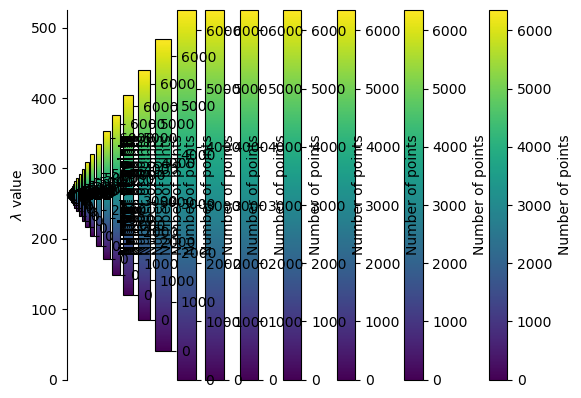

In [1]:
import cluster_data
from cluster_data import run_clustering, normalize_data, unnormalize
import numpy as np
import pandas as pd
import os
import cluster_plotter
from HDBSCAN import hdbscan_clustering
from OPTICS import optics_clustering
from cluster_plotter import ClusterPlotter
from clustering_utils import ClusterData

# Define observed files
uncorr_obs_files = {
    year: f"ogs{year}01_12_det.ele_ucorr" if year != 2002 else f"ogs{year}08_12_det.ele_ucorr"
    for year in range(2002, 2024) if year != 2018  # Exclude 2018 if missing
}

print(uncorr_obs_files)

standard_year_ranges = {f"{start}-{start + 3}": np.arange(start, start + 4) for start in [2002, 2006, 2010, 2014]}
standard_year_ranges["2019-2023"] = np.arange(2019, 2024)

running_ranges = cluster_data.generate_running_year_ranges(2002, 2023, 4)
year_ranges = running_ranges

# Bin the observed data
binned_data = cluster_data.bin_observed_data(uncorr_obs_files, year_ranges, print_res=False)
results_per_year_range = {}

# Set directories for saving plots
images_dir = "Images"
os.makedirs(images_dir, exist_ok=True)
plot_dir = os.path.join(images_dir, "hdbscan_observations_running_bins")
os.makedirs(plot_dir, exist_ok=True)
cluster_plotter.clear_directory(plot_dir)

# Start clustering for each year range
for cluster_data, year_range in binned_data:
    print(f"\nRunning HDBSCAN for Year Range: {year_range}")

    # Prepare data
    data_array = np.array([cluster_data.inc, cluster_data.raan]).T
    normalized_data, data_min, data_max = normalize_data(data_array)

    # Parameter grids for HDBSCAN
    min_cluster_size_values = [50, 100, 150]
    min_samples_values = [None, 20]
    cluster_selection_epsilon_values = [0.01, 0.1]

    results = []

    for min_cluster_size in min_cluster_size_values:
        for min_samples in min_samples_values:
            for cluster_selection_epsilon in cluster_selection_epsilon_values:
                result_hdbscan, time_hdbscan, n_clusters_hdbscan, points_per_cluster_hdbscan, metrics_hdbscan = run_clustering(
                    hdbscan_clustering, "HDBSCAN", normalized_data, data_min, data_max,
                    min_cluster_size=min_cluster_size, min_samples=min_samples, cluster_selection_epsilon=cluster_selection_epsilon,
                    plot_condensed_tree=True, plot=False
                )

                # Check for empty or invalid metrics
                if isinstance(metrics_hdbscan, (list, np.ndarray)) and np.array(metrics_hdbscan).size == 0:
                    metrics_hdbscan = [0, 0, 0, 0, 0, 0, 0]

                # Unnormalize data and cluster centers
                unnormalized_data, cluster_centers = unnormalize(
                    result_hdbscan.data, result_hdbscan.cluster_centers, data_min, data_max
                )

                # Plot the results
                plotter = ClusterPlotter(unnormalized_data, result_hdbscan.labels, cluster_centers)
                plot_filename = os.path.join(plot_dir, f"hdbscan_{year_range}_minclust{min_cluster_size}_minsamples{min_samples}_epsilon{cluster_selection_epsilon}.png")
                title = f"HDBSCAN: years = {year_range}, min_cluster_size: {min_cluster_size}, min_samples: {min_samples}, epsilon: {cluster_selection_epsilon},"
                plotter.clusters_2d_plot(title, plot_filename)

                # Safely handle metrics and round them
                rounded_cluster_std = {key: tuple(round(val, 3) for val in value) for key, value in metrics_hdbscan[4].items()} if isinstance(metrics_hdbscan[4], dict) else None
                rounded_square_density = {key: round(value, 3) for key, value in metrics_hdbscan[5].items()} if isinstance(metrics_hdbscan[5], dict) else None
                rounded_hull_density = {key: round(value, 3) for key, value in metrics_hdbscan[6].items()} if isinstance(metrics_hdbscan[6], dict) else None

                # Prepare results for this set of parameters
                results.append({
                    "Year Range": year_range,
                    "k": n_clusters_hdbscan,
                    "Runtime (s)": f"{time_hdbscan:.3f}",
                    "Clusters": n_clusters_hdbscan,
                    "Points per Cluster": points_per_cluster_hdbscan,
                    "Davies-Bouldin": f"{metrics_hdbscan[0]:.3f}" if isinstance(metrics_hdbscan[0], (int, float)) else None,
                    "Calinski-Harabasz": f"{metrics_hdbscan[1]:.3f}" if isinstance(metrics_hdbscan[1], (int, float)) else None,
                    "Dunn Index": f"{metrics_hdbscan[2]:.3f}" if isinstance(metrics_hdbscan[2], (int, float)) else None,
                    "Silhouette Score": f"{metrics_hdbscan[3]:.3f}" if isinstance(metrics_hdbscan[3], (int, float)) else None,
                    "Cluster Std.": rounded_cluster_std,
                    "Square Density": rounded_square_density,
                    "Hull Density": rounded_hull_density
                })

    # Save results to DataFrame
    df = pd.DataFrame(results)
    display(df)


## Observed data, clustering with DENCLUE

In [1]:
import cluster_data
from cluster_data import run_clustering, normalize_data, unnormalize
import numpy as np
import pandas as pd
import os
import cluster_plotter
from clustering_utils import ClusteringResult
from scipy.spatial.distance import cdist
from DENCLUE import denclue_clustering  # Import DENCLUE clustering function
from cluster_plotter import ClusterPlotter

uncorr_obs_files = {
    year: f"ogs{year}01_12_det.ele_ucorr" if year != 2002 else f"ogs{year}08_12_det.ele_ucorr"
    for year in range(2002, 2024) if year != 2018  # Exclude 2018 if missing
}

print(uncorr_obs_files)

standard_year_ranges = {f"{start}-{start + 3}": np.arange(start, start + 4) for start in [2002, 2006, 2010, 2014]}
standard_year_ranges["2019-2023"] = np.arange(2019, 2024)

running_ranges = cluster_data.generate_running_year_ranges(2002, 2023, 4)
year_ranges = standard_year_ranges

binned_data = cluster_data.bin_observed_data(uncorr_obs_files, year_ranges, print_res=False)

results_per_year_range = {}

plot_dir = "Images/denclue_observations_normal_bins"
os.makedirs(plot_dir, exist_ok=True)
cluster_plotter.clear_directory(plot_dir)

for cluster_data, year_range in binned_data:  
    print(f"\nRunning DENCLUE for Year Range: {year_range}")

    data_array = np.array([cluster_data.inc, cluster_data.raan]).T
    normalized_data, data_min, data_max = normalize_data(data_array)

    epsilon_vals = [5, 10, 20]
    max_iter_vals = [100, 200]
    bandwidth_vals = [0.001, 0.005, 0.01]

    results = []

    for epsilon in epsilon_vals:
        for max_iter in max_iter_vals:
            for bandwidth in bandwidth_vals:
                result_denclue, time_denclue, n_clusters_denclue, points_per_cluster_denclue, metrics_denclue = run_clustering(
                    denclue_clustering, "DENCLUE",
                    normalized_data, data_min, data_max, epsilon=epsilon, max_iter=max_iter, bandwidth=bandwidth, plot=False
                )

                # Check if the clustering result contains any clusters
                if len(result_denclue.cluster_centers) > 0:
                    unnormalized_data, cluster_centers = unnormalize(
                        result_denclue.data, result_denclue.cluster_centers, data_min, data_max
                    )
                    plotter = ClusterPlotter(unnormalized_data, result_denclue.labels, None)
                    plot_filename = os.path.join(plot_dir, f"denclue_{year_range}_eps{epsilon}_maxiter{max_iter}_bandwidth{bandwidth}.png")
                    title = f"DENCLUE: years = {year_range}, epsilon: {epsilon}, max_iter: {max_iter}, bandwidth: {bandwidth}"
                    plotter.clusters_2d_plot(title, plot_filename, show_centers=False)

                    rounded_cluster_std = {key: tuple(round(val, 3) for val in value) for key, value in metrics_denclue[4].items()}
                    rounded_square_density = {key: round(value, 3) for key, value in metrics_denclue[5].items()}
                    rounded_hull_density = {key: round(value, 3) for key, value in metrics_denclue[6].items()}

                    results.append({
                        "Year Range": year_range,
                        "k": n_clusters_denclue,
                        "Runtime (s)": f"{time_denclue:.3f}",
                        "Clusters": n_clusters_denclue,
                        "Points per Cluster": points_per_cluster_denclue,
                        "Davies-Bouldin": f"{metrics_denclue[0]:.3f}" if metrics_denclue and isinstance(metrics_denclue[0], (int, float)) else None,
                        "Calinski-Harabasz": f"{metrics_denclue[1]:.3f}" if metrics_denclue and isinstance(metrics_denclue[1], (int, float)) else None,
                        "Dunn Index": f"{metrics_denclue[2]:.3f}" if metrics_denclue and isinstance(metrics_denclue[2], (int, float)) else None,
                        "Silhouette Score": f"{metrics_denclue[3]:.3f}" if metrics_denclue and isinstance(metrics_denclue[3], (int, float)) else None,
                        "Cluster Std.": rounded_cluster_std if rounded_cluster_std else None,
                        "Square Density": rounded_square_density if rounded_square_density else None,
                        "Hull Density": rounded_hull_density if rounded_hull_density else None
                    })
                else:
                    print(f"No clusters formed for epsilon={epsilon}, max_iter={max_iter}, bandwidth={bandwidth}. Skipping plotting and results.")
                    # Adding a default entry for cases with no clusters formed
                    results.append({
                        "Year Range": year_range,
                        "k": 0,
                        "Runtime (s)": None,
                        "Clusters": 0,
                        "Points per Cluster": None,
                        "Davies-Bouldin": None,
                        "Calinski-Harabasz": None,
                        "Dunn Index": None,
                        "Silhouette Score": None,
                        "Cluster Std.": None,
                        "Square Density": None,
                        "Hull Density": None
                    })

    # Convert results to DataFrame and display
    df = pd.DataFrame(results)
    display(df)

{2002: 'ogs200208_12_det.ele_ucorr', 2003: 'ogs200301_12_det.ele_ucorr', 2004: 'ogs200401_12_det.ele_ucorr', 2005: 'ogs200501_12_det.ele_ucorr', 2006: 'ogs200601_12_det.ele_ucorr', 2007: 'ogs200701_12_det.ele_ucorr', 2008: 'ogs200801_12_det.ele_ucorr', 2009: 'ogs200901_12_det.ele_ucorr', 2010: 'ogs201001_12_det.ele_ucorr', 2011: 'ogs201101_12_det.ele_ucorr', 2012: 'ogs201201_12_det.ele_ucorr', 2013: 'ogs201301_12_det.ele_ucorr', 2014: 'ogs201401_12_det.ele_ucorr', 2015: 'ogs201501_12_det.ele_ucorr', 2016: 'ogs201601_12_det.ele_ucorr', 2017: 'ogs201701_12_det.ele_ucorr', 2019: 'ogs201901_12_det.ele_ucorr', 2020: 'ogs202001_12_det.ele_ucorr', 2021: 'ogs202101_12_det.ele_ucorr', 2022: 'ogs202201_12_det.ele_ucorr', 2023: 'ogs202301_12_det.ele_ucorr'}

Running DENCLUE for Year Range: 2002-2005
Runtime for denclue_clustering: 0.841866 seconds
Plot saved as: Images/denclue_observations_normal_bins\denclue_2002-2005_eps5_maxiter100_bandwidth0.001.png
Runtime for denclue_clustering: 2.112659 se

,Year Range,k,Runtime (s),Clusters,Points per Cluster,Davies-Bouldin,Calinski-Harabasz,Dunn Index,Silhouette Score,Cluster Std.,Square Density,Hull Density
0,2002-2005,2,0.842,2,"{-1.0: 5484, 1159.0: 868}",11.415,14.473,0.000,-0.400,"{-1.0: (0.191, 0.234), 1159.0: (0.063, 0.21)}","{-1.0: 5484.0, 1159.0: 1872.356}","{-1.0: 5624.464, 1159.0: 3666.131}"
1,2002-2005,2,2.113,2,"{5589.0: 3506, -1.0: 2846}",7.254,96.390,0.000,-0.198,"{-1.0: (0.242, 0.258), 5589.0: (0.087, 0.209)}","{-1.0: 2846.0, 5589.0: 4386.018}","{-1.0: 2918.896, 5589.0: 7870.402}"
2,2002-2005,2,2.377,2,"{5638.0: 4834, -1.0: 1518}",8.035,72.903,0.002,-0.096,"{-1.0: (0.254, 0.295), 5638.0: (0.119, 0.222)}","{-1.0: 1518.118, 5638.0: 5645.568}","{-1.0: 1558.621, 5638.0: 7931.475}"
3,2002-2005,2,2.450,2,"{-1.0: 5484, 1159.0: 868}",11.415,14.473,0.000,-0.400,"{-1.0: (0.191, 0.234), 1159.0: (0.063, 0.21)}","{-1.0: 5484.0, 1159.0: 1872.356}","{-1.0: 5624.464, 1159.0: 3666.131}"
4,2002-2005,2,3.763,2,"{5589.0: 3506, -1.0: 2846}",7.254,96.390,0.000,-0.198,"{-1.0: (0.242, 0.258), 5589.0: (0.087, 0.209)}","{-1.0: 2846.0, 5589.0: 4386.018}","{-1.0: 2918.896, 5589.0: 7870.402}"
5,2002-2005,2,0.944,2,"{5638.0: 4834, -1.0: 1518}",8.035,72.903,0.002,-0.096,"{-1.0: (0.254, 0.295), 5638.0: (0.119, 0.222)}","{-1.0: 1518.118, 5638.0: 5645.568}","{-1.0: 1558.621, 5638.0: 7931.475}"
6,2002-2005,2,1.216,2,"{-1.0: 6054, 1159.0: 298}",58.999,0.207,0.000,-0.431,"{-1.0: (0.183, 0.232), 1159.0: (0.052, 0.215)}","{-1.0: 6054.0, 1159.0: 1646.254}","{-1.0: 6209.063, 1159.0: 6048.746}"
7,2002-2005,2,1.125,2,"{5589.0: 2583, -1.0: 3769}",6.384,106.490,0.000,-0.270,"{-1.0: (0.225, 0.246), 5589.0: (0.062, 0.203)}","{-1.0: 3769.0, 5589.0: 5738.426}","{-1.0: 3865.537, 5589.0: 10973.765}"
8,2002-2005,2,0.943,2,"{5638.0: 3904, -1.0: 2448}",6.413,128.697,0.001,-0.143,"{-1.0: (0.258, 0.273), 5638.0: (0.071, 0.207)}","{-1.0: 2448.0, 5638.0: 5907.604}","{-1.0: 2510.702, 5638.0: 9575.407}"
9,2002-2005,2,1.026,2,"{-1.0: 6054, 1159.0: 298}",58.999,0.207,0.000,-0.431,"{-1.0: (0.183, 0.232), 1159.0: (0.052, 0.215)}","{-1.0: 6054.0, 1159.0: 1646.254}","{-1.0: 6209.063, 1159.0: 6048.746}"



Running DENCLUE for Year Range: 2006-2009
Runtime for denclue_clustering: 0.854702 seconds
Plot saved as: Images/denclue_observations_normal_bins\denclue_2006-2009_eps5_maxiter100_bandwidth0.001.png
Runtime for denclue_clustering: 0.754382 seconds
Plot saved as: Images/denclue_observations_normal_bins\denclue_2006-2009_eps5_maxiter100_bandwidth0.005.png
Runtime for denclue_clustering: 0.629362 seconds
Plot saved as: Images/denclue_observations_normal_bins\denclue_2006-2009_eps5_maxiter100_bandwidth0.01.png
Runtime for denclue_clustering: 0.691624 seconds
Plot saved as: Images/denclue_observations_normal_bins\denclue_2006-2009_eps5_maxiter200_bandwidth0.001.png
Runtime for denclue_clustering: 0.704576 seconds
Plot saved as: Images/denclue_observations_normal_bins\denclue_2006-2009_eps5_maxiter200_bandwidth0.005.png
Runtime for denclue_clustering: 0.605090 seconds
Plot saved as: Images/denclue_observations_normal_bins\denclue_2006-2009_eps5_maxiter200_bandwidth0.01.png
Runtime for dencl

,Year Range,k,Runtime (s),Clusters,Points per Cluster,Davies-Bouldin,Calinski-Harabasz,Dunn Index,Silhouette Score,Cluster Std.,Square Density,Hull Density
0,2006-2009,2,0.855,2,"{4027.0: 346, -1.0: 5199}",6.746,11.883,0.000,-0.515,"{-1.0: (0.153, 0.203), 4027.0: (0.06, 0.097)}","{-1.0: 5199.0, 4027.0: 4285.218}","{-1.0: 5340.629, 4027.0: 6881.502}"
1,2006-2009,2,0.754,2,"{4027.0: 2998, -1.0: 2547}",4.156,239.271,0.000,-0.161,"{-1.0: (0.199, 0.241), 4027.0: (0.086, 0.136)}","{-1.0: 2547.0, 4027.0: 8211.989}","{-1.0: 2616.384, 4027.0: 13226.327}"
2,2006-2009,2,0.629,2,"{4042.0: 4187, -1.0: 1358}",5.675,137.458,0.002,-0.030,"{-1.0: (0.251, 0.269), 4042.0: (0.096, 0.163)}","{-1.0: 1358.0, 4042.0: 5582.964}","{-1.0: 1394.994, 4042.0: 9025.002}"
3,2006-2009,2,0.692,2,"{4027.0: 346, -1.0: 5199}",6.746,11.883,0.000,-0.515,"{-1.0: (0.153, 0.203), 4027.0: (0.06, 0.097)}","{-1.0: 5199.0, 4027.0: 4285.218}","{-1.0: 5340.629, 4027.0: 6881.502}"
4,2006-2009,2,0.705,2,"{4027.0: 2998, -1.0: 2547}",4.156,239.271,0.000,-0.161,"{-1.0: (0.199, 0.241), 4027.0: (0.086, 0.136)}","{-1.0: 2547.0, 4027.0: 8211.989}","{-1.0: 2616.384, 4027.0: 13226.327}"
5,2006-2009,2,0.605,2,"{4042.0: 4187, -1.0: 1358}",5.675,137.458,0.002,-0.030,"{-1.0: (0.251, 0.269), 4042.0: (0.096, 0.163)}","{-1.0: 1358.0, 4042.0: 5582.964}","{-1.0: 1394.994, 4042.0: 9025.002}"
6,2006-2009,2,0.669,2,"{4027.0: 46, -1.0: 5499}",9.286,0.799,0.000,-0.586,"{-1.0: (0.151, 0.198), 4027.0: (0.018, 0.094)}","{-1.0: 5499.0, 4027.0: 1937.494}","{-1.0: 5648.801, 4027.0: 6200.612}"
7,2006-2009,2,0.667,2,"{4027.0: 2191, -1.0: 3354}",4.585,158.103,0.000,-0.261,"{-1.0: (0.18, 0.23), 4027.0: (0.081, 0.121)}","{-1.0: 3354.0, 4027.0: 9606.738}","{-1.0: 3445.368, 4027.0: 17151.524}"
8,2006-2009,2,0.631,2,"{4042.0: 3457, -1.0: 2088}",4.028,273.969,0.001,-0.094,"{-1.0: (0.215, 0.254), 4042.0: (0.088, 0.139)}","{-1.0: 2088.0, 4042.0: 10475.505}","{-1.0: 2144.88, 4042.0: 17523.666}"
9,2006-2009,2,0.629,2,"{4027.0: 46, -1.0: 5499}",9.286,0.799,0.000,-0.586,"{-1.0: (0.151, 0.198), 4027.0: (0.018, 0.094)}","{-1.0: 5499.0, 4027.0: 1937.494}","{-1.0: 5648.801, 4027.0: 6200.612}"



Running DENCLUE for Year Range: 2010-2013
Runtime for denclue_clustering: 0.129363 seconds
Plot saved as: Images/denclue_observations_normal_bins\denclue_2010-2013_eps5_maxiter100_bandwidth0.001.png
Runtime for denclue_clustering: 0.146102 seconds
Plot saved as: Images/denclue_observations_normal_bins\denclue_2010-2013_eps5_maxiter100_bandwidth0.005.png
Runtime for denclue_clustering: 0.096054 seconds
Plot saved as: Images/denclue_observations_normal_bins\denclue_2010-2013_eps5_maxiter100_bandwidth0.01.png
Runtime for denclue_clustering: 0.099658 seconds
Plot saved as: Images/denclue_observations_normal_bins\denclue_2010-2013_eps5_maxiter200_bandwidth0.001.png
Runtime for denclue_clustering: 0.114532 seconds
Plot saved as: Images/denclue_observations_normal_bins\denclue_2010-2013_eps5_maxiter200_bandwidth0.005.png
Runtime for denclue_clustering: 0.139092 seconds
Plot saved as: Images/denclue_observations_normal_bins\denclue_2010-2013_eps5_maxiter200_bandwidth0.01.png
Runtime for dencl

,Year Range,k,Runtime (s),Clusters,Points per Cluster,Davies-Bouldin,Calinski-Harabasz,Dunn Index,Silhouette Score,Cluster Std.,Square Density,Hull Density
0,2010-2013,2,0.129,2,"{-1.0: 2013, 239.0: 111}",3.389,17.708,0.000,-0.470,"{-1.0: (0.142, 0.215), 239.0: (0.069, 0.129)}","{-1.0: 2013.0, 239.0: 851.594}","{-1.0: 2238.8, 239.0: 1549.389}"
1,2010-2013,2,0.146,2,"{1374.0: 1233, -1.0: 891}",3.227,158.850,0.000,-0.176,"{-1.0: (0.181, 0.25), 1374.0: (0.083, 0.166)}","{-1.0: 891.0, 1374.0: 2609.36}","{-1.0: 990.944, 1374.0: 4272.95}"
2,2010-2013,2,0.096,2,"{1830.0: 1555, -1.0: 569}",3.158,159.399,0.002,-0.073,"{-1.0: (0.208, 0.266), 1830.0: (0.098, 0.175)}","{-1.0: 569.0, 1830.0: 2282.709}","{-1.0: 632.825, 1830.0: 4216.361}"
3,2010-2013,2,0.100,2,"{-1.0: 2013, 239.0: 111}",3.389,17.708,0.000,-0.470,"{-1.0: (0.142, 0.215), 239.0: (0.069, 0.129)}","{-1.0: 2013.0, 239.0: 851.594}","{-1.0: 2238.8, 239.0: 1549.389}"
4,2010-2013,2,0.115,2,"{1374.0: 1233, -1.0: 891}",3.227,158.850,0.000,-0.176,"{-1.0: (0.181, 0.25), 1374.0: (0.083, 0.166)}","{-1.0: 891.0, 1374.0: 2609.36}","{-1.0: 990.944, 1374.0: 4272.95}"
5,2010-2013,2,0.139,2,"{1830.0: 1555, -1.0: 569}",3.158,159.399,0.002,-0.073,"{-1.0: (0.208, 0.266), 1830.0: (0.098, 0.175)}","{-1.0: 569.0, 1830.0: 2282.709}","{-1.0: 632.825, 1830.0: 4216.361}"
6,2010-2013,0,None,0,None,None,None,None,None,None,None,None
7,2010-2013,2,0.098,2,"{1374.0: 703, -1.0: 1421}",4.101,70.015,0.000,-0.321,"{-1.0: (0.159, 0.236), 1374.0: (0.06, 0.146)}","{-1.0: 1421.0, 1374.0: 4350.689}","{-1.0: 1580.395, 1374.0: 8142.683}"
8,2010-2013,2,0.084,2,"{1830.0: 1309, -1.0: 815}",2.344,306.072,0.000,-0.094,"{-1.0: (0.191, 0.253), 1830.0: (0.074, 0.153)}","{-1.0: 815.0, 1830.0: 6380.631}","{-1.0: 906.419, 1830.0: 9578.622}"
9,2010-2013,0,None,0,None,None,None,None,None,None,None,None



Running DENCLUE for Year Range: 2014-2017
Runtime for denclue_clustering: 0.064934 seconds
Plot saved as: Images/denclue_observations_normal_bins\denclue_2014-2017_eps5_maxiter100_bandwidth0.001.png
Runtime for denclue_clustering: 0.111418 seconds
Plot saved as: Images/denclue_observations_normal_bins\denclue_2014-2017_eps5_maxiter100_bandwidth0.005.png
Runtime for denclue_clustering: 0.061567 seconds
Plot saved as: Images/denclue_observations_normal_bins\denclue_2014-2017_eps5_maxiter100_bandwidth0.01.png
Runtime for denclue_clustering: 0.068043 seconds
Plot saved as: Images/denclue_observations_normal_bins\denclue_2014-2017_eps5_maxiter200_bandwidth0.001.png
Runtime for denclue_clustering: 0.066592 seconds
Plot saved as: Images/denclue_observations_normal_bins\denclue_2014-2017_eps5_maxiter200_bandwidth0.005.png
Runtime for denclue_clustering: 0.051925 seconds
Plot saved as: Images/denclue_observations_normal_bins\denclue_2014-2017_eps5_maxiter200_bandwidth0.01.png
Runtime for dencl

,Year Range,k,Runtime (s),Clusters,Points per Cluster,Davies-Bouldin,Calinski-Harabasz,Dunn Index,Silhouette Score,Cluster Std.,Square Density,Hull Density
0,2014-2017,2,0.065,2,"{976.0: 53, -1.0: 1500}",1.797,50.048,0.000,-0.103,"{-1.0: (0.163, 0.235), 976.0: (0.171, 0.237)}","{-1.0: 1500.0, 976.0: 115.881}","{-1.0: 1663.031, 976.0: 259.729}"
1,2014-2017,2,0.111,2,"{979.0: 229, -1.0: 1324}",15.473,2.960,0.000,-0.222,"{-1.0: (0.162, 0.23), 979.0: (0.204, 0.271)}","{-1.0: 1324.0, 979.0: 394.313}","{-1.0: 1467.902, 979.0: 738.014}"
2,2014-2017,2,0.062,2,"{979.0: 755, -1.0: 798}",11.958,8.154,0.000,-0.267,"{-1.0: (0.192, 0.245), 979.0: (0.139, 0.227)}","{-1.0: 798.0, 979.0: 945.441}","{-1.0: 884.732, 979.0: 1845.486}"
3,2014-2017,2,0.068,2,"{976.0: 53, -1.0: 1500}",1.797,50.048,0.000,-0.103,"{-1.0: (0.163, 0.235), 976.0: (0.171, 0.237)}","{-1.0: 1500.0, 976.0: 115.881}","{-1.0: 1663.031, 976.0: 259.729}"
4,2014-2017,2,0.067,2,"{979.0: 229, -1.0: 1324}",15.473,2.960,0.000,-0.222,"{-1.0: (0.162, 0.23), 979.0: (0.204, 0.271)}","{-1.0: 1324.0, 979.0: 394.313}","{-1.0: 1467.902, 979.0: 738.014}"
5,2014-2017,2,0.052,2,"{979.0: 755, -1.0: 798}",11.958,8.154,0.000,-0.267,"{-1.0: (0.192, 0.245), 979.0: (0.139, 0.227)}","{-1.0: 798.0, 979.0: 945.441}","{-1.0: 884.732, 979.0: 1845.486}"
6,2014-2017,2,0.054,2,"{976.0: 23, -1.0: 1530}",0.570,54.570,0.000,-0.054,"{-1.0: (0.164, 0.236), 976.0: (0.0, 0.001)}","{-1.0: 1530.0, 976.0: 4305687.14}","{-1.0: 1696.291, 976.0: 6913936.633}"
7,2014-2017,2,0.046,2,"{979.0: 71, -1.0: 1482}",1.579,103.840,0.004,-0.017,"{-1.0: (0.159, 0.23), 979.0: (0.06, 0.32)}","{-1.0: 1482.0, 979.0: 462.044}","{-1.0: 1643.074, 979.0: 1216.156}"
8,2014-2017,2,0.048,2,"{979.0: 273, -1.0: 1280}",17.981,2.191,0.001,-0.258,"{-1.0: (0.167, 0.232), 979.0: (0.174, 0.26)}","{-1.0: 1280.0, 979.0: 506.124}","{-1.0: 1419.12, 979.0: 1040.473}"
9,2014-2017,2,0.054,2,"{976.0: 23, -1.0: 1530}",0.570,54.570,0.000,-0.054,"{-1.0: (0.164, 0.236), 976.0: (0.0, 0.001)}","{-1.0: 1530.0, 976.0: 4305687.14}","{-1.0: 1696.291, 976.0: 6913936.633}"



Running DENCLUE for Year Range: 2019-2023
Runtime for denclue_clustering: 0.278944 seconds
Plot saved as: Images/denclue_observations_normal_bins\denclue_2019-2023_eps5_maxiter100_bandwidth0.001.png
Runtime for denclue_clustering: 0.277235 seconds
Plot saved as: Images/denclue_observations_normal_bins\denclue_2019-2023_eps5_maxiter100_bandwidth0.005.png
Runtime for denclue_clustering: 0.243983 seconds
Plot saved as: Images/denclue_observations_normal_bins\denclue_2019-2023_eps5_maxiter100_bandwidth0.01.png
Runtime for denclue_clustering: 0.251559 seconds
Plot saved as: Images/denclue_observations_normal_bins\denclue_2019-2023_eps5_maxiter200_bandwidth0.001.png
Runtime for denclue_clustering: 0.257273 seconds
Plot saved as: Images/denclue_observations_normal_bins\denclue_2019-2023_eps5_maxiter200_bandwidth0.005.png
Runtime for denclue_clustering: 0.261816 seconds
Plot saved as: Images/denclue_observations_normal_bins\denclue_2019-2023_eps5_maxiter200_bandwidth0.01.png
Runtime for dencl

,Year Range,k,Runtime (s),Clusters,Points per Cluster,Davies-Bouldin,Calinski-Harabasz,Dunn Index,Silhouette Score,Cluster Std.,Square Density,Hull Density
0,2019-2023,2,0.279,2,"{2917.0: 120, -1.0: 3305}",2.623,17.981,0.000,-0.550,"{-1.0: (0.207, 0.223), 2917.0: (0.006, 0.057)}","{-1.0: 3305.0, 2917.0: 2395.909}","{-1.0: 3376.283, 2917.0: 27912.184}"
1,2019-2023,2,0.277,2,"{2606.0: 956, -1.0: 2469}",3.632,114.461,0.000,-0.293,"{-1.0: (0.223, 0.244), 2606.0: (0.111, 0.132)}","{-1.0: 2469.0, 2606.0: 2123.463}","{-1.0: 2522.252, 2606.0: 3162.873}"
2,2019-2023,2,0.244,2,"{2708.0: 2054, -1.0: 1371}",7.146,55.545,0.001,-0.190,"{-1.0: (0.251, 0.27), 2708.0: (0.15, 0.186)}","{-1.0: 1371.0, 2708.0: 2804.284}","{-1.0: 1400.57, 2708.0: 3992.551}"
3,2019-2023,2,0.252,2,"{2917.0: 120, -1.0: 3305}",2.623,17.981,0.000,-0.550,"{-1.0: (0.207, 0.223), 2917.0: (0.006, 0.057)}","{-1.0: 3305.0, 2917.0: 2395.909}","{-1.0: 3376.283, 2917.0: 27912.184}"
4,2019-2023,2,0.257,2,"{2606.0: 956, -1.0: 2469}",3.632,114.461,0.000,-0.293,"{-1.0: (0.223, 0.244), 2606.0: (0.111, 0.132)}","{-1.0: 2469.0, 2606.0: 2123.463}","{-1.0: 2522.252, 2606.0: 3162.873}"
5,2019-2023,2,0.262,2,"{2708.0: 2054, -1.0: 1371}",7.146,55.545,0.001,-0.190,"{-1.0: (0.251, 0.27), 2708.0: (0.15, 0.186)}","{-1.0: 1371.0, 2708.0: 2804.284}","{-1.0: 1400.57, 2708.0: 3992.551}"
6,2019-2023,2,0.235,2,"{2917.0: 16, -1.0: 3409}",2.445,2.168,0.001,-0.606,"{-1.0: (0.204, 0.221), 2917.0: (0.0, 0.0)}","{-1.0: 3409.0, 2917.0: 48181564.652}","{-1.0: 3482.526, 2917.0: 92862064.54}"
7,2019-2023,2,0.296,2,"{2606.0: 480, -1.0: 2945}",2.342,105.365,0.000,-0.394,"{-1.0: (0.215, 0.234), 2606.0: (0.04, 0.059)}","{-1.0: 2945.0, 2606.0: 9998.531}","{-1.0: 3008.518, 2606.0: 19668.843}"
8,2019-2023,2,0.262,2,"{2708.0: 1198, -1.0: 2227}",3.661,141.045,0.000,-0.249,"{-1.0: (0.227, 0.252), 2708.0: (0.114, 0.141)}","{-1.0: 2227.0, 2708.0: 2958.953}","{-1.0: 2275.032, 2708.0: 4771.629}"
9,2019-2023,2,0.274,2,"{2917.0: 16, -1.0: 3409}",2.445,2.168,0.001,-0.606,"{-1.0: (0.204, 0.221), 2917.0: (0.0, 0.0)}","{-1.0: 3409.0, 2917.0: 48181564.652}","{-1.0: 3482.526, 2917.0: 92862064.54}"
